<a href="https://colab.research.google.com/github/nilakanta123/Short-Term-Load-Forecasting/blob/main/PConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from tensorflow.keras import Model, callbacks, layers
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# TETUAN CITY DATASET

In [8]:
path = "/content/drive/MyDrive/DATASETS/Tetuan City power consumption.csv"
dataset = pd.read_csv(path)
dataset['DateTime'] = pd.to_datetime(dataset['DateTime'])
dataset.set_index("DateTime", inplace=True)
dataset.sort_index(inplace=True)
dataset['Load'] = dataset['Zone 1 Power Consumption'] + dataset['Zone 2  Power Consumption'] + dataset['Zone 3  Power Consumption']
dataset = dataset.resample('60T').mean()
# dataset["Date"] = dataset.index
dataset.drop(columns=['Zone 1 Power Consumption','Zone 2  Power Consumption', 'Zone 3  Power Consumption',],inplace=True)
dataset.columns

import math
def split_dataset(data):
    # split into standard days (n*24)
    n_fold = 4
    fold_size = math.floor(data.shape[0]/(n_fold+1))
    train1, test1 = data[:fold_size], data[fold_size:fold_size*2]
    train2, test2 = data[:fold_size*2], data[fold_size*2:fold_size*3]
    train3, test3 = data[:fold_size*3], data[fold_size*3:fold_size*4]
    train4, test4 = data[:fold_size*4], data[fold_size*4:]
    # restructure into windows of daily data
    train1 = np.array(train1)
    test1 = np.array(test1)
    train2 = np.array(train2)
    test2 = np.array(test2)
    train3 = np.array(train3)
    test3 = np.array(test3)
    train4 = np.array(train4)
    test4 = np.array(test4)
    return train1, test1, train2, test2, train3, test3, train4, test4
train1, test1, train2, test2, train3, test3, train4, test4 = split_dataset(dataset.values)

print("4-Fold Train set are \n {} \n {} \n {} \n {} \nTest set shapes are \n {} \n {} \n {} \n {}".format(
    train1.shape,train2.shape,train3.shape,train4.shape,test1.shape,test2.shape,test3.shape,test4.shape))

def plotForDay(n, results):
  n=50
  plt.figure(figsize=(15,5))
  hours = [x for x in range(n)]
  plt.plot(hours, results['Predictions'].flatten()[:n], label='Predicted Load', marker='X',zorder=-10)
  plt.plot(hours, results['Actual'].flatten()[:n], label='Actual Load', marker='o',zorder=-10)
  plt.xticks(hours)
  # plt.title("Input day {} -> Predicted day {}.".format(results['Input_days'][n],results['Prediction_days'][n]))
  plt.ylabel('Load')
  plt.xlabel('Hours')
  plt.legend()
  plt.show()
  print("\n")

def evaluate_forecasts(actu, pred):
  # mae, mape, rmse, r2
  mae = mean_absolute_error(actu, pred)
  mape = mean_absolute_percentage_error(actu, pred)*100
  mse = mean_squared_error(actu, pred)
  rmse = math.sqrt(mse)
  r2 = r2_score(actu, pred)
  return mae, mape, rmse, r2

def plot_history(history):
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('\nLearning Curve of the model')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'validation loss'])
    plt.show()

def reframe(data, lookback, lookahead):
    x_load, x_temp, x_hum, x_wind, x_gdf, x_df, y = [],[],[],[],[],[],[]
    start = 0
    for _ in range(len(data)):
        feature_end = start + lookback
        label_end = feature_end + lookahead
        if label_end <= len(data):
            # historical load feature
            v = data[start:feature_end, 5]
            v = v.reshape(len(v),1)
            x_load.append(v)
            # temperature features
            v = data[start:feature_end, 0]
            v = v.reshape(len(v),1)
            x_temp.append(v)
            # humidity features
            v = data[start:feature_end, 1]
            v = v.reshape(len(v),1)
            x_hum.append(v)
            # wind features
            v = data[start:feature_end, 2]
            v = v.reshape(len(v),1)
            x_wind.append(v)
            # gdf features
            v = data[start:feature_end, 3]
            v = v.reshape(len(v),1)
            x_gdf.append(v)
            # df features
            v = data[start:feature_end, 4]
            v = v.reshape(len(v),1)
            x_df.append(v)
            # load labels
            v = data[feature_end:label_end, 5]
            v = v.reshape(len(v),1)
            y.append(v)
        start += lookahead
    x_load, x_temp, x_hum, x_wind, x_gdf, x_df = np.asarray(x_load).astype('float32'),np.asarray(x_temp).astype('float32'),np.asarray(x_hum).astype('float32'),np.asarray(x_wind).astype('float32'),np.asarray(x_gdf).astype('float32'),np.asarray(x_df).astype('float32')
    y = np.asarray(y).astype('float32')
    return x_load, x_temp, x_hum, x_wind, x_gdf, x_df, y

lookahead = 1
lookback = 96
es = callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=30,verbose=1)
rop = callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.2,min_lr=0.001)
# mc = callbacks.ModelCheckpoint('best_model.h5',monitor='val_loss',mode='min',save_best_only=True)
verbose, epochs, batch_size = 1, 1, 64

4-Fold Train set are 
 (1747, 6) 
 (3494, 6) 
 (5241, 6) 
 (6988, 6) 
Test set shapes are 
 (1747, 6) 
 (1747, 6) 
 (1747, 6) 
 (1748, 6)


In [ ]:
_, _, _, _, _, _, cv1_actu = reframe(test1, lookback, lookahead)
cv1_actu = cv1_actu.ravel()
_, _, _, _, _, _, cv2_actu = reframe(test2, lookback, lookahead)
cv2_actu = cv2_actu.ravel()
_, _, _, _, _, _, cv3_actu = reframe(test3, lookback, lookahead)
cv3_actu = cv3_actu.ravel()
_, _, _, _, _, _, cv4_actu = reframe(test4, lookback, lookahead)
cv4_actu = cv4_actu.ravel()

In [ ]:
print(cv1_actu.tolist())

[92264.6953125, 92095.2421875, 89534.2265625, 84718.8203125, 75244.7734375, 63731.1171875, 56180.37109375, 51928.0703125, 50120.54296875, 49562.01171875, 50262.0546875, 41239.9609375, 39809.453125, 44608.29296875, 52319.46484375, 60212.80078125, 64491.15625, 66792.015625, 67782.3046875, 66501.2109375, 64319.08984375, 62313.546875, 60848.1328125, 72950.1796875, 89585.15625, 91314.5234375, 89937.671875, 84041.1484375, 72167.765625, 60976.4375, 54035.98828125, 50882.49609375, 49381.23828125, 49885.09765625, 51110.9296875, 44151.21484375, 47606.8359375, 53026.89453125, 60497.484375, 65968.3828125, 70872.1953125, 73018.828125, 72600.9140625, 71357.3828125, 70769.34375, 68571.140625, 67422.5, 81152.5078125, 95763.2734375, 96036.640625, 92809.171875, 84076.8671875, 72132.03125, 61213.4921875, 54863.71484375, 51409.14453125, 50303.6796875, 51257.86328125, 52109.34765625, 44917.1875, 48466.5625, 53298.27734375, 56978.36328125, 62423.17578125, 67168.65625, 70269.8203125, 70862.9296875, 71153.531

In [ ]:
print(cv2_actu.tolist())

[75811.25, 74429.5625, 73885.6484375, 76335.234375, 83418.8515625, 98243.1171875, 98816.859375, 95951.34375, 93815.4140625, 87918.2265625, 81258.4921875, 79420.4765625, 83243.03125, 71441.3515625, 58087.47265625, 46931.51171875, 45815.95703125, 48184.3984375, 53274.3125, 58424.4140625, 63464.16796875, 65953.2578125, 69949.890625, 74294.5859375, 74545.2890625, 74062.7109375, 74092.8125, 77058.5703125, 85568.8046875, 98451.3828125, 98899.34375, 95992.734375, 94743.421875, 88865.5546875, 81661.359375, 80089.9765625, 84502.7578125, 72661.6640625, 58861.015625, 47884.6875, 46246.40625, 48009.03125, 52762.6640625, 58858.5, 64137.21484375, 69733.5, 72679.546875, 74168.140625, 74890.1328125, 74781.953125, 74504.3046875, 76703.9140625, 85232.5625, 99691.8125, 100017.2421875, 97304.046875, 95870.109375, 90429.9921875, 84345.609375, 82061.875, 85476.2734375, 72536.6875, 59399.92578125, 47798.00390625, 46094.9375, 48677.64453125, 53188.45703125, 58697.41796875, 64693.01953125, 69304.75, 70004.5937

In [ ]:
print(cv3_actu.tolist())

[84910.1328125, 91875.2890625, 96076.953125, 96331.1796875, 95990.84375, 94792.1953125, 92949.015625, 91852.7265625, 91100.4375, 92810.34375, 112485.0078125, 119843.6484375, 116493.921875, 110081.5859375, 100044.3984375, 88627.1640625, 79522.046875, 73566.015625, 70356.671875, 69407.515625, 59525.9609375, 57173.9140625, 63735.2109375, 73492.5703125, 82620.6328125, 88689.9765625, 92482.2578125, 94959.5, 95720.265625, 94081.171875, 92236.171875, 91214.59375, 91470.6953125, 94944.5, 116205.6875, 122397.7421875, 117985.0234375, 110849.828125, 101395.9140625, 91341.875, 81829.5234375, 74564.5, 71436.9453125, 67530.7890625, 58430.8125, 56149.44921875, 60819.53515625, 69089.453125, 76640.71875, 83259.078125, 87299.03125, 89852.1953125, 91011.9375, 89494.3828125, 87343.859375, 86716.0703125, 87002.375, 90814.4140625, 110772.1328125, 117350.4453125, 114298.53125, 108068.9453125, 97592.890625, 86763.890625, 77548.65625, 71406.1171875, 68676.6171875, 67239.2265625, 57692.734375, 55527.94140625, 6

In [ ]:
print(cv4_actu.tolist())

[52431.93359375, 54926.28125, 52373.203125, 52355.6015625, 57684.05859375, 62928.5703125, 67596.796875, 70992.859375, 72073.4375, 71590.6015625, 71553.2265625, 69924.625, 68650.203125, 78459.546875, 94630.1796875, 94443.875, 91405.3046875, 84345.609375, 74373.2265625, 64537.48828125, 58105.1953125, 54209.609375, 52406.83203125, 51907.28125, 52293.1328125, 56223.8046875, 53408.2734375, 53649.87890625, 58872.796875, 63774.8046875, 68276.859375, 72248.671875, 73062.1796875, 72514.84375, 71711.546875, 69981.375, 69145.84375, 78731.0625, 94947.4609375, 94600.421875, 92381.03125, 85823.8125, 75361.9921875, 65971.921875, 58189.48046875, 53606.25, 51645.48828125, 50803.54296875, 51722.32421875, 55918.51953125, 53574.73828125, 53978.6015625, 59341.26953125, 64249.4375, 69061.8671875, 71586.6484375, 72781.3671875, 72528.5390625, 71386.953125, 70159.0546875, 68711.40625, 78945.375, 95628.3984375, 94666.3984375, 91961.21875, 85172.515625, 74997.265625, 64483.5390625, 58361.83203125, 54215.01171875

# 1. Persistence

In [ ]:
def evaluate_persistence(test):
    test_x_load, test_x_temp, test_x_hum, test_x_wind, test_x_gdf, test_x_df, test_y = reframe(test, lookback, lookahead)
    test_x_load = test_x_load.reshape(test_x_load.shape[0],test_x_load.shape[1])
    yhat = test_x_load[:,-1].reshape(-1,1)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results


 MAE: 4830.22265625, MAPE: 7.134158909320831, RMSE: 6537.986846117083, R2: 0.7889039604876978


PREDICTIONS :  [[78470.5703125], [92264.6953125], [92095.2421875], [89534.2265625], [84718.8203125], [75244.7734375], [63731.1171875], [56180.37109375], [51928.0703125], [50120.54296875], [49562.01171875], [50262.0546875], [41239.9609375], [39809.453125], [44608.29296875], [52319.46484375], [60212.80078125], [64491.15625], [66792.015625], [67782.3046875], [66501.2109375], [64319.08984375], [62313.546875], [60848.1328125], [72950.1796875], [89585.15625], [91314.5234375], [89937.671875], [84041.1484375], [72167.765625], [60976.4375], [54035.98828125], [50882.49609375], [49381.23828125], [49885.09765625], [51110.9296875], [44151.21484375], [47606.8359375], [53026.89453125], [60497.484375], [65968.3828125], [70872.1953125], [73018.828125], [72600.9140625], [71357.3828125], [70769.34375], [68571.140625], [67422.5], [81152.5078125], [95763.2734375], [96036.640625], [92809.171875], [84076.8671875]

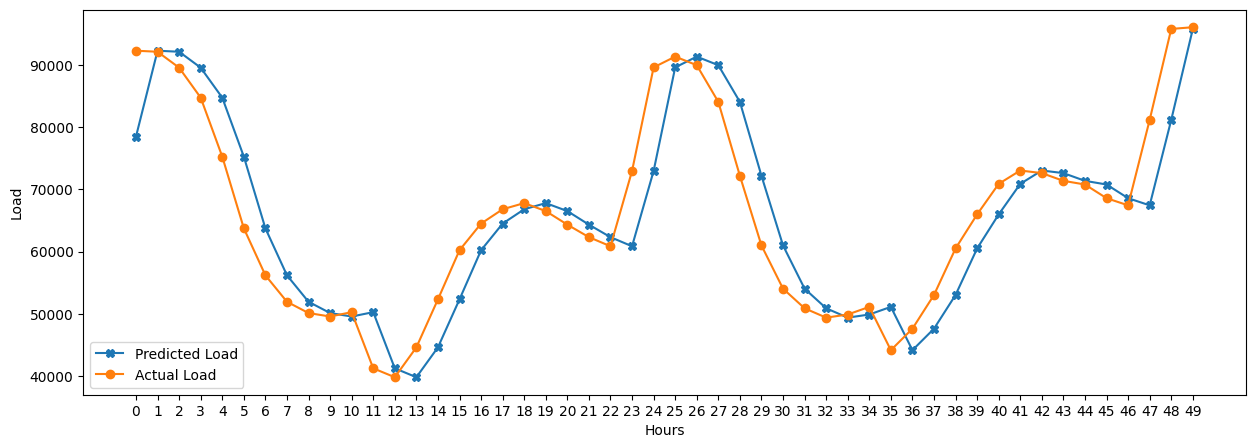

In [ ]:
# FOLD 1
results = evaluate_persistence(test1)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2']))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")
plotForDay(50, results)


 MAE: 5275.94140625, MAPE: 6.696918606758118, RMSE: 6889.360492817893, R2: 0.8603836495022075


PREDICTIONS :  [[75171.9921875], [75811.25], [74429.5625], [73885.6484375], [76335.234375], [83418.8515625], [98243.1171875], [98816.859375], [95951.34375], [93815.4140625], [87918.2265625], [81258.4921875], [79420.4765625], [83243.03125], [71441.3515625], [58087.47265625], [46931.51171875], [45815.95703125], [48184.3984375], [53274.3125], [58424.4140625], [63464.16796875], [65953.2578125], [69949.890625], [74294.5859375], [74545.2890625], [74062.7109375], [74092.8125], [77058.5703125], [85568.8046875], [98451.3828125], [98899.34375], [95992.734375], [94743.421875], [88865.5546875], [81661.359375], [80089.9765625], [84502.7578125], [72661.6640625], [58861.015625], [47884.6875], [46246.40625], [48009.03125], [52762.6640625], [58858.5], [64137.21484375], [69733.5], [72679.546875], [74168.140625], [74890.1328125], [74781.953125], [74504.3046875], [76703.9140625], [85232.5625], [99691.8125], [1

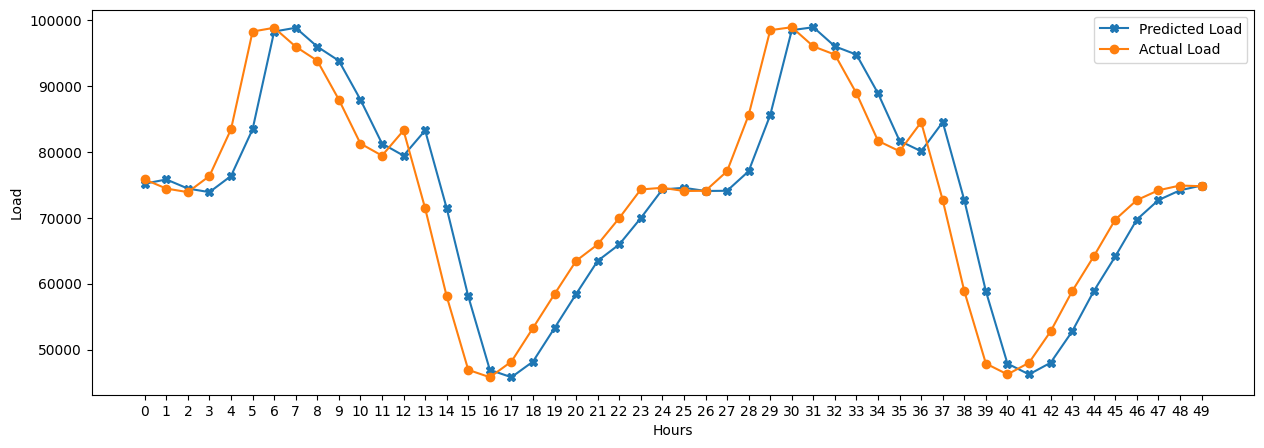

In [ ]:
# FOLD 2
results = evaluate_persistence(test2)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2']))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")
plotForDay(50, results)


 MAE: 4625.3173828125, MAPE: 6.321507692337036, RMSE: 6297.720540004931, R2: 0.8497163381654085


PREDICTIONS :  [[75993.828125], [84910.1328125], [91875.2890625], [96076.953125], [96331.1796875], [95990.84375], [94792.1953125], [92949.015625], [91852.7265625], [91100.4375], [92810.34375], [112485.0078125], [119843.6484375], [116493.921875], [110081.5859375], [100044.3984375], [88627.1640625], [79522.046875], [73566.015625], [70356.671875], [69407.515625], [59525.9609375], [57173.9140625], [63735.2109375], [73492.5703125], [82620.6328125], [88689.9765625], [92482.2578125], [94959.5], [95720.265625], [94081.171875], [92236.171875], [91214.59375], [91470.6953125], [94944.5], [116205.6875], [122397.7421875], [117985.0234375], [110849.828125], [101395.9140625], [91341.875], [81829.5234375], [74564.5], [71436.9453125], [67530.7890625], [58430.8125], [56149.44921875], [60819.53515625], [69089.453125], [76640.71875], [83259.078125], [87299.03125], [89852.1953125], [91011.9375], [89494.382812

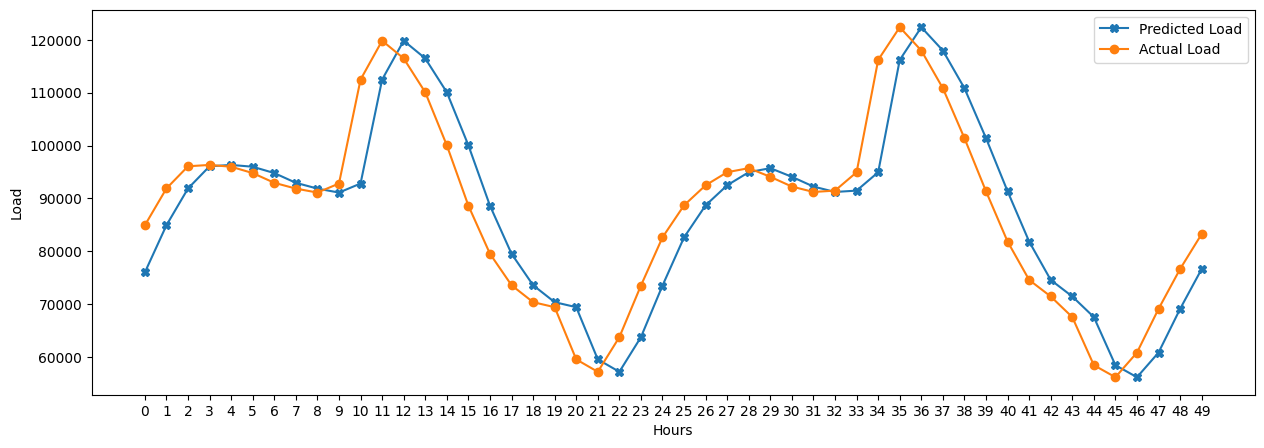

In [ ]:
# FOLD 3
results = evaluate_persistence(test3)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2']))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")
plotForDay(50, results)


 MAE: 4027.837158203125, MAPE: 6.232146546244621, RMSE: 5476.492308038057, R2: 0.8474517050638625


PREDICTIONS :  [[51815.50390625], [52431.93359375], [54926.28125], [52373.203125], [52355.6015625], [57684.05859375], [62928.5703125], [67596.796875], [70992.859375], [72073.4375], [71590.6015625], [71553.2265625], [69924.625], [68650.203125], [78459.546875], [94630.1796875], [94443.875], [91405.3046875], [84345.609375], [74373.2265625], [64537.48828125], [58105.1953125], [54209.609375], [52406.83203125], [51907.28125], [52293.1328125], [56223.8046875], [53408.2734375], [53649.87890625], [58872.796875], [63774.8046875], [68276.859375], [72248.671875], [73062.1796875], [72514.84375], [71711.546875], [69981.375], [69145.84375], [78731.0625], [94947.4609375], [94600.421875], [92381.03125], [85823.8125], [75361.9921875], [65971.921875], [58189.48046875], [53606.25], [51645.48828125], [50803.54296875], [51722.32421875], [55918.51953125], [53574.73828125], [53978.6015625], [59341.26953125], [

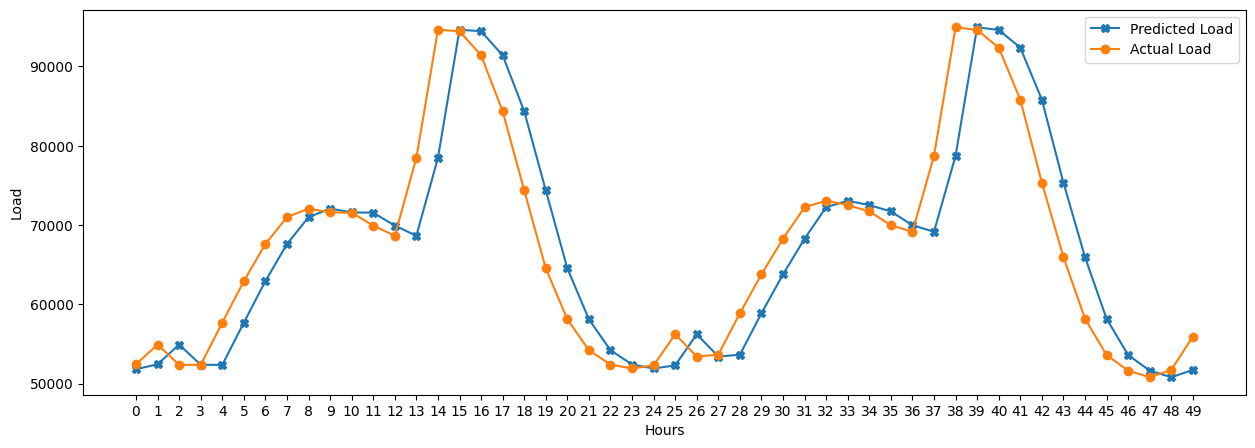

In [ ]:
# FOLD 4
results = evaluate_persistence(test4)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2']))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")
plotForDay(50, results)

# 2. ANN



In [ ]:
def build_ANN(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_x_hum, train_x_wind, train_x_gdf, train_x_df, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_x_hum = scaler_hum.fit_transform(train_x_hum.reshape(train_x_hum.shape[0]*train_x_hum.shape[1],train_x_hum.shape[2])).reshape(-1,lookback,1)
    train_x_wind = scaler_wind.fit_transform(train_x_wind.reshape(train_x_wind.shape[0]*train_x_wind.shape[1],train_x_wind.shape[2])).reshape(-1,lookback,1)
    train_x_gdf = scaler_gdf.fit_transform(train_x_gdf.reshape(train_x_gdf.shape[0]*train_x_gdf.shape[1],train_x_gdf.shape[2])).reshape(-1,lookback,1)
    train_x_df = scaler_df.fit_transform(train_x_df.reshape(train_x_df.shape[0]*train_x_df.shape[1],train_x_df.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)
    train_x = np.concatenate((train_x_load,train_x_temp,train_x_hum,train_x_wind,train_x_gdf,train_x_df),axis=2)
    # define model
    inputs = layers.Input(shape=(train_x.shape[1], train_x.shape[2]))
    n_outputs = train_y.shape[1]
    print("Inputs: {}\nOutput: {}\n".format(inputs.shape,train_y.shape))

    x = layers.Flatten()(inputs)
    print("Flatten :",x.shape)
    x = layers.Dense(200, activation="relu")(x)
    print("Dense :",x.shape)
    x = layers.Dense(100, activation="relu")(x)
    print("Dense :",x.shape)
    x = layers.Dense(24, activation="relu")(x)
    print("Dense :",x.shape)
    x = layers.Dense(1)(x)
    print("Output :",x.shape)
    model = Model(inputs=inputs, outputs=x, name="ANN")
    model.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    history = model.fit(train_x, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    return model, history.history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df

# load and temp combined for ANN [flatten as first layers of the model]
def evaluate_ann(model, test, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df):
    test_x_load, test_x_temp, test_x_hum, test_x_wind, test_x_gdf, test_x_df, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x_hum = scaler_hum.transform(test_x_hum.reshape(test_x_hum.shape[0]*test_x_hum.shape[1],test_x_hum.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x_wind = scaler_wind.transform(test_x_wind.reshape(test_x_wind.shape[0]*test_x_wind.shape[1],test_x_wind.shape[2])).reshape(-1,lookback,1)
    test_x_gdf = scaler_gdf.transform(test_x_gdf.reshape(test_x_gdf.shape[0]*test_x_gdf.shape[1],test_x_gdf.shape[2])).reshape(-1,lookback,1)
    test_x_df = scaler_df.transform(test_x_df.reshape(test_x_df.shape[0]*test_x_df.shape[1],test_x_df.shape[2])).reshape(-1,lookback,1)
    test_x = np.concatenate((test_x_load,test_x_temp,test_x_hum,test_x_wind,test_x_gdf,test_x_df),axis=2)
    yhat = model.predict(test_x)
    yhat = scaler_load.inverse_transform(yhat.reshape(-1, 1))
    print(yhat.shape)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Running Time
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_ANN(train1, lookback, lookahead)


Inputs: (None, 96, 6)
Output: (1651, 1, 1)

Flatten : (None, 576)
Dense : (None, 200)
Dense : (None, 100)
Dense : (None, 24)
Output : (None, 1)
21/21 [==============================] - 1s 11ms/step - loss: 0.0653 - val_loss: 0.0157 - lr: 0.0010
Convergence time is : 00:00:01


Inputs: (None, 96, 6)
Output: (1651, 1, 1)

Flatten : (None, 576)
Dense100 : (None, 200)
Dense50 : (None, 100)
Dense50 : (None, 24)
Output : (None, 1)
Convergence time is : 00:00:09


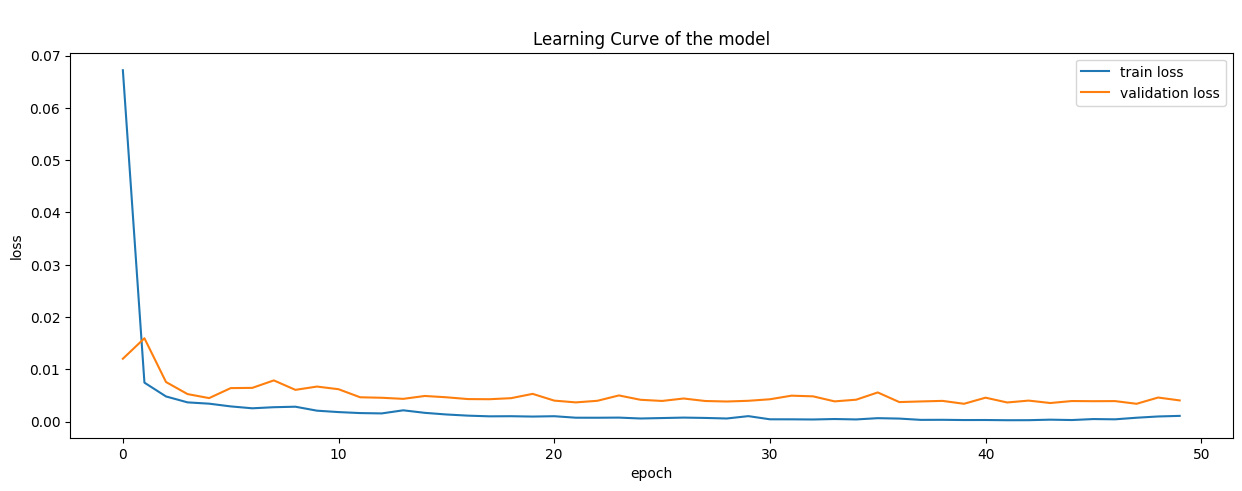

52/52 [==============================] - 0s 2ms/step
(1651, 1)

 MAE: 5781.400390625, MAPE: 8.241177350282669, RMSE: 7227.939678774304, R2: 0.7419992104671982, T-time: 00:00:09


 Training time 00:00:09

PREDICTIONS :  [[89436.40625], [87690.203125], [85610.015625], [78156.515625], [69664.46875], [59966.64453125], [55073.87109375], [51949.39453125], [51016.67578125], [51969.43359375], [52435.1640625], [51640.953125], [46248.8359375], [48395.7421875], [54902.86328125], [61293.515625], [67296.5546875], [72778.2421875], [75136.4765625], [73553.28125], [71363.1015625], [69778.3515625], [72705.0625], [79534.96875], [85529.0234375], [84821.5234375], [82826.40625], [76930.8359375], [67515.515625], [57905.9453125], [53454.55859375], [52157.02734375], [50189.4609375], [50067.71484375], [50150.11328125], [46613.1484375], [43817.25390625], [48310.05859375], [56941.32421875], [67105.921875], [72912.265625], [75900.1328125], [77062.796875], [76825.5], [73352.796875], [71696.3125], [76409.65625], [8

In [ ]:
# FOLD 1
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_ANN(train1, lookback, lookahead)
plot_history(history)
results = evaluate_ann(model, test1, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 6)
Output: (3398, 1, 1)

Flatten : (None, 576)
Dense100 : (None, 200)
Dense50 : (None, 100)
Dense50 : (None, 24)
Output : (None, 1)
Convergence time is : 00:00:16


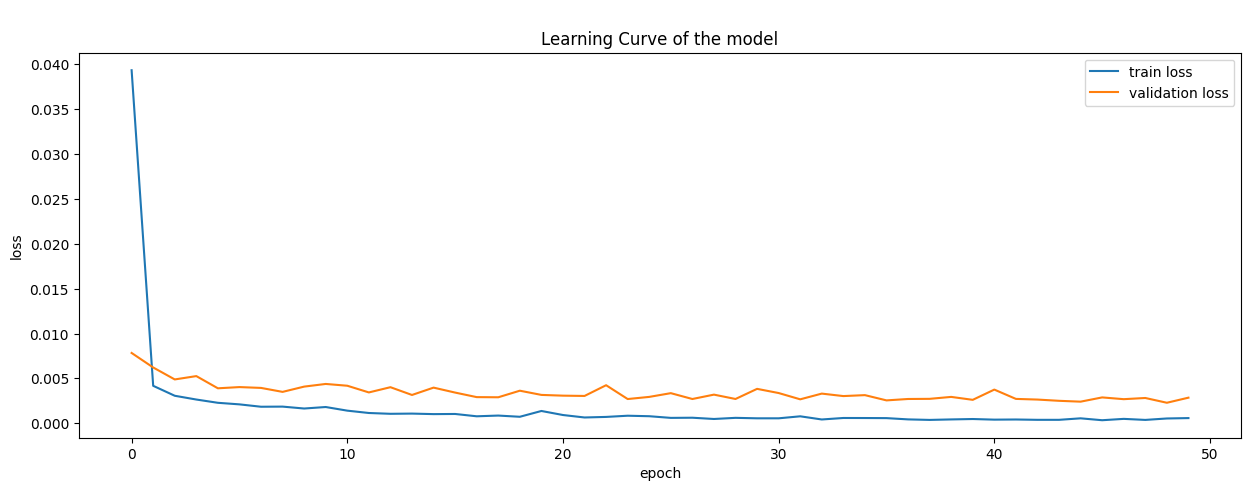

52/52 [==============================] - 0s 2ms/step
(1651, 1)

 MAE: 9188.1123046875, MAPE: 11.061514168977737, RMSE: 11152.05738866152, R2: 0.6341622913671041, T-time: 00:00:16


 Training time 00:00:16

PREDICTIONS :  [[74486.6953125], [74924.4765625], [76304.328125], [78244.6953125], [86725.03125], [97435.3984375], [98306.703125], [96114.4375], [93058.2421875], [85657.6640625], [74006.2890625], [63045.453125], [59401.7421875], [55025.98046875], [51433.203125], [48853.9765625], [45557.09375], [47850.5078125], [50486.64453125], [56881.23828125], [61215.49609375], [65783.9375], [67986.7421875], [70792.03125], [71556.1171875], [72159.2421875], [75905.8828125], [79888.234375], [93318.140625], [96033.546875], [96559.5859375], [95351.875], [93013.921875], [86888.4296875], [72572.6015625], [62758.30859375], [57611.41796875], [52088.55859375], [48763.15234375], [47232.71484375], [45802.91015625], [48121.765625], [50644.36328125], [57352.7734375], [63604.05859375], [68022.4375], [67494.99218

In [ ]:
# FOLD 2
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_ANN(train2, lookback, lookahead)
plot_history(history)
results = evaluate_ann(model, test2, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 6)
Output: (5145, 1, 1)

Flatten : (None, 576)
Dense100 : (None, 200)
Dense50 : (None, 100)
Dense50 : (None, 24)
Output : (None, 1)
Epoch 38: early stopping
Convergence time is : 00:00:20


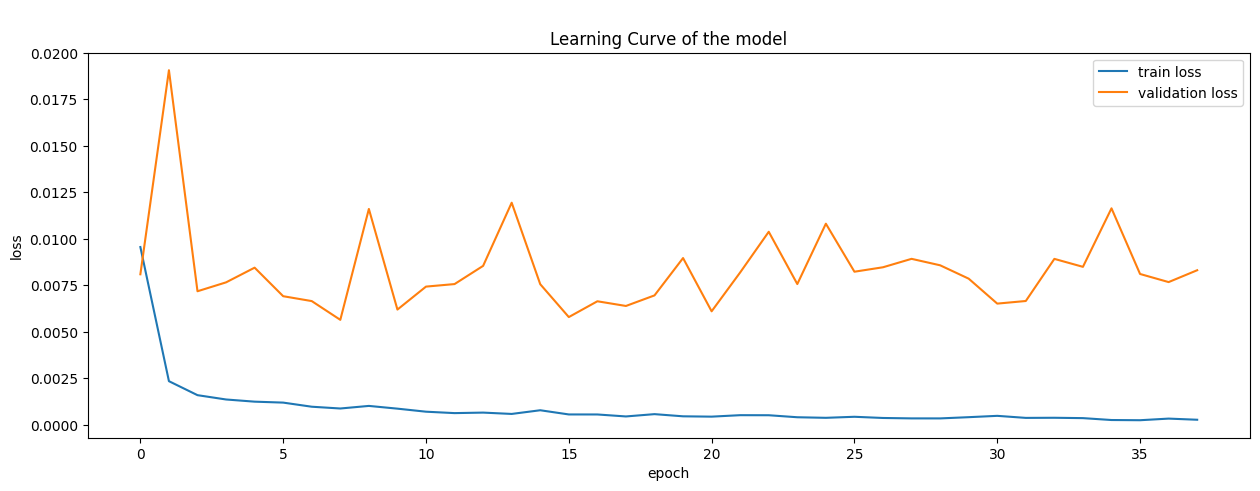

52/52 [==============================] - 0s 2ms/step
(1651, 1)

 MAE: 4839.15380859375, MAPE: 6.635110825300217, RMSE: 6928.6362294466, R2: 0.8180967330374722, T-time: 00:00:20


 Training time 00:00:20

PREDICTIONS :  [[55180.59375], [66348.734375], [75551.375], [81170.6015625], [82786.9921875], [82204.578125], [80895.5078125], [80812.7890625], [82034.5703125], [98175.703125], [112110.328125], [111591.2890625], [107952.265625], [102303.5390625], [95351.9296875], [87306.0859375], [79321.34375], [72598.8046875], [67293.265625], [61399.91015625], [52518.26171875], [47743.09765625], [43897.62890625], [47854.7265625], [56208.9375], [67439.2421875], [76280.7109375], [79283.359375], [80654.4375], [80500.1484375], [81389.4921875], [82231.4140625], [83459.5859375], [98087.3359375], [109248.453125], [110569.0], [107191.5625], [101465.4609375], [92918.78125], [85275.40625], [77243.34375], [68636.90625], [64626.17578125], [59835.390625], [52745.421875], [48031.78515625], [44804.74609375], [47263.

In [ ]:
# FOLD 3
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_ANN(train3, lookback, lookahead)
plot_history(history)
results = evaluate_ann(model, test3, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 6)
Output: (6892, 1, 1)

Flatten : (None, 576)
Dense100 : (None, 200)
Dense50 : (None, 100)
Dense50 : (None, 24)
Output : (None, 1)
Convergence time is : 00:00:31


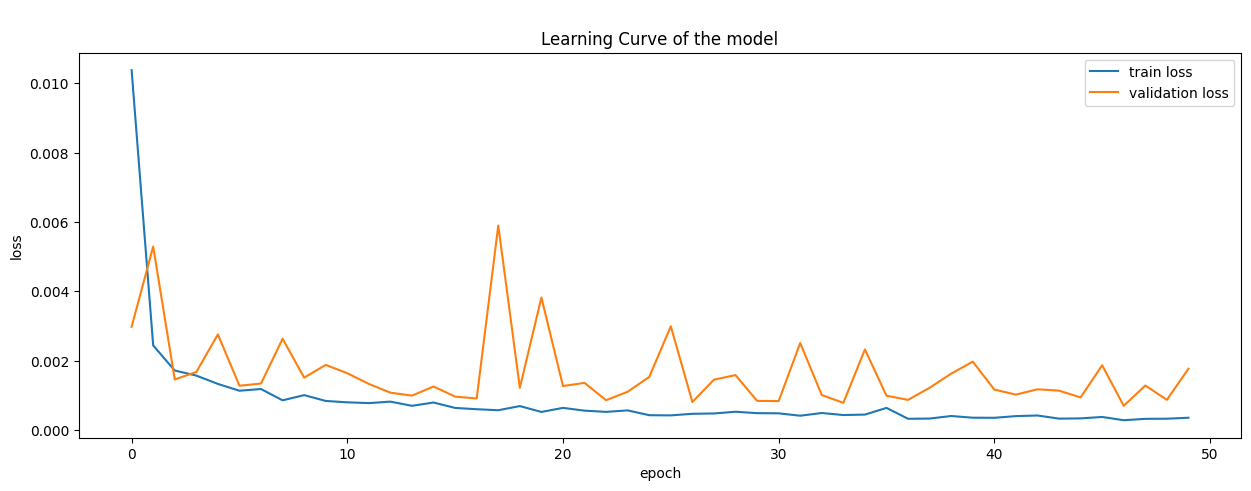

52/52 [==============================] - 0s 2ms/step
(1652, 1)

 MAE: 3075.25, MAPE: 5.049191415309906, RMSE: 3845.1334177112763, R2: 0.9247987175166001, T-time: 00:00:31


 Training time 00:00:31

PREDICTIONS :  [[52347.80078125], [52408.69140625], [48240.01953125], [42656.80078125], [44762.2109375], [51268.22265625], [57406.34765625], [60762.9140625], [62685.7734375], [62446.6171875], [61586.0078125], [60007.98046875], [60348.546875], [69489.3828125], [84347.46875], [87570.03125], [87123.0546875], [82772.5390625], [72447.7265625], [61215.62109375], [52865.18359375], [49427.71875], [49144.90625], [49239.796875], [49834.53125], [50114.48828125], [48687.8125], [44804.25], [50120.7265625], [56198.87109375], [61334.546875], [64073.3515625], [64942.875], [65291.59765625], [64725.8515625], [63001.5234375], [62514.6328125], [72930.1328125], [86043.09375], [89166.6796875], [88459.9453125], [83375.6484375], [73498.9609375], [62308.54296875], [54146.16015625], [50115.578125], [49536.6015625], [

In [ ]:
# FOLD 4
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_ANN(train4, lookback, lookahead)
plot_history(history)
results = evaluate_ann(model, test4, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# 3. CNNLSTM

In [ ]:
def build_CNNLSTM(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_x_hum, train_x_wind, train_x_gdf, train_x_df, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_x_hum = scaler_hum.fit_transform(train_x_hum.reshape(train_x_hum.shape[0]*train_x_hum.shape[1],train_x_hum.shape[2])).reshape(-1,lookback,1)
    train_x_wind = scaler_wind.fit_transform(train_x_wind.reshape(train_x_wind.shape[0]*train_x_wind.shape[1],train_x_wind.shape[2])).reshape(-1,lookback,1)
    train_x_gdf = scaler_gdf.fit_transform(train_x_gdf.reshape(train_x_gdf.shape[0]*train_x_gdf.shape[1],train_x_gdf.shape[2])).reshape(-1,lookback,1)
    train_x_df = scaler_df.fit_transform(train_x_df.reshape(train_x_df.shape[0]*train_x_df.shape[1],train_x_df.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    train_x = np.concatenate((train_x_load,train_x_temp,train_x_hum,train_x_wind,train_x_gdf,train_x_df),axis=2)
    inputs = layers.Input(shape=(train_x.shape[1], train_x.shape[2]))
    n_outputs = train_y.shape[1]
    # define model
    print("Input : {}".format(inputs.shape))
    # ENCODER
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same")(inputs)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    print("Conv1D : {}".format(x.shape))
    x = layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    print("Conv1D : {}".format(x.shape))
    x = layers.LSTM(64, return_sequences=False)(x)
    print("LSTM :",x.shape)
    x = layers.Dense(48)(x)
    x = layers.Activation("relu")(x)
    print("Dense : ",x.shape)
    x = layers.Dense(1)(x)
    print("outputs :",x.shape)
    model = Model(inputs=inputs, outputs=x, name="CNNLSTM")
    model.compile(loss='mse', optimizer='adam')
    # fit network
    start_time = time.time()
    history = model.fit(train_x, train_y, validation_split = 0.2,
                        epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    return model, history.history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df

# load and temp combined for ANN [flatten as first layers of the model]
def eval_CNNLSTM(model, test, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df):
    test_x_load, test_x_temp, test_x_hum, test_x_wind, test_x_gdf, test_x_df, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x_hum = scaler_hum.transform(test_x_hum.reshape(test_x_hum.shape[0]*test_x_hum.shape[1],test_x_hum.shape[2])).reshape(-1,lookback,1)
    test_x_wind = scaler_wind.transform(test_x_wind.reshape(test_x_wind.shape[0]*test_x_wind.shape[1],test_x_wind.shape[2])).reshape(-1,lookback,1)
    test_x_gdf = scaler_gdf.transform(test_x_gdf.reshape(test_x_gdf.shape[0]*test_x_gdf.shape[1],test_x_gdf.shape[2])).reshape(-1,lookback,1)
    test_x_df = scaler_df.transform(test_x_df.reshape(test_x_df.shape[0]*test_x_df.shape[1],test_x_df.shape[2])).reshape(-1,lookback,1)
    test_x = np.concatenate((test_x_load,test_x_temp,test_x_hum,test_x_wind,test_x_gdf,test_x_df),axis=2)
    yhat = model.predict(test_x)
    yhat = scaler_load.inverse_transform(yhat.reshape(-1, 1))
    print(yhat.shape)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Running Time
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_CNNLSTM(train1, lookback, lookahead)

Input : (None, 96, 6)
Conv1D : (None, 48, 32)
Conv1D : (None, 24, 64)
LSTM : (None, 64)
Dense :  (None, 48)
outputs : (None, 1)
21/21 [==============================] - 6s 31ms/step - loss: 0.0930 - val_loss: 0.0536 - lr: 0.0010
Convergence time is : 00:00:06


Input : (None, 96, 6)
Conv1D(32) : (None, 48, 32)
Conv1D(64) : (None, 24, 64)
LSTM1 : (None, 64)
Dense :  (None, 48)
outputs : (None, 1)
Convergence time is : 00:00:18


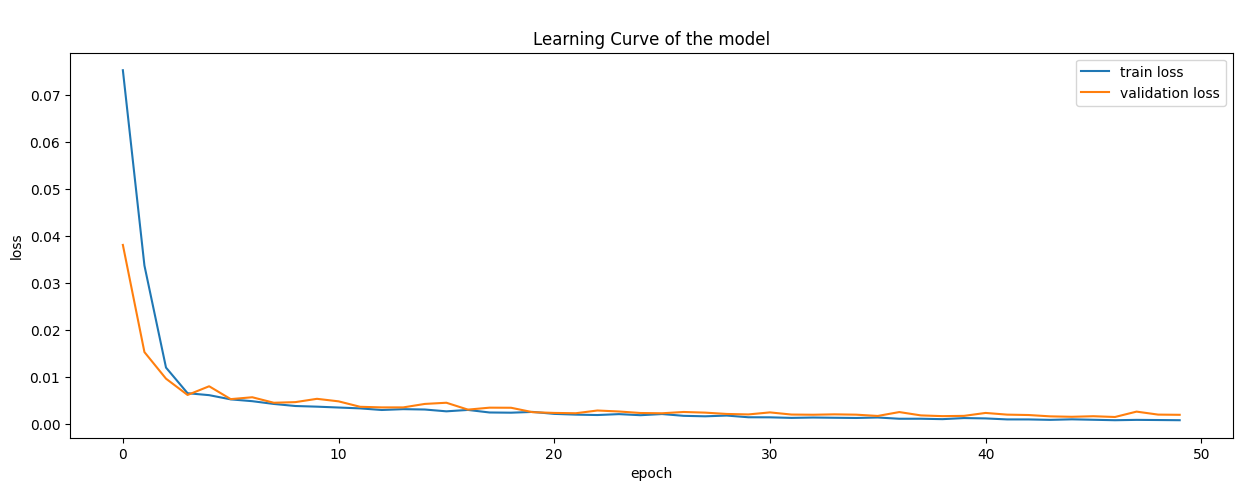

52/52 [==============================] - 1s 3ms/step
(1651, 1)

 MAE: 2954.170166015625, MAPE: 4.593054950237274, RMSE: 3779.530129526685, R2: 0.9294547781237309, T-time: 00:00:18


 Training time 00:00:18

PREDICTIONS :  [[88087.2265625], [91396.2109375], [90844.0625], [83290.546875], [74489.296875], [64458.953125], [55437.05078125], [50449.15625], [48726.859375], [47962.3125], [48113.08984375], [47383.26953125], [43280.4921875], [43889.34765625], [48732.91796875], [56036.359375], [63724.22265625], [67578.234375], [69401.0546875], [69975.703125], [67097.6171875], [66808.0625], [67760.125], [72692.7421875], [84241.0703125], [90472.0859375], [90641.4140625], [84300.5546875], [72726.65625], [62254.70703125], [54074.4609375], [49479.50390625], [47958.44140625], [48240.05078125], [48182.4375], [48109.8359375], [44508.671875], [48774.80859375], [56350.3671875], [64594.9375], [70846.6484375], [73623.890625], [73418.0390625], [74529.5078125], [72631.75], [71884.828125], [71831.4140625], [8211

In [ ]:
# Fold 1
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_CNNLSTM(train1, lookback, lookahead)
plot_history(history)
results = eval_CNNLSTM(model, test1, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Input : (None, 96, 6)
Conv1D(32) : (None, 48, 32)
Conv1D(64) : (None, 24, 64)
LSTM1 : (None, 64)
Dense :  (None, 48)
outputs : (None, 1)
Convergence time is : 00:00:43


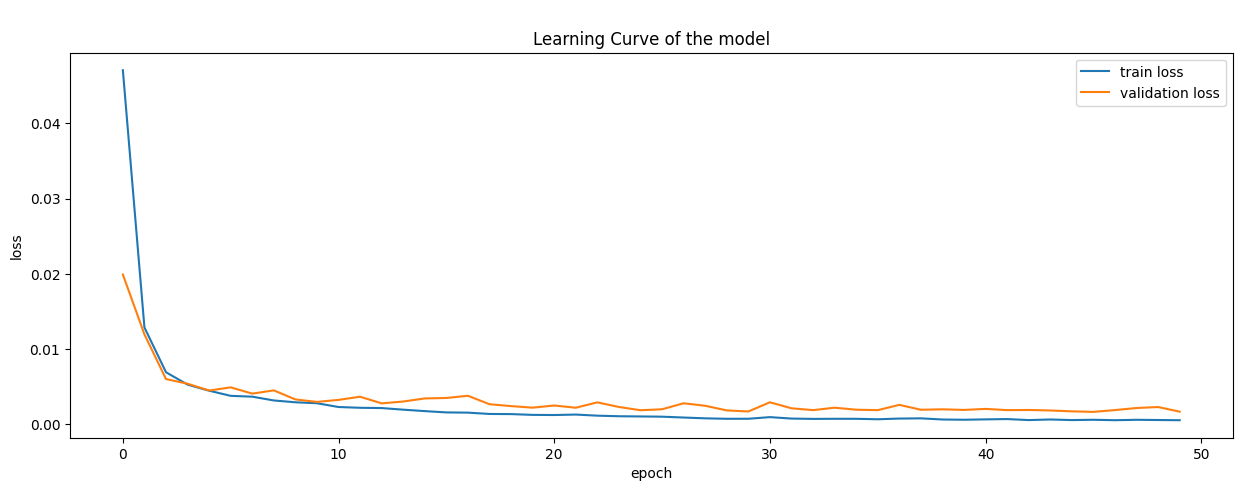

52/52 [==============================] - 1s 3ms/step
(1651, 1)

 MAE: 6760.2490234375, MAPE: 8.10655951499939, RMSE: 8147.91801627876, R2: 0.8047137073696906, T-time: 00:00:43


 Training time 00:00:43

PREDICTIONS :  [[72490.40625], [71990.375], [70023.1171875], [72033.3203125], [81589.6875], [96223.3984375], [100031.234375], [98754.8515625], [91890.2734375], [85320.3984375], [77374.9296875], [69522.1328125], [69652.75], [75576.03125], [62653.65234375], [53045.92578125], [48918.2578125], [51414.90625], [54983.609375], [55566.73828125], [57746.05078125], [64721.3125], [68960.3671875], [71763.1640625], [72352.375], [71025.6875], [69620.4453125], [71747.28125], [83788.234375], [97103.0703125], [98679.9453125], [97622.671875], [92370.4453125], [84955.109375], [79111.875], [69197.125], [70767.0], [74496.625], [63982.22265625], [51032.09375], [48058.5234375], [49406.6015625], [51934.3515625], [52099.78125], [61049.546875], [66524.796875], [71925.84375], [72540.1328125], [72697.890625], [736

In [ ]:
# Fold 2
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_CNNLSTM(train2, lookback, lookahead)
plot_history(history)
results = eval_CNNLSTM(model, test2, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Input : (None, 96, 6)
Conv1D(32) : (None, 48, 32)
Conv1D(64) : (None, 24, 64)
LSTM1 : (None, 64)
Dense :  (None, 48)
outputs : (None, 1)
Convergence time is : 00:01:24


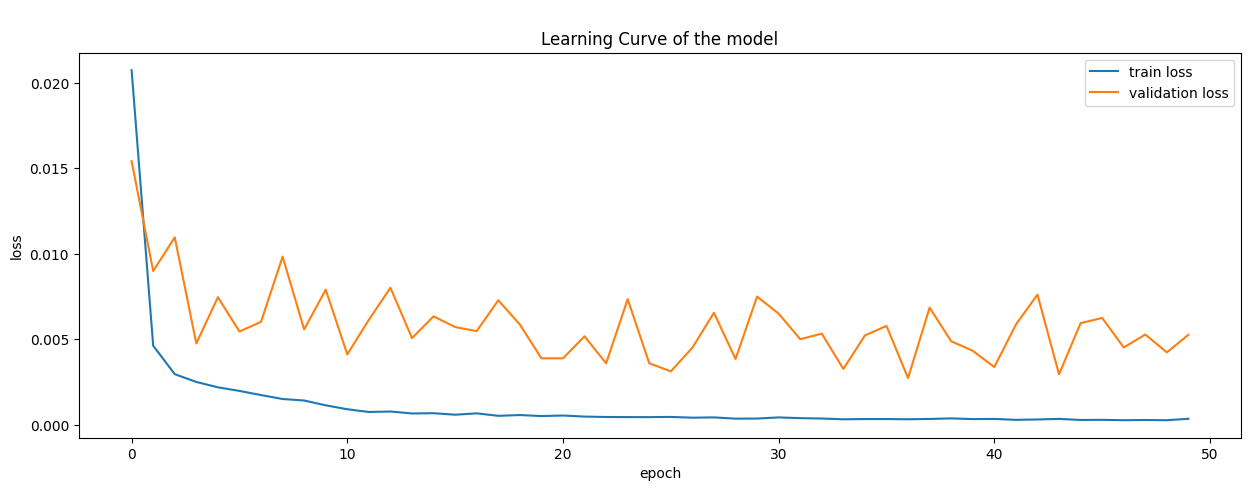

52/52 [==============================] - 0s 3ms/step
(1651, 1)

 MAE: 2809.145751953125, MAPE: 3.828422725200653, RMSE: 3829.367180096471, R2: 0.9444352925363764, T-time: 00:01:24


 Training time 00:01:24

PREDICTIONS :  [[73313.34375], [80162.9140625], [85269.015625], [88211.53125], [88815.7421875], [90202.109375], [90891.3671875], [90275.8203125], [90574.859375], [100462.71875], [110310.96875], [111121.0], [109046.9140625], [106432.5390625], [101365.1875], [93018.328125], [82789.796875], [78259.3984375], [70726.7265625], [63818.46875], [62066.37890625], [56568.375], [57949.6640625], [65858.7421875], [72678.875], [80016.0703125], [84446.7109375], [85052.921875], [86503.8515625], [87076.421875], [87897.6953125], [87080.2421875], [87464.7421875], [101745.7421875], [109749.84375], [111476.015625], [108976.703125], [106482.5859375], [100573.6796875], [91194.7265625], [79475.734375], [74686.2265625], [67026.0390625], [61098.61328125], [57900.4453125], [53532.25390625], [53724.94140625], [

In [ ]:
# Fold 3
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_CNNLSTM(train3, lookback, lookahead)
plot_history(history)
results = eval_CNNLSTM(model, test3, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Input : (None, 96, 6)
Conv1D(32) : (None, 48, 32)
Conv1D(64) : (None, 24, 64)
LSTM1 : (None, 64)
Dense :  (None, 48)
outputs : (None, 1)
Convergence time is : 00:01:24


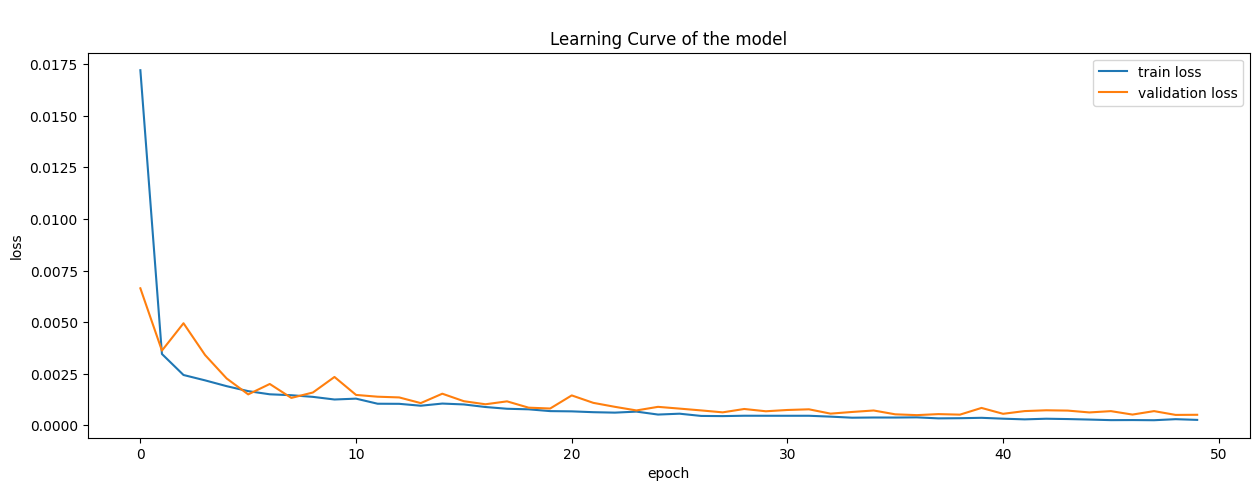

52/52 [==============================] - 0s 3ms/step
(1652, 1)

 MAE: 1414.9930419921875, MAPE: 2.226264961063862, RMSE: 1904.1992411509884, R2: 0.9815571874680572, T-time: 00:01:24


 Training time 00:01:24

PREDICTIONS :  [[51700.73046875], [53250.42578125], [53866.4921875], [53008.5390625], [55131.70703125], [63124.03125], [70039.53125], [71603.4921875], [72655.984375], [72364.7421875], [69908.203125], [69450.953125], [68169.4921875], [75245.421875], [92095.9609375], [95244.5234375], [90973.65625], [83573.015625], [73971.4765625], [66489.25], [59158.0546875], [55510.48046875], [51962.19140625], [50451.40234375], [51968.0078125], [53011.94921875], [55158.41796875], [52995.859375], [56711.8515625], [66414.9765625], [71278.734375], [72577.9296875], [72885.453125], [73250.328125], [70668.6015625], [69654.8984375], [68191.921875], [75525.578125], [93500.2109375], [95480.4140625], [92907.171875], [86254.3984375], [76317.484375], [67747.1640625], [61708.87109375], [56433.3984375], [52073.4

In [ ]:
# Fold 4
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_CNNLSTM(train4, lookback, lookahead)
plot_history(history)
results = eval_CNNLSTM(model, test4, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# 4. MSCNN (Multi-scale CNN)

In [ ]:
def build_MS_CNN(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_x_hum, train_x_wind, train_x_gdf, train_x_df, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_x_hum = scaler_hum.fit_transform(train_x_hum.reshape(train_x_hum.shape[0]*train_x_hum.shape[1],train_x_hum.shape[2])).reshape(-1,lookback,1)
    train_x_wind = scaler_wind.fit_transform(train_x_wind.reshape(train_x_wind.shape[0]*train_x_wind.shape[1],train_x_wind.shape[2])).reshape(-1,lookback,1)
    train_x_gdf = scaler_gdf.fit_transform(train_x_gdf.reshape(train_x_gdf.shape[0]*train_x_gdf.shape[1],train_x_gdf.shape[2])).reshape(-1,lookback,1)
    train_x_df = scaler_df.fit_transform(train_x_df.reshape(train_x_df.shape[0]*train_x_df.shape[1],train_x_df.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    train_x = np.concatenate((train_x_load,train_x_temp,train_x_hum,train_x_wind,train_x_gdf,train_x_df),axis=2)
    # define model
    inputs = layers.Input(shape=(train_x.shape[1], train_x.shape[2]))
    n_outputs = train_y.shape[1]
    print("Inputs: {}\nOutput: {}\n".format(inputs.shape,train_y.shape))

    print("BLOCK 1")
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1)(inputs)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 1", x.shape)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 2", x.shape)
    x = layers.Conv1D(filters=24, kernel_size=3, dilation_rate=4, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=4)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 3", x.shape)

    print("BLOCK 2")
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 1", x.shape)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 2", x.shape)
    x = layers.Conv1D(filters=24, kernel_size=3, dilation_rate=4, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=4)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 3", x.shape)

    print("BLOCK 3")
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 1", x.shape)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2, activation="relu")(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.05)(x)
    # x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2)(x)
    # x = layers.Activation('relu')(x)
    # x = layers.BatchNormalization()(x)
    print("conv1d 2", x.shape)
    x = layers.Conv1D(filters=24, kernel_size=3, dilation_rate=4, activation="relu")(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.05)(x)
    # x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=4)(x)
    # x = layers.Activation('relu')(x)
    # x = layers.BatchNormalization()(x)
    print("conv1d 3", x.shape)

    # print("BLOCK 4")
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1, activation="relu")(x)
    # # x = layers.BatchNormalization()(x)
    # # x = layers.Dropout(0.05)(x)
    # print("conv1d 1", x.shape)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2, activation="relu")(x)
    # # x = layers.BatchNormalization()(x)
    # # x = layers.Dropout(0.05)(x)
    # print("conv1d 2", x.shape)
    # x = layers.Conv1D(filters=24, kernel_size=3, dilation_rate=4, activation="relu")(x)
    # # x = layers.BatchNormalization()(x)
    # # x = layers.Dropout(0.05)(x)
    # print("conv1d 3", x.shape)

    x =layers.Flatten()(x)
    print("Flatten",x.shape)
    x = layers.Dense(24, activation="relu")(x)
    print("Dense ", x.shape)
    outputs = layers.Dense(1)(x)
    print("Output :",x.shape)
    model = Model(inputs=inputs, outputs=outputs, name="MS-CNN")
    model.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    history = model.fit(train_x, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    return model, history.history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df

def eval_MS_CNN(model, test, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df):
    test_x_load, test_x_temp, test_x_hum, test_x_wind, test_x_gdf, test_x_df, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x_hum = scaler_hum.transform(test_x_hum.reshape(test_x_hum.shape[0]*test_x_hum.shape[1],test_x_hum.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x_wind = scaler_wind.transform(test_x_wind.reshape(test_x_wind.shape[0]*test_x_wind.shape[1],test_x_wind.shape[2])).reshape(-1,lookback,1)
    test_x_gdf = scaler_gdf.transform(test_x_gdf.reshape(test_x_gdf.shape[0]*test_x_gdf.shape[1],test_x_gdf.shape[2])).reshape(-1,lookback,1)
    test_x_df = scaler_df.transform(test_x_df.reshape(test_x_df.shape[0]*test_x_df.shape[1],test_x_df.shape[2])).reshape(-1,lookback,1)
    test_x = np.concatenate((test_x_load,test_x_temp,test_x_hum,test_x_wind,test_x_gdf,test_x_df),axis=2)
    yhat = model.predict(test_x)
    yhat = scaler_load.inverse_transform(yhat.reshape(-1, 1))
    print(yhat.shape)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Running Time
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_MS_CNN(train1, lookback, lookahead)

Inputs: (None, 96, 6)
Output: (1651, 1, 1)

BLOCK 1
conv1d 1 (None, 92, 24)
conv1d 2 (None, 76, 24)
conv1d 3 (None, 52, 24)
BLOCK 2
conv1d 1 (None, 88, 24)
conv1d 2 (None, 72, 24)
conv1d 3 (None, 48, 24)
BLOCK 3
conv1d 1 (None, 40, 24)
conv1d 2 (None, 32, 24)
conv1d 3 (None, 24, 24)
Flatten (None, 288)
Dense  (None, 24)
Output : (None, 24)
21/21 [==============================] - 9s 38ms/step - loss: 0.1045 - val_loss: 0.1908 - lr: 0.0010
Convergence time is : 00:00:09


Inputs: (None, 96, 6)
Output: (1651, 1, 1)

BLOCK 1
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
BLOCK 2
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
Flatten (None, 1824)
Dense  (None, 24)
Output : (None, 24)
Epoch 1/50
42/42 [==============================] - 2s 10ms/step - loss: 0.0319 - val_loss: 0.0099 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0082 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0094 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0056 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0046 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0063 - lr: 0.0010
Epoch 7/50
42/42 [==============================] - 0s 6ms/step - loss

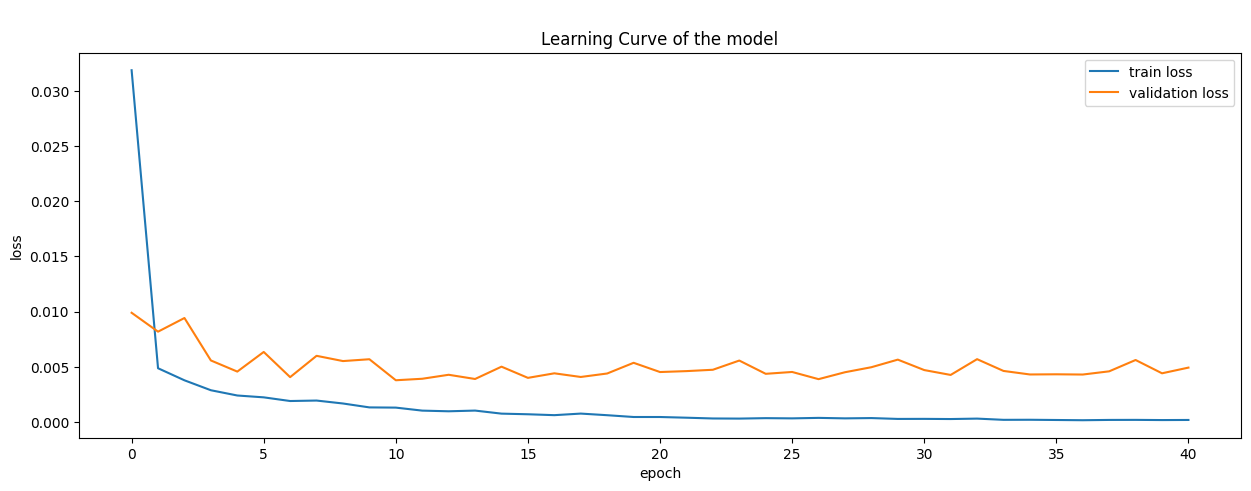

52/52 [==============================] - 0s 3ms/step
(1651, 1)

 MAE: 5901.97216796875, MAPE: 9.110303223133087, RMSE: 7221.737187131639, R2: 0.7424418163843787, T-time: 00:00:12


 Training time 00:00:12

PREDICTIONS :  [[86637.3515625], [85947.2890625], [83025.796875], [76702.0078125], [70399.3515625], [64624.53125], [61292.19921875], [57706.16796875], [55293.43359375], [55636.6328125], [54534.8125], [53432.08203125], [52868.78125], [54378.61328125], [60022.02734375], [64727.234375], [68191.7734375], [68194.5859375], [69102.3359375], [67624.78125], [67506.2734375], [68736.328125], [69884.7421875], [77058.8828125], [82088.75], [82914.171875], [81519.3984375], [77756.5078125], [72068.015625], [63885.08984375], [61892.578125], [58642.796875], [57036.38671875], [56738.5859375], [55627.4140625], [55134.1875], [53536.75390625], [54466.0546875], [59125.65625], [63168.56640625], [64817.6015625], [65004.6171875], [67373.9375], [66193.046875], [66771.828125], [68060.2578125], [68881.90625], [7

In [ ]:
# Fold 1
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_MS_CNN(train1, lookback, lookahead)
plot_history(history)
results = eval_MS_CNN(model, test1, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 6)
Output: (3398, 1, 1)

BLOCK 1
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
BLOCK 2
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
Flatten (None, 1824)
Dense  (None, 24)
Output : (None, 24)
Epoch 1/50
85/85 [==============================] - 4s 14ms/step - loss: 0.0133 - val_loss: 0.0087 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 1s 11ms/step - loss: 0.0037 - val_loss: 0.0057 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 1s 11ms/step - loss: 0.0028 - val_loss: 0.0043 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0047 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0043 - lr: 0.0010
Epoch 6/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0040 - lr: 0.0010
Epoch 7/50
85/85 [==============================] - 0s 5ms/step - lo

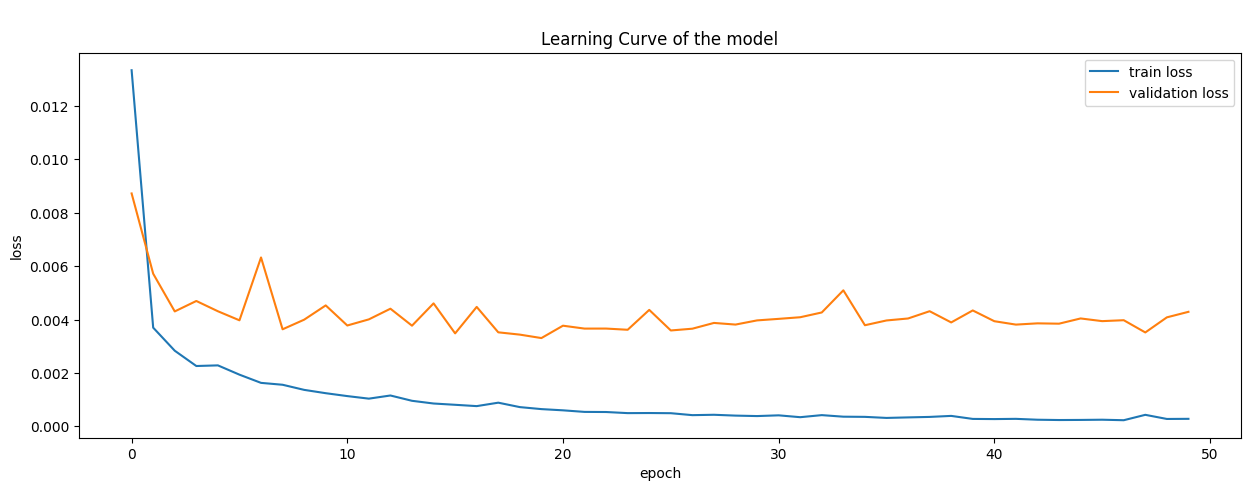

52/52 [==============================] - 0s 2ms/step
(1651, 1)

 MAE: 9644.4765625, MAPE: 11.264011263847351, RMSE: 11462.388930759591, R2: 0.6135184098814184, T-time: 00:00:28


 Training time 00:00:28

PREDICTIONS :  [[74394.4375], [75793.921875], [78277.9765625], [79206.453125], [83904.8671875], [92107.0859375], [90759.2421875], [88743.6328125], [87380.0703125], [83420.6640625], [77033.9453125], [69088.8203125], [62130.17578125], [56712.8828125], [54932.48828125], [53615.1875], [52562.8359375], [50771.796875], [51870.75], [55816.90625], [60266.4296875], [66114.4140625], [69750.2734375], [72322.3828125], [74199.921875], [74710.3125], [75757.890625], [78017.34375], [83009.625], [91258.640625], [89790.7734375], [87234.7890625], [85833.09375], [81925.1015625], [75762.7734375], [68040.6796875], [59661.48046875], [54518.578125], [53723.375], [50956.5234375], [46247.9140625], [45167.91796875], [47701.72265625], [50604.71875], [56801.69140625], [62514.515625], [64222.515625], [66387.796875]

In [ ]:
# Fold 2
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_MS_CNN(train2, lookback, lookahead)
plot_history(history)
results = eval_MS_CNN(model, test2, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 6)
Output: (5145, 1, 1)

BLOCK 1
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
BLOCK 2
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
Flatten (None, 1824)
Dense  (None, 24)
Output : (None, 24)
Epoch 1/50
129/129 [==============================] - 3s 8ms/step - loss: 0.0085 - val_loss: 0.0197 - lr: 0.0010
Epoch 2/50
129/129 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 0.0095 - lr: 0.0010
Epoch 3/50
129/129 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0180 - lr: 0.0010
Epoch 4/50
129/129 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0202 - lr: 0.0010
Epoch 5/50
129/129 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 0.0178 - lr: 0.0010
Epoch 6/50
129/129 [==============================] - 1s 5ms/step - loss: 9.8841e-04 - val_loss: 0.0160 - lr: 0.0010
Epoch 7/50
129/129 [==============================] - 1

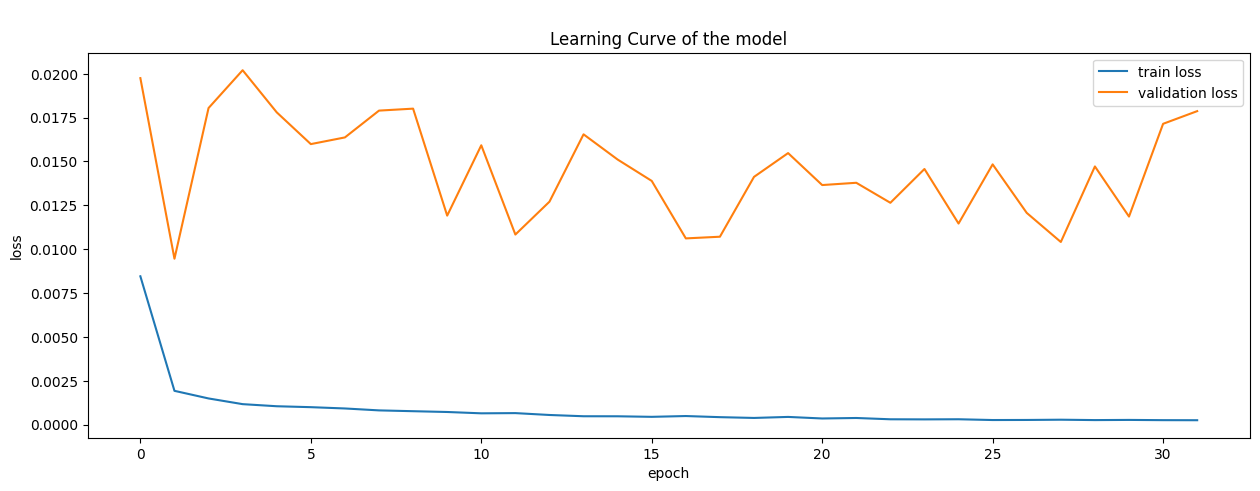

52/52 [==============================] - 0s 3ms/step
(1651, 1)

 MAE: 6614.5234375, MAPE: 8.888445794582367, RMSE: 8694.473187030942, R2: 0.7135613951099302, T-time: 00:00:24


 Training time 00:00:24

PREDICTIONS :  [[60746.0546875], [68431.828125], [72516.21875], [76255.6484375], [77644.6796875], [77046.5390625], [75455.2421875], [76795.0], [81030.953125], [86367.359375], [94786.2890625], [101072.546875], [102655.8046875], [99273.28125], [91832.0703125], [85244.6484375], [79851.21875], [74585.46875], [69334.359375], [60446.3515625], [53558.94921875], [51963.34765625], [52211.64453125], [53756.5703125], [59199.4765625], [66101.8828125], [71695.1171875], [74278.3125], [75916.546875], [75364.671875], [75627.2890625], [78326.65625], [82174.21875], [85341.4921875], [95318.6796875], [100522.5703125], [101504.1171875], [98331.421875], [90960.1015625], [83464.453125], [76607.046875], [72047.4921875], [66333.6875], [58070.32421875], [51405.94921875], [48985.17578125], [49423.359375], [52855.6

In [ ]:
# Fold 3
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_MS_CNN(train3, lookback, lookahead)
plot_history(history)
results = eval_MS_CNN(model, test3, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 6)
Output: (6892, 1, 1)

BLOCK 1
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
BLOCK 2
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
Flatten (None, 1824)
Dense  (None, 24)
Output : (None, 24)
Epoch 1/50
173/173 [==============================] - 4s 7ms/step - loss: 0.0133 - val_loss: 0.0037 - lr: 0.0010
Epoch 2/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 0.0030 - lr: 0.0010
Epoch 3/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0018 - val_loss: 0.0039 - lr: 0.0010
Epoch 4/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 0.0049 - lr: 0.0010
Epoch 5/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 0.0034 - lr: 0.0010
Epoch 6/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0035 - lr: 0.0010
Epoch 7/50
173/173 [==============================] - 1s 5m

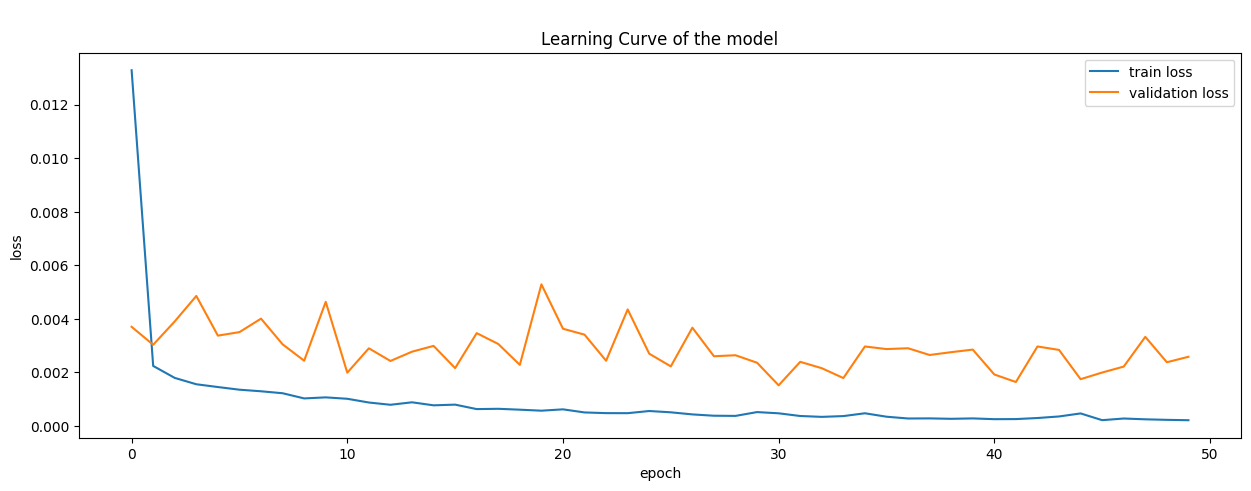

52/52 [==============================] - 0s 2ms/step
(1652, 1)

 MAE: 5346.38232421875, MAPE: 8.308389037847519, RMSE: 7108.999648333091, R2: 0.7429489464995496, T-time: 00:00:49


 Training time 00:00:49

PREDICTIONS :  [[47403.1015625], [48842.9375], [48303.0234375], [48015.84765625], [57521.21875], [67663.8671875], [73954.09375], [77210.6484375], [74967.265625], [72741.359375], [71498.484375], [73252.3515625], [77387.34375], [84823.1328125], [92182.640625], [95052.09375], [95030.3359375], [91110.53125], [82519.984375], [71562.046875], [63097.89453125], [56831.28515625], [52799.80859375], [51315.71484375], [50449.7265625], [52885.15234375], [51131.3671875], [52782.02734375], [60754.80078125], [69005.0859375], [73868.078125], [77200.5390625], [76707.0390625], [72872.53125], [73273.0078125], [75672.140625], [79105.0625], [85278.0234375], [89872.921875], [90789.9296875], [89306.640625], [84235.1484375], [76141.6328125], [66505.8125], [60947.69140625], [56470.6953125], [53828.9765625], [

In [ ]:
# Fold 4
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_MS_CNN(train4, lookback, lookahead)
plot_history(history)
results = eval_MS_CNN(model, test4, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# 5. DeepEnergy

In [ ]:
# train the model
def build_DeepEnergy(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_x_hum, train_x_wind, train_x_gdf, train_x_df, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_x_hum = scaler_hum.fit_transform(train_x_hum.reshape(train_x_hum.shape[0]*train_x_hum.shape[1],train_x_hum.shape[2])).reshape(-1,lookback,1)
    train_x_wind = scaler_wind.fit_transform(train_x_wind.reshape(train_x_wind.shape[0]*train_x_wind.shape[1],train_x_wind.shape[2])).reshape(-1,lookback,1)
    train_x_gdf = scaler_gdf.fit_transform(train_x_gdf.reshape(train_x_gdf.shape[0]*train_x_gdf.shape[1],train_x_gdf.shape[2])).reshape(-1,lookback,1)
    train_x_df = scaler_df.fit_transform(train_x_df.reshape(train_x_df.shape[0]*train_x_df.shape[1],train_x_df.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)
    train_x = np.concatenate((train_x_load,train_x_temp,train_x_hum,train_x_wind,train_x_gdf,train_x_df),axis=2)
    inputs = layers.Input(shape=(train_x.shape[1], train_x.shape[2]))
    n_outputs = train_y.shape[1]
    # define model

    # CONV => RELU => BatchNorm => POOL layer set
    x = layers.Conv1D(filters=64, kernel_size=5, padding="same")(inputs)
    print("Conv1D : {}".format(x.shape))
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    print("MaxPooling1D : {}".format(x.shape))
    # CONV => RELU => BatchNorm => POOL layer set
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same")(x)
    print("Conv1D : {}".format(x.shape))
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    print("MaxPooling1D : {}".format(x.shape))
    # CONV => RELU => BatchNorm => POOL layer set
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same")(x)
    print("Conv1D : {}".format(x.shape))
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    print("MaxPooling1D : {}".format(x.shape))
    # CONV => RELU => BatchNorm => POOL layer set
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same")(x)
    print("Conv1D : {}".format(x.shape))
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    print("MaxPooling1D : {}".format(x.shape))
    # Flatten
    x = layers.Flatten()(x)
    print("Flatten : {}".format(x.shape))
    # Set of FC => RELU => BatchNorm => Dropout => outputs
    x = layers.Dense(units = 32)(x)
    print("Dense : ",x.shape)
    x = layers.Activation("relu")(x)
    x = layers.Dense(1)(x)
    print("Dense : ",x.shape)

    model = Model(inputs=inputs, outputs=x, name="DeepEnergy")
    model.compile(loss='mse', optimizer='adam')
    # fit network
    start_time = time.time()
    history = model.fit(train_x, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    return model, history.history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df


def eval_DeepEnergy(model, test, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df):
    test_x_load, test_x_temp, test_x_hum, test_x_wind, test_x_gdf, test_x_df, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x_hum = scaler_hum.transform(test_x_hum.reshape(test_x_hum.shape[0]*test_x_hum.shape[1],test_x_hum.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x_wind = scaler_wind.transform(test_x_wind.reshape(test_x_wind.shape[0]*test_x_wind.shape[1],test_x_wind.shape[2])).reshape(-1,lookback,1)
    test_x_gdf = scaler_gdf.transform(test_x_gdf.reshape(test_x_gdf.shape[0]*test_x_gdf.shape[1],test_x_gdf.shape[2])).reshape(-1,lookback,1)
    test_x_df = scaler_df.transform(test_x_df.reshape(test_x_df.shape[0]*test_x_df.shape[1],test_x_df.shape[2])).reshape(-1,lookback,1)
    test_x = np.concatenate((test_x_load,test_x_temp,test_x_hum,test_x_wind,test_x_gdf,test_x_df),axis=2)
    yhat = model.predict(test_x)
    yhat = scaler_load.inverse_transform(yhat.reshape(-1, 1))
    print(yhat.shape)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Running Time
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_DeepEnergy(train1, lookback, lookahead)

Conv1D : (None, 96, 64)
MaxPooling1D : (None, 48, 64)
Conv1D : (None, 48, 32)
MaxPooling1D : (None, 24, 32)
Conv1D : (None, 24, 32)
MaxPooling1D : (None, 12, 32)
Conv1D : (None, 12, 32)
MaxPooling1D : (None, 6, 32)
Flatten : (None, 192)
Dense :  (None, 32)
Dense :  (None, 1)
21/21 [==============================] - 2s 16ms/step - loss: 0.0533 - val_loss: 0.0291 - lr: 0.0010
Convergence time is : 00:00:02


Epoch 1/50
42/42 [==============================] - 4s 19ms/step - loss: 0.0425 - val_loss: 0.0172 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0056 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0046 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0040 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0056 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0034 - lr: 0.0010
Epoch 7/50
42/42 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0030 - lr: 0.0010
Epoch 8/50
42/42 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0029 - lr: 0.0010
Epoch 9/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0029 - lr: 0.0010

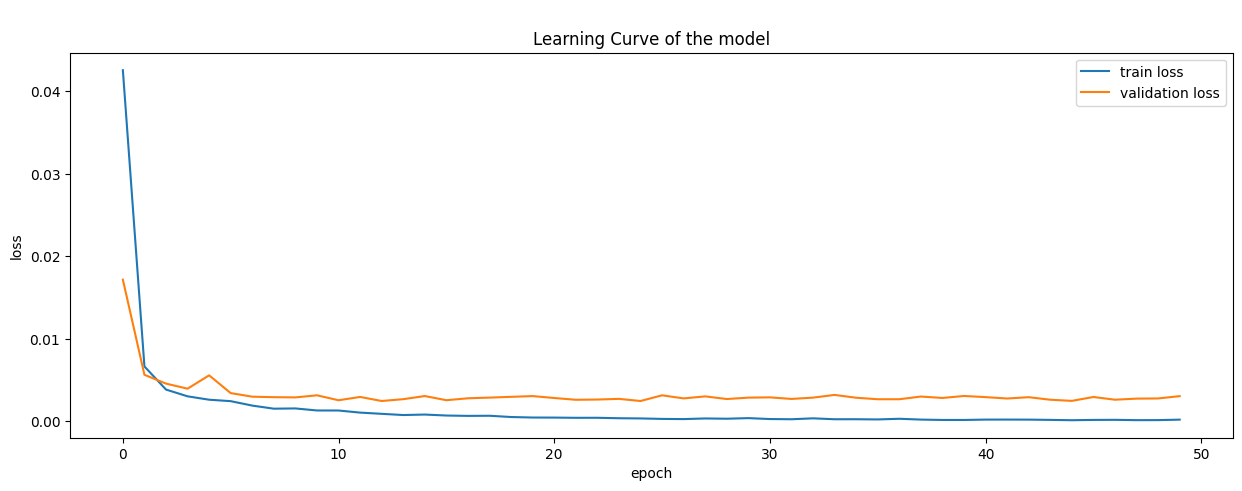

52/52 [==============================] - 0s 2ms/step
(1651, 1)

 MAE: 3929.608154296875, MAPE: 6.021921336650848, RMSE: 4825.309523750782, R2: 0.8850146855724451, T-time: 00:00:19


 Training time 00:00:19

PREDICTIONS :  [[89056.609375], [89883.4609375], [87930.109375], [82357.125], [76993.53125], [69169.8046875], [59775.37890625], [54284.98046875], [54233.53515625], [53692.93359375], [54553.8671875], [53960.66796875], [53823.89453125], [56889.58984375], [63491.64453125], [68976.109375], [71275.640625], [72712.9296875], [73947.7734375], [72442.5546875], [71018.921875], [66436.625], [69884.7578125], [79529.96875], [85206.7421875], [86918.75], [87522.7109375], [82621.625], [75278.5859375], [68190.2578125], [59169.46484375], [54346.35546875], [52090.55859375], [52628.3671875], [52006.62109375], [51036.36328125], [51481.828125], [55661.9921875], [64802.125], [70580.234375], [74857.8984375], [76604.5546875], [77752.40625], [75078.8046875], [74234.9921875], [72233.984375], [74805.7421875], 

In [ ]:
# Fold 1
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_DeepEnergy(train1, lookback, lookahead)
plot_history(history)
results = eval_DeepEnergy(model, test1, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Epoch 1/50
85/85 [==============================] - 3s 9ms/step - loss: 0.0221 - val_loss: 0.0082 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0051 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0038 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0039 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0038 - lr: 0.0010
Epoch 6/50
85/85 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0037 - lr: 0.0010
Epoch 7/50
85/85 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0037 - lr: 0.0010
Epoch 8/50
85/85 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0029 - lr: 0.0010
Epoch 9/50
85/85 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0032 - lr: 0.0010
E

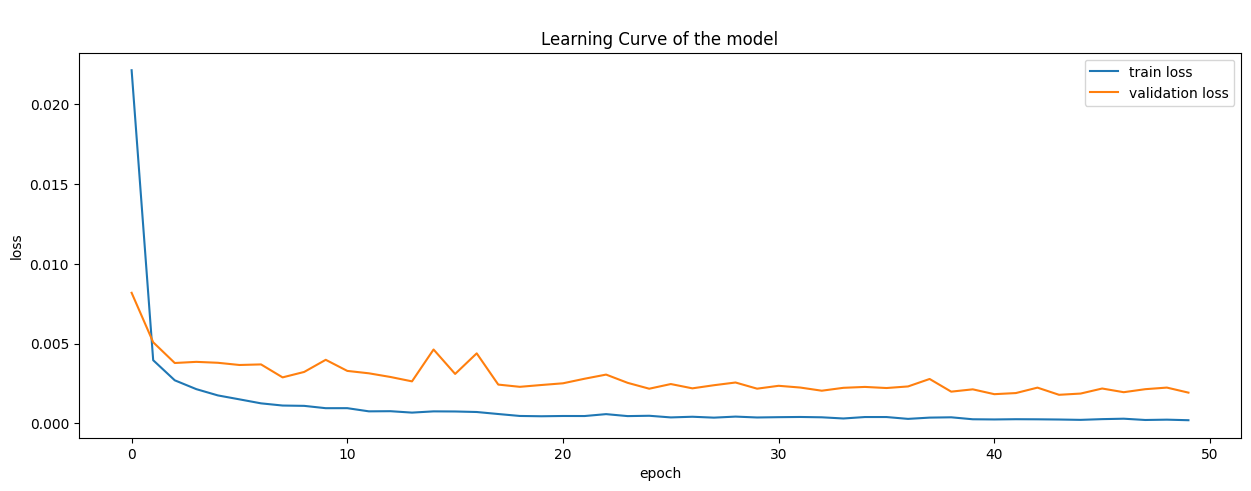

52/52 [==============================] - 0s 2ms/step
(1651, 1)

 MAE: 6974.48681640625, MAPE: 8.258102834224701, RMSE: 8884.716765322348, R2: 0.7677981513116054, T-time: 00:00:23


 Training time 00:00:23

PREDICTIONS :  [[71564.7890625], [72567.5390625], [78130.6953125], [79084.2265625], [83154.8359375], [93975.9921875], [95304.4609375], [93513.390625], [90061.3046875], [85820.1875], [80538.9921875], [73699.5703125], [69387.359375], [63063.09765625], [56565.7265625], [48077.359375], [41043.671875], [41900.0625], [46119.98046875], [52094.3828125], [56929.4453125], [58300.1484375], [61439.26171875], [66043.984375], [71354.4453125], [74968.5078125], [79200.84375], [83097.4921875], [88509.0078125], [96026.359375], [96251.34375], [94975.7421875], [91002.2109375], [90374.71875], [85243.78125], [75950.2421875], [71582.2421875], [66411.65625], [58785.34375], [51167.2421875], [45527.453125], [45238.9609375], [46823.9765625], [55317.70703125], [61801.52734375], [62812.25], [65790.359375], [7232

In [ ]:
# Fold 2
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_DeepEnergy(train2, lookback, lookahead)
plot_history(history)
results = eval_DeepEnergy(model, test2, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Epoch 1/50
129/129 [==============================] - 3s 10ms/step - loss: 0.0067 - val_loss: 0.0190 - lr: 0.0010
Epoch 2/50
129/129 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0078 - lr: 0.0010
Epoch 3/50
129/129 [==============================] - 2s 12ms/step - loss: 0.0012 - val_loss: 0.0137 - lr: 0.0010
Epoch 4/50
129/129 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0098 - lr: 0.0010
Epoch 5/50
129/129 [==============================] - 2s 12ms/step - loss: 8.5168e-04 - val_loss: 0.0107 - lr: 0.0010
Epoch 6/50
129/129 [==============================] - 1s 10ms/step - loss: 8.5414e-04 - val_loss: 0.0063 - lr: 0.0010
Epoch 7/50
129/129 [==============================] - 1s 8ms/step - loss: 7.7533e-04 - val_loss: 0.0069 - lr: 0.0010
Epoch 8/50
129/129 [==============================] - 1s 8ms/step - loss: 5.6752e-04 - val_loss: 0.0065 - lr: 0.0010
Epoch 9/50
129/129 [==============================] - 1s 7ms/step - loss: 5

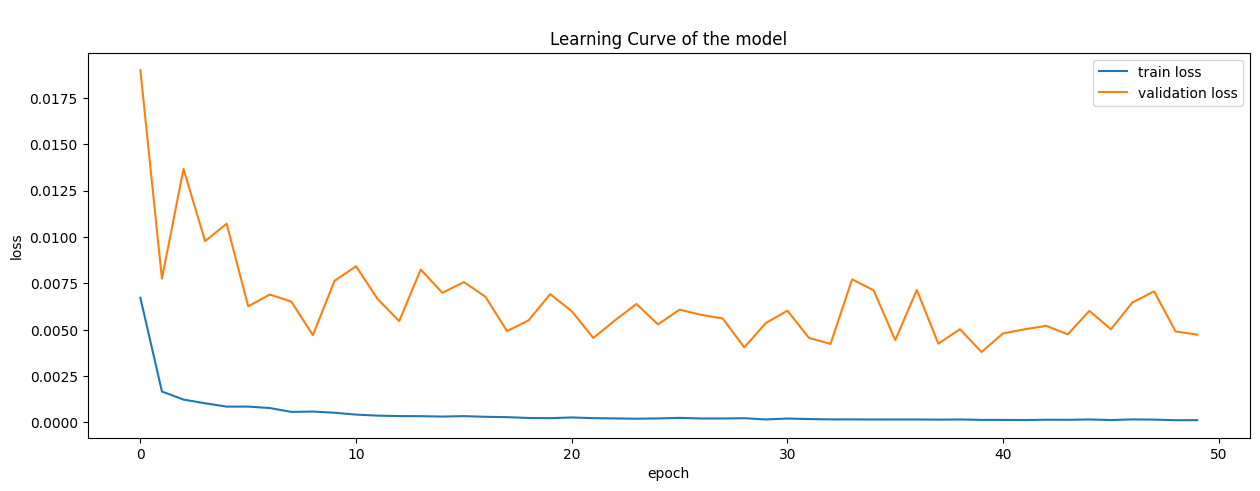

52/52 [==============================] - 0s 2ms/step
(1651, 1)

 MAE: 3876.5693359375, MAPE: 5.418872088193893, RMSE: 5113.955416309375, R2: 0.9009033628473624, T-time: 00:00:39


 Training time 00:00:39

PREDICTIONS :  [[66932.4765625], [76841.84375], [85830.8125], [88489.9453125], [87700.8125], [86545.21875], [85926.0703125], [86385.6484375], [87541.15625], [90034.859375], [101885.484375], [108911.2890625], [107055.0703125], [103031.828125], [94043.9375], [85031.4140625], [75480.78125], [68741.0078125], [63155.7734375], [59599.35546875], [54524.02734375], [51632.59375], [52708.70703125], [58681.4609375], [67194.2890625], [77409.53125], [84060.796875], [86332.609375], [87269.5390625], [88752.5390625], [86435.7890625], [86109.2421875], [86342.953125], [88984.6328125], [97646.875], [106176.4296875], [104107.171875], [98496.890625], [91696.359375], [83594.0078125], [74833.1953125], [66649.4765625], [63015.953125], [58939.0], [53487.28515625], [49050.953125], [53770.88671875], [59121.8867

In [ ]:
# Fold 3
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_DeepEnergy(train3, lookback, lookahead)
plot_history(history)
results = eval_DeepEnergy(model, test3, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Epoch 1/50
173/173 [==============================] - 3s 6ms/step - loss: 0.0111 - val_loss: 0.0066 - lr: 0.0010
Epoch 2/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0039 - lr: 0.0010
Epoch 3/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 0.0019 - lr: 0.0010
Epoch 4/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0029 - lr: 0.0010
Epoch 5/50
173/173 [==============================] - 1s 6ms/step - loss: 9.2077e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 6/50
173/173 [==============================] - 1s 6ms/step - loss: 7.2735e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 7/50
173/173 [==============================] - 1s 6ms/step - loss: 6.7538e-04 - val_loss: 9.1551e-04 - lr: 0.0010
Epoch 8/50
173/173 [==============================] - 1s 4ms/step - loss: 5.9109e-04 - val_loss: 9.2032e-04 - lr: 0.0010
Epoch 9/50
173/173 [==============================] - 1s 4ms/step - loss

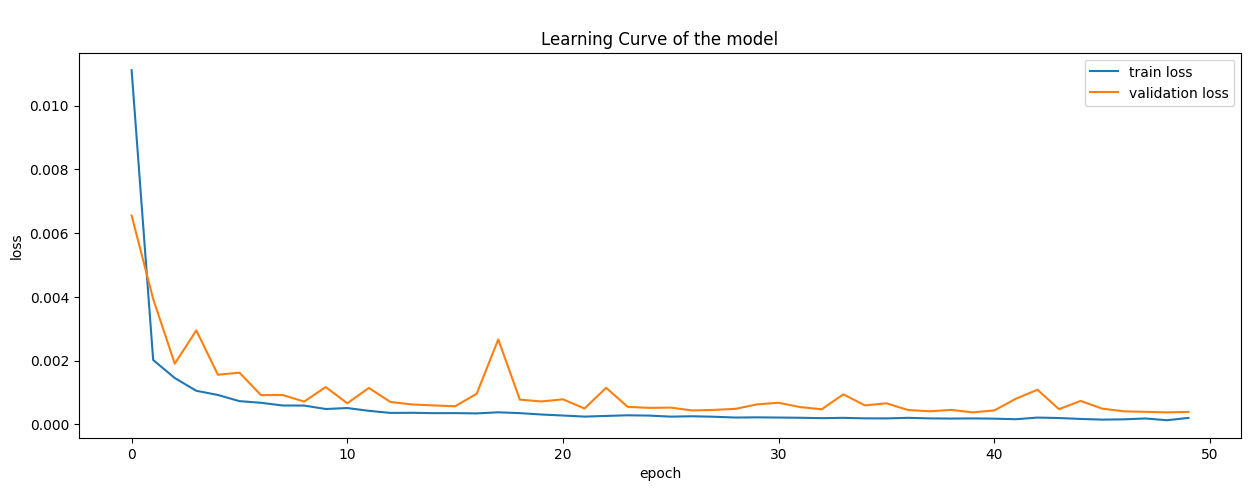

52/52 [==============================] - 0s 3ms/step
(1652, 1)

 MAE: 2470.6611328125, MAPE: 3.8373414427042007, RMSE: 3030.0531348476384, R2: 0.9533015049868706, T-time: 00:00:46


 Training time 00:00:46

PREDICTIONS :  [[48926.8046875], [51762.69140625], [50401.25], [46441.609375], [52934.84765625], [61911.1796875], [65317.65234375], [68425.0546875], [70510.96875], [70840.9296875], [69718.3046875], [68854.625], [70335.28125], [81641.3359375], [92777.2578125], [95633.5546875], [91248.203125], [84513.4921875], [75535.6953125], [64836.9609375], [55890.5], [50902.671875], [48742.671875], [48068.42578125], [50118.19140625], [53661.3046875], [49919.4609375], [46513.3515625], [56257.8125], [64747.59765625], [67576.96875], [69166.171875], [70817.375], [71125.59375], [69241.484375], [69488.9765625], [70791.875], [82547.5546875], [92441.265625], [92703.9296875], [89721.5546875], [84724.890625], [77445.4375], [66175.40625], [57270.19140625], [51912.9609375], [48509.19921875], [47944.84375], [4

In [ ]:
# Fold 4
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_DeepEnergy(train4, lookback, lookahead)
plot_history(history)
results = eval_DeepEnergy(model, test4, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# 6. P-ConvLSTM (Proposed Model)

In [13]:
def build_P_C2DLSTM(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_x_hum, train_x_wind, train_x_gdf, train_x_df, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_x_hum = scaler_hum.fit_transform(train_x_hum.reshape(train_x_hum.shape[0]*train_x_hum.shape[1],train_x_hum.shape[2])).reshape(-1,lookback,1)
    train_x_wind = scaler_wind.fit_transform(train_x_wind.reshape(train_x_wind.shape[0]*train_x_wind.shape[1],train_x_wind.shape[2])).reshape(-1,lookback,1)
    train_x_gdf = scaler_gdf.fit_transform(train_x_gdf.reshape(train_x_gdf.shape[0]*train_x_gdf.shape[1],train_x_gdf.shape[2])).reshape(-1,lookback,1)
    train_x_df = scaler_df.fit_transform(train_x_df.reshape(train_x_df.shape[0]*train_x_df.shape[1],train_x_df.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    n_steps, rows, cols, n_features, n_outputs  = 4, 1, 24, 1, train_y.shape[1]

    train_x_load = train_x_load.reshape(-1,n_steps,rows,cols,n_features)
    train_x_temp = train_x_temp.reshape(-1,n_steps,rows,cols,n_features)
    train_x_hum = train_x_hum.reshape(-1,n_steps,rows,cols,n_features)
    train_x_wind = train_x_wind.reshape(-1,n_steps,rows,cols,n_features)
    train_x_gdf = train_x_gdf.reshape(-1,n_steps,rows,cols,n_features)
    train_x_df = train_x_df.reshape(-1,n_steps,rows,cols,n_features)
    # define model
    load_inputs = layers.Input(shape=(train_x_load.shape[1], train_x_load.shape[2],train_x_load.shape[3],train_x_load.shape[4]))
    temp_inputs = layers.Input(shape=(train_x_temp.shape[1], train_x_temp.shape[2],train_x_temp.shape[3],train_x_temp.shape[4]))
    hum_inputs = layers.Input(shape=(train_x_hum.shape[1], train_x_hum.shape[2],train_x_hum.shape[3],train_x_hum.shape[4]))
    wind_inputs = layers.Input(shape=(train_x_wind.shape[1], train_x_wind.shape[2],train_x_wind.shape[3],train_x_wind.shape[4]))
    gdf_inputs = layers.Input(shape=(train_x_gdf.shape[1], train_x_gdf.shape[2],train_x_gdf.shape[3],train_x_gdf.shape[4]))
    df_inputs = layers.Input(shape=(train_x_df.shape[1], train_x_df.shape[2],train_x_df.shape[3],train_x_df.shape[4]))
    print("Inputs:\n Load {},\n Temp {}\n Humidity {}\n Wind {}\n GDF {}\n DF {}\nOutput: {}\n".format(load_inputs.shape,temp_inputs.shape,
      hum_inputs.shape,wind_inputs.shape,gdf_inputs.shape,df_inputs.shape,train_y.shape))

    x1 = layers.ConvLSTM2D(filters=32, kernel_size=(1,5))(load_inputs)
    print("ConvLSTM2D : {}".format(x1.shape))
    x1 = layers.Flatten()(x1)
    print("Flatten : ", x1.shape)

    x2 = layers.ConvLSTM2D(filters=12, kernel_size=(1,5))(temp_inputs)
    print("ConvLSTM2D : {}".format(x2.shape))
    x2 = layers.Flatten()(x2)
    print("Flatten : ", x2.shape)

    x3 = layers.ConvLSTM2D(filters=12, kernel_size=(1,5))(hum_inputs)
    print("ConvLSTM2D : {}".format(x3.shape))
    x3 = layers.Flatten()(x3)
    print("Flatten : ", x3.shape)

    x4 = layers.ConvLSTM2D(filters=12, kernel_size=(1,5))(wind_inputs)
    print("ConvLSTM2D : {}".format(x4.shape))
    x4 = layers.Flatten()(x4)
    print("Flatten : ", x4.shape)

    x5 = layers.ConvLSTM2D(filters=12, kernel_size=(1,5))(gdf_inputs)
    print("ConvLSTM2D : {}".format(x5.shape))
    x5 = layers.Flatten()(x5)
    print("Flatten : ", x5.shape)

    x6 = layers.ConvLSTM2D(filters=12, kernel_size=(1,5))(df_inputs)
    print("ConvLSTM2D : {}".format(x6.shape))
    x6 = layers.Flatten()(x6)
    print("Flatten : ", x6.shape)

    print("CONCATENATING {}, {}, {}, {}, {}, {}".format(x1.shape,x2.shape,x3.shape,x4.shape,x5.shape,x6.shape))
    x = layers.Concatenate()([x1,x2,x3,x4,x5,x6])
    print("Concate ",x.shape)
    x = layers.Dense(24, activation="relu")(x)
    print("D24 :",x.shape)
    x = layers.Dense(1)(x)
    print("outputs :",x.shape)
    model = Model(inputs=[load_inputs, temp_inputs, hum_inputs, wind_inputs, gdf_inputs, df_inputs], outputs=x, name="P-C2DLSTM")
    model.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    # mc = callbacks.ModelCheckpoint('convlstm2d.h5',monitor='val_loss',mode='min',save_best_only=True)
    history = model.fit([train_x_load, train_x_temp, train_x_hum, train_x_wind, train_x_gdf, train_x_df],
                        train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    # model = load_model('convlstm2d.h5')
    return model, history.history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df

# load and temp inputs series in ConvLSTM2D
def eval_P_C2DLSTM(model, test, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df):
    test_x_load, test_x_temp, test_x_hum, test_x_wind, test_x_gdf, test_x_df, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x_hum = scaler_hum.transform(test_x_hum.reshape(test_x_hum.shape[0]*test_x_hum.shape[1],test_x_hum.shape[2])).reshape(-1,lookback,1)
    test_x_wind = scaler_wind.transform(test_x_wind.reshape(test_x_wind.shape[0]*test_x_wind.shape[1],test_x_wind.shape[2])).reshape(-1,lookback,1)
    test_x_gdf = scaler_gdf.transform(test_x_gdf.reshape(test_x_gdf.shape[0]*test_x_gdf.shape[1],test_x_gdf.shape[2])).reshape(-1,lookback,1)
    test_x_df = scaler_df.transform(test_x_df.reshape(test_x_df.shape[0]*test_x_df.shape[1],test_x_df.shape[2])).reshape(-1,lookback,1)
    n_steps, rows, cols, n_features  = 4, 1, 24, 1
    test_x_load = test_x_load.reshape(-1,n_steps,rows,cols,n_features)
    test_x_temp = test_x_temp.reshape(-1,n_steps,rows,cols,n_features)
    test_x_hum = test_x_hum.reshape(-1,n_steps,rows,cols,n_features)
    test_x_wind = test_x_wind.reshape(-1,n_steps,rows,cols,n_features)
    test_x_gdf = test_x_gdf.reshape(-1,n_steps,rows,cols,n_features)
    test_x_df = test_x_df.reshape(-1,n_steps,rows,cols,n_features)

    yhat = model.predict([test_x_load, test_x_temp,test_x_hum, test_x_wind,test_x_gdf, test_x_df], verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Running Time
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_P_C2DLSTM(train1, lookback, lookahead)

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Humidity (None, 4, 1, 24, 1)
 Wind (None, 4, 1, 24, 1)
 GDF (None, 4, 1, 24, 1)
 DF (None, 4, 1, 24, 1)
Output: (1651, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
CONCATENATING (None, 640), (None, 240), (None, 240), (None, 240), (None, 240), (None, 240)
Concate  (None, 1840)
D24 : (None, 24)
outputs : (None, 1)
21/21 [==============================] - 15s 169ms/step - loss: 0.0394 - val_loss: 0.0137 - lr: 0.0010
Convergence time is : 00:00:15


Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Humidity (None, 4, 1, 24, 1)
 Wind (None, 4, 1, 24, 1)
 GDF (None, 4, 1, 24, 1)
 DF (None, 4, 1, 24, 1)
Output: (1651, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
CONCATENATING (None, 640), (None, 240), (None, 240), (None, 240), (None, 240), (None, 240)
Concate  (None, 1840)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:06:37


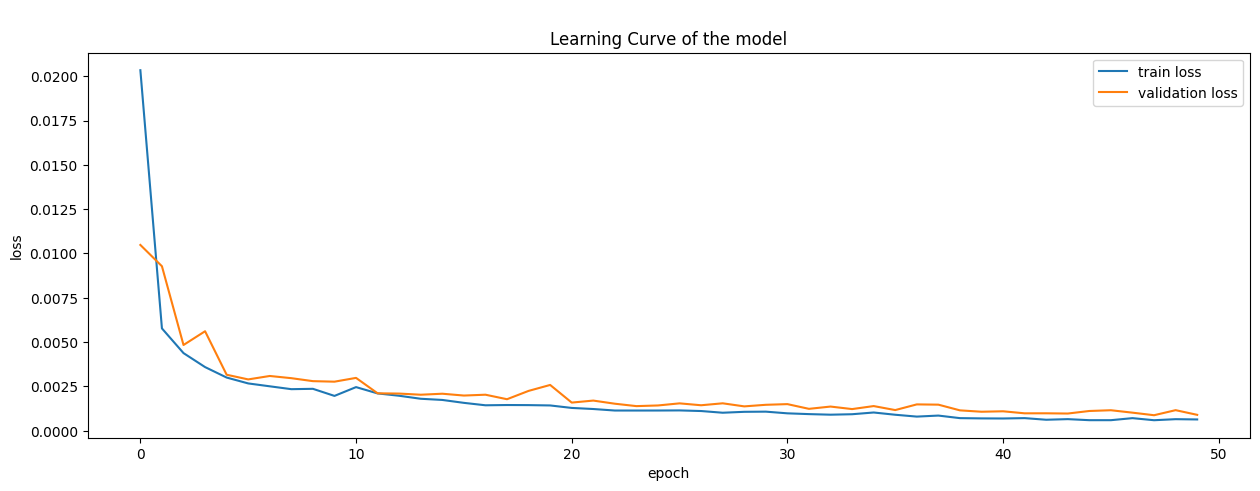


 MAE: 2410.053955078125, MAPE: 3.694527968764305, RMSE: 3162.1086319100423, R2: 0.9506206227944877, T-time: 00:06:37


 Training time 00:06:37

PREDICTIONS :  [[89855.578125], [89896.0703125], [87237.015625], [80570.7265625], [71206.5703125], [61586.8515625], [54998.98828125], [51331.6328125], [50273.625], [50040.8125], [49590.87890625], [47970.90625], [45661.03125], [46381.99609375], [52664.40625], [59704.0390625], [66455.265625], [69429.2265625], [70255.5234375], [68827.8359375], [67073.875], [65770.0859375], [67955.328125], [76416.9921875], [86247.484375], [87461.265625], [85500.03125], [80828.1171875], [72917.2578125], [62532.28125], [54975.2890625], [50989.8984375], [48662.86328125], [48508.359375], [48357.4921875], [47598.3125], [46615.66796875], [48252.57421875], [56274.3046875], [65496.12890625], [72354.328125], [74692.1015625], [75010.6484375], [73667.6875], [71495.515625], [70334.5703125], [72303.1484375], [80010.9296875], [91773.2734375], [93326.7890625], [91182.21875], [85

In [ ]:
# Fold 1
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_P_C2DLSTM(train1, lookback, lookahead)
plot_history(history)
results = eval_P_C2DLSTM(model, test1, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Humidity (None, 4, 1, 24, 1)
 Wind (None, 4, 1, 24, 1)
 GDF (None, 4, 1, 24, 1)
 DF (None, 4, 1, 24, 1)
Output: (3398, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
CONCATENATING (None, 640), (None, 240), (None, 240), (None, 240), (None, 240), (None, 240)
Concate  (None, 1840)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:12:36


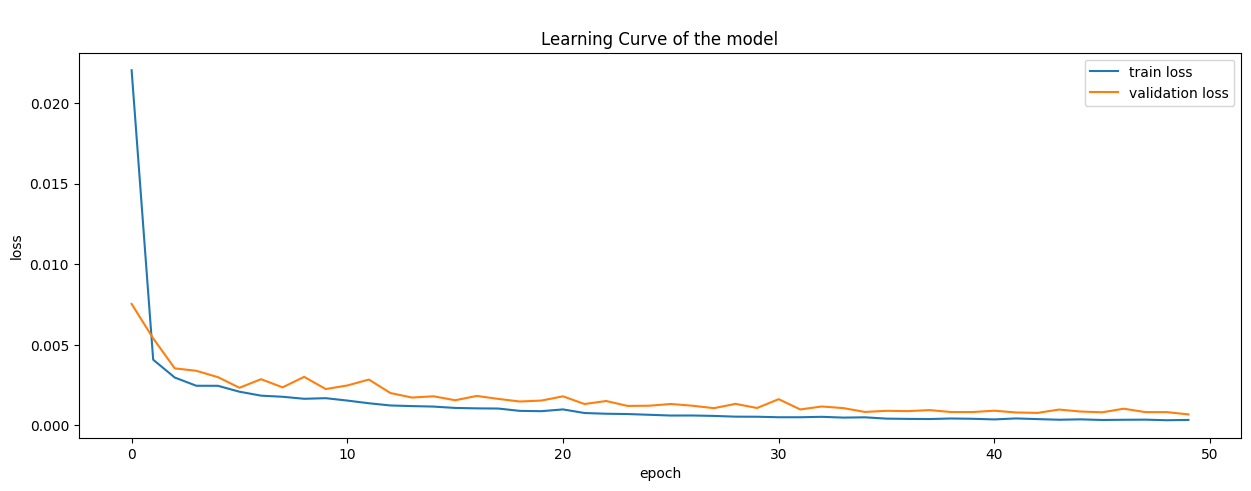


 MAE: 2678.337646484375, MAPE: 3.457595407962799, RMSE: 3302.593829098577, R2: 0.9679159768479589, T-time: 00:12:36


 Training time 00:12:36

PREDICTIONS :  [[74939.109375], [74733.1484375], [75241.3984375], [75026.3046875], [81777.8046875], [95064.1796875], [98918.6484375], [97918.9765625], [97628.8515625], [90889.5078125], [79528.9921875], [74543.78125], [76865.0078125], [70554.4375], [60342.6796875], [51495.00390625], [46151.89453125], [45629.9609375], [50002.203125], [57943.70703125], [63969.05859375], [67335.15625], [69093.9375], [72726.9765625], [74358.9765625], [73269.0625], [72977.4375], [73576.8828125], [83620.3359375], [99180.15625], [99648.4375], [97365.140625], [96205.4765625], [90424.25], [79776.9609375], [75000.625], [77623.0703125], [71923.75], [61939.72265625], [52507.15625], [47555.1953125], [46438.7734375], [50317.96484375], [57098.953125], [63331.41015625], [67388.3515625], [71546.40625], [76073.2109375], [75342.015625], [72422.7890625], [73028.5703125], [74088.828

In [ ]:
# Fold 2
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_P_C2DLSTM(train2, lookback, lookahead)
plot_history(history)
results = eval_P_C2DLSTM(model, test2, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Humidity (None, 4, 1, 24, 1)
 Wind (None, 4, 1, 24, 1)
 GDF (None, 4, 1, 24, 1)
 DF (None, 4, 1, 24, 1)
Output: (5145, 1, 1)

ConvLSTM2D32 : (None, 1, 20, 32)
Flatten :  (None, 640)
ConvLSTM2D32 : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D32 : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D32 : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D32 : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D32 : (None, 1, 20, 12)
Flatten :  (None, 240)
CONCATENATING (None, 640), (None, 240)
Concate  (None, 1840)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:15:36


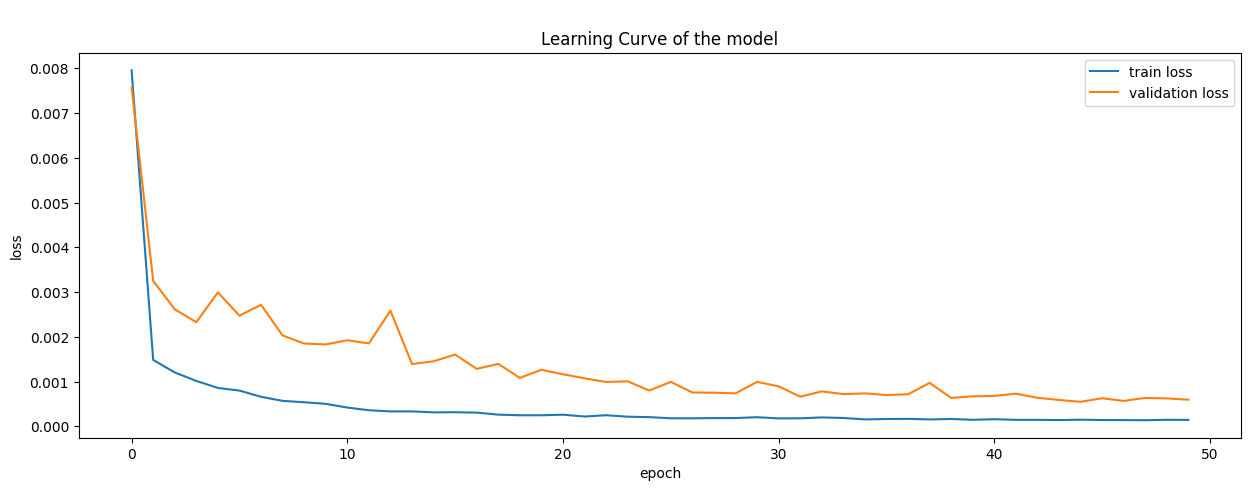


 MAE: 1084.579833984375, MAPE: 1.534589845687151, RMSE: 1504.4692585759271, R2: 0.9914234708021366, T-time: 00:15:36


 Training time 00:15:36

PREDICTIONS :  [[84199.8671875], [93231.1015625], [99112.03125], [100669.2109375], [98940.9609375], [96378.46875], [93573.328125], [92705.3125], [91387.578125], [95120.8203125], [112930.2265625], [119585.09375], [117839.765625], [113214.2578125], [102841.6875], [91905.7109375], [81623.359375], [74107.8515625], [69947.171875], [68739.3203125], [62734.91796875], [57510.84375], [64166.56640625], [75573.40625], [83766.953125], [91404.28125], [95377.515625], [96945.171875], [97991.3359375], [96469.7578125], [92820.609375], [91365.0703125], [89266.3828125], [93390.2109375], [113242.9375], [119620.6640625], [118142.796875], [113665.203125], [102846.3828125], [92573.296875], [84287.078125], [76973.6484375], [72014.546875], [69757.953125], [62430.30859375], [57850.73828125], [63507.62890625], [72623.3359375], [79315.5078125], [86408.265625], [91784.687

In [ ]:
# Fold 3
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_P_C2DLSTM(train3, lookback, lookahead)
plot_history(history)
results = eval_P_C2DLSTM(model, test3, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Humidity (None, 4, 1, 24, 1)
 Wind (None, 4, 1, 24, 1)
 GDF (None, 4, 1, 24, 1)
 DF (None, 4, 1, 24, 1)
Output: (6892, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
CONCATENATING (None, 640), (None, 240), (None, 240), (None, 240), (None, 240), (None, 240)
Concate  (None, 1840)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:22:38


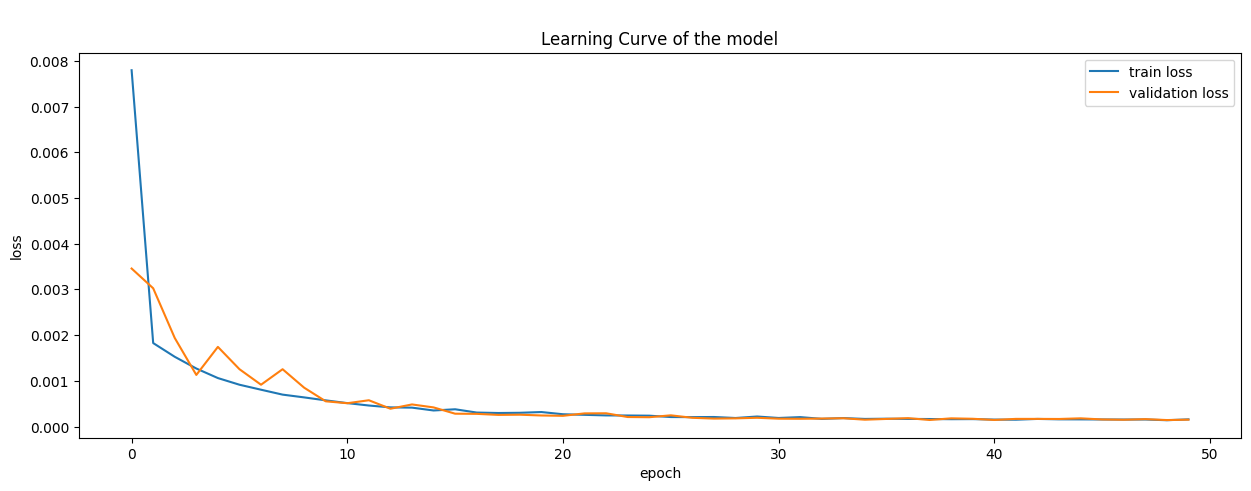


 MAE: 776.3265991210938, MAPE: 1.2646947987377644, RMSE: 1050.4769155007643, R2: 0.9943872535436469, T-time: 00:22:38


 Training time 00:22:38

PREDICTIONS :  [[51634.0], [53197.28515625], [49573.171875], [53471.4296875], [58341.40234375], [64286.91015625], [68222.84375], [70945.9921875], [72477.96875], [72112.5625], [70343.6328125], [69992.0234375], [70086.4296875], [77305.140625], [94406.09375], [95008.140625], [92764.3046875], [85577.625], [74599.8046875], [65047.4921875], [57271.234375], [54039.296875], [52016.11328125], [51067.0859375], [51938.40234375], [54355.83203125], [52437.3671875], [53787.34765625], [59339.73828125], [64848.06640625], [68463.40625], [71119.609375], [73480.2421875], [72668.71875], [71605.765625], [70265.6640625], [70022.28125], [78436.53125], [93581.1484375], [94336.2421875], [91852.34375], [85820.3359375], [75939.2734375], [65153.4921875], [58515.296875], [53684.12109375], [51321.7890625], [50432.3671875], [50939.28515625], [54980.234375], [53289.53125], 

In [ ]:
# Fold 4
model, history, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = build_P_C2DLSTM(train4, lookback, lookahead)
plot_history(history)
results = eval_P_C2DLSTM(model, test4, scaler_load, scaler_temp,scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# 7. PLCNet MODEL

In [15]:
def build_REF30(train, lookback, lookahead):
    # data prepare
    train_x, _, _, _, _, _, train_y = reframe(train, lookback, lookahead)
    scaler = MinMaxScaler()
    # scaling load temp features and load label
    train_x = scaler.fit_transform(train_x.reshape(train_x.shape[0]*train_x.shape[1],train_x.shape[2])).reshape(-1,lookback,1)
    train_y = scaler.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    # # define model
    inputs = layers.Input(shape=(train_x.shape[1], train_x.shape[2]))
    print("Inputs: {},\n Output: {}\n".format(inputs.shape,train_y.shape))

    # CNN Path
    cnn_path = layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
    print("Conv1D-64 : {}".format(cnn_path.shape))
    cnn_path = layers.MaxPooling1D()(cnn_path)
    print("MaxPooling1D : {}".format(cnn_path.shape))
    cnn_path = layers.Conv1D(32, kernel_size=2, activation='relu')(cnn_path)
    print("Conv1D-32 : {}".format(cnn_path.shape))
    cnn_path = layers.Flatten()(cnn_path)
    print("Flatten : {}".format(cnn_path.shape))

    #LSTM Path
    lstm_path = layers.LSTM(48)(inputs)
    print("LSTM : {}".format(lstm_path.shape))

    # Concatenate paths
    merged_data = layers.concatenate([cnn_path, lstm_path])
    print("Concatenate : {}".format(merged_data.shape))
    merged_data = layers.Reshape((merged_data.shape[1], 1))(merged_data)
    print("Reshape : {}".format(merged_data.shape))

    # Fully Connected Layer
    fc_layer = layers.LSTM(300)(merged_data)
    print("LSTM : {}".format(fc_layer.shape))
    fc_layer = layers.Dense(50, activation='relu')(fc_layer)
    print("Dense128 : {}".format(fc_layer.shape))
    fc_layer = layers.Dropout(0.3)(fc_layer)
    print("Dropout : {}".format(fc_layer.shape))
    fc_layer = layers.Dense(24, activation='relu')(fc_layer)
    print("Dense64 : {}".format(fc_layer.shape))

    # Output Layer
    output_layer = layers.Dense(1, activation='linear')(fc_layer)
    print("outputs :",output_layer.shape)
    model = Model(inputs=inputs, outputs=output_layer, name="PLCnet")
    model.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    # mc = callbacks.ModelCheckpoint('convlstm2d.h5',monitor='val_loss',mode='min',save_best_only=True)
    history = model.fit(train_x,train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    # model = load_model('convlstm2d.h5')
    return model, history.history, t, scaler

# load and temp inputs series in ConvLSTM2D
def eval_REF30(model, test, scaler):
    test_x, _, _, _, _, _, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x = scaler.transform(test_x.reshape(test_x.shape[0]*test_x.shape[1],test_x.shape[2])).reshape(-1,lookback,1)

    yhat = model.predict(test_x, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat = scaler.inverse_transform(yhat).reshape(-1,lookahead)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [17]:
# Running Time
model, history, t, scaler = build_REF30(train1, lookback, lookahead)

Inputs: (None, 96, 1),
 Output: (3398, 1, 1)

Conv1D-64 : (None, 95, 64)
MaxPooling1D : (None, 47, 64)
Conv1D-32 : (None, 46, 32)
Flatten : (None, 1472)
LSTM : (None, 48)
Concatenate : (None, 1520)
Reshape : (None, 1520, 1)
LSTM : (None, 300)
Dense128 : (None, 50)
Dropout : (None, 50)
Dense64 : (None, 24)
outputs : (None, 1)
43/43 [==============================] - 19s 191ms/step - loss: 0.1252 - val_loss: 0.0482 - lr: 0.0010
Convergence time is : 00:00:19


Inputs: (None, 96, 1),
 Output: (1651, 1, 1)

Conv1D-64 : (None, 95, 64)
MaxPooling1D : (None, 47, 64)
Conv1D-32 : (None, 46, 32)
Flatten : (None, 1472)
LSTM : (None, 48)
Concatenate : (None, 1520)
Reshape : (None, 1520, 1)
LSTM : (None, 300)
Dense128 : (None, 50)
Dropout : (None, 50)
Dense64 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:03:27


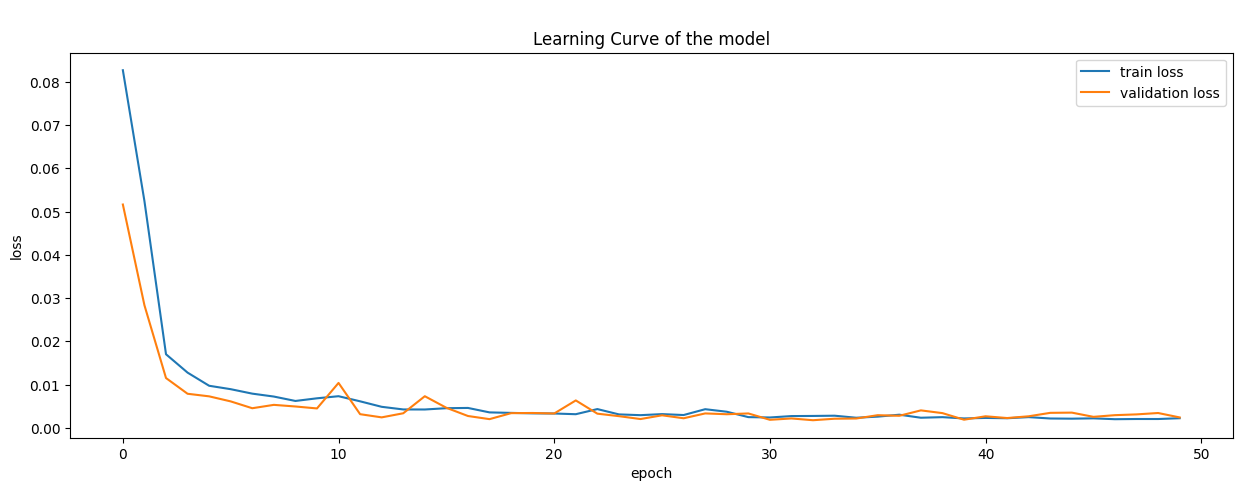


 MAE: 3904.7119140625, MAPE: 5.753478407859802, RMSE: 5193.453186464667, R2: 0.8667999265371009, T-time: 00:03:27


 Training time 00:03:27

PREDICTIONS :  [[86947.6953125], [86547.9140625], [83953.2265625], [78788.2109375], [71940.59375], [63599.38671875], [56093.328125], [51209.43359375], [49828.7109375], [49666.2734375], [49828.1328125], [49705.4296875], [49796.6796875], [49964.96484375], [50979.625], [59122.9296875], [64613.578125], [67321.3125], [68259.3203125], [67682.171875], [66423.1640625], [65669.1484375], [68183.3203125], [80225.953125], [85429.890625], [85535.1875], [83864.8125], [79850.5859375], [73293.3671875], [64215.9453125], [56159.66796875], [51192.0234375], [49818.58984375], [49682.109375], [49844.73046875], [49723.8515625], [49800.34765625], [50027.52734375], [54189.48828125], [63782.078125], [69145.5703125], [71180.0625], [71737.0859375], [71336.2265625], [70476.4375], [70111.84375], [73408.0859375], [85536.2421875], [88352.03125], [88617.8671875], [86587.96875], 

In [ ]:
# Fold 1
model, history, t, scaler = build_REF30(train1, lookback, lookahead)
plot_history(history)
results = eval_REF30(model, test1, scaler)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 1),
 Output: (3398, 1, 1)

Conv1D-64 : (None, 95, 64)
MaxPooling1D : (None, 47, 64)
Conv1D-32 : (None, 46, 32)
Flatten : (None, 1472)
LSTM : (None, 48)
Concatenate : (None, 1520)
Reshape : (None, 1520, 1)
LSTM : (None, 300)
Dense128 : (None, 50)
Dropout : (None, 50)
Dense64 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:07:25


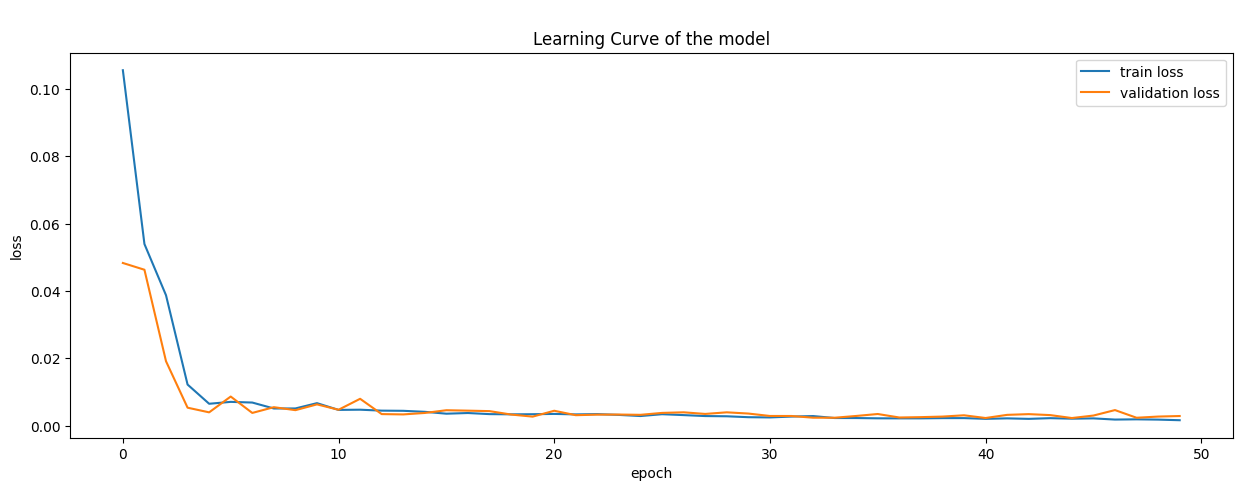


 MAE: 6687.2265625, MAPE: 7.8108347952365875, RMSE: 9125.583378612022, R2: 0.7550374327081276, T-time: 00:07:25


 Training time 00:07:25

PREDICTIONS :  [[76791.46875], [75375.078125], [72547.0703125], [71163.9921875], [72732.875], [82923.6171875], [93230.1796875], [94678.3359375], [93322.140625], [90739.140625], [79907.96875], [70182.515625], [69801.5546875], [73751.09375], [65635.59375], [58633.22265625], [54200.23046875], [53720.3046875], [53439.453125], [55046.0], [61037.3125], [68534.6015625], [71447.1875], [74427.5546875], [76269.6953125], [74161.4921875], [72359.1953125], [71447.15625], [73563.9375], [84718.34375], [92973.0390625], [94614.6875], [93445.3515625], [91166.2109375], [81432.8359375], [70417.6484375], [70042.484375], [75717.171875], [66261.2265625], [58921.05078125], [54561.796875], [53940.7734375], [53516.7578125], [54730.33203125], [60878.48046875], [68649.109375], [75205.90625], [77069.8203125], [76069.703125], [74898.140625], [73314.890625], [71867.5390625], [73

In [ ]:
# Fold 2
model, history, t, scaler = build_REF30(train2, lookback, lookahead)
plot_history(history)
results = eval_REF30(model, test2, scaler)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 1),
 Output: (5145, 1, 1)

Conv1D-64 : (None, 95, 64)
MaxPooling1D : (None, 47, 64)
Conv1D-32 : (None, 46, 32)
Flatten : (None, 1472)
LSTM : (None, 48)
Concatenate : (None, 1520)
Reshape : (None, 1520, 1)
LSTM : (None, 300)
Dense128 : (None, 50)
Dropout : (None, 50)
Dense64 : (None, 24)
outputs : (None, 1)
Epoch 44: early stopping
Convergence time is : 00:08:42


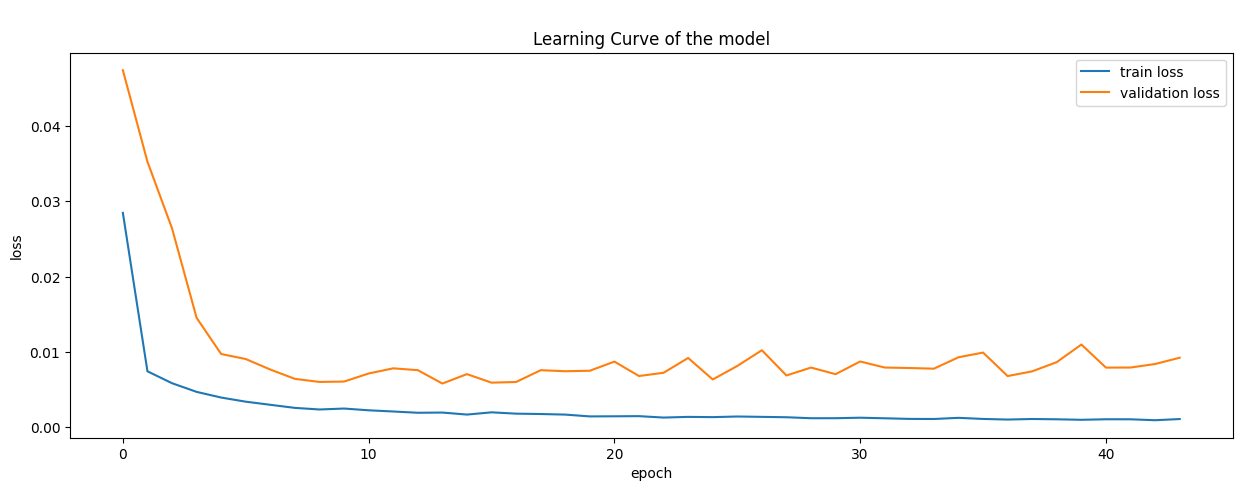


 MAE: 3810.841796875, MAPE: 5.308820307254791, RMSE: 5550.96568175304, R2: 0.8832432295047294, T-time: 00:08:42


 Training time 00:08:42

PREDICTIONS :  [[78412.1484375], [86093.09375], [92155.6875], [93157.5078125], [93417.265625], [93323.609375], [92993.9765625], [92578.09375], [92458.34375], [92745.2578125], [93784.59375], [97733.0546875], [100118.1328125], [99591.8203125], [97268.0546875], [93675.03125], [86589.9921875], [73836.4609375], [69925.7109375], [69997.0859375], [72340.59375], [70968.984375], [70773.84375], [73399.8984375], [76932.890625], [83014.984375], [89917.8125], [92251.84375], [92763.4921875], [92901.765625], [92632.0234375], [92361.390625], [92486.890625], [93297.1484375], [94911.4140625], [98894.3671875], [100483.8671875], [99145.5859375], [96459.7578125], [92888.1875], [85564.453125], [72944.46875], [68490.78125], [69221.484375], [70781.8046875], [69467.3359375], [69641.0703125], [72516.5078125], [75779.5], [78752.9453125], [84545.1015625], [89304.4921875], [90

In [ ]:
# Fold 3
model, history, t, scaler = build_REF30(train3, lookback, lookahead)
plot_history(history)
results = eval_REF30(model, test3, scaler)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 1),
 Output: (6892, 1, 1)

Conv1D-64 : (None, 95, 64)
MaxPooling1D : (None, 47, 64)
Conv1D-32 : (None, 46, 32)
Flatten : (None, 1472)
LSTM : (None, 48)
Concatenate : (None, 1520)
Reshape : (None, 1520, 1)
LSTM : (None, 300)
Dense128 : (None, 50)
Dropout : (None, 50)
Dense64 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:13:22


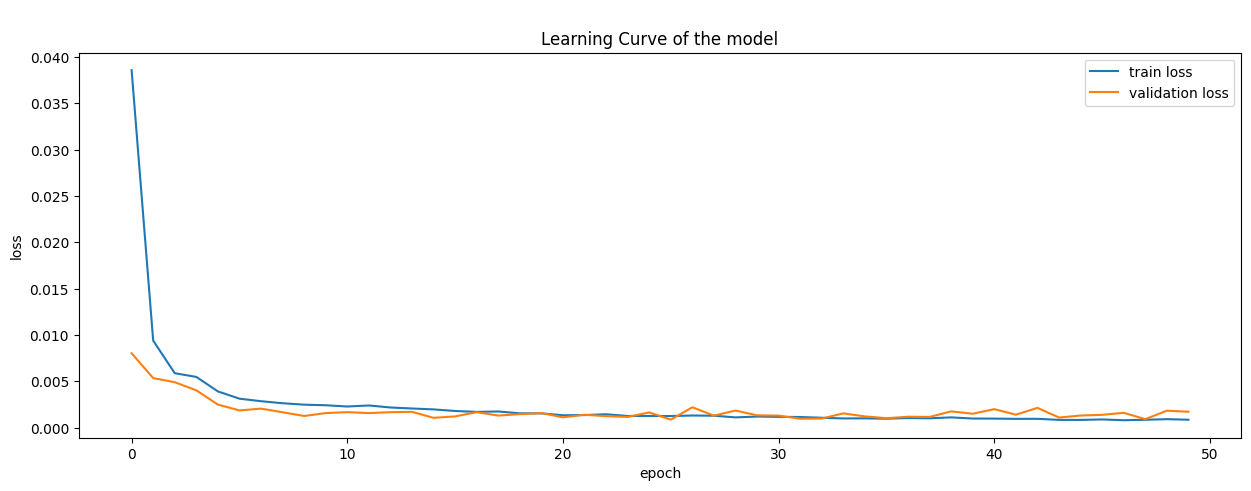


 MAE: 3162.225830078125, MAPE: 5.081680789589882, RMSE: 4082.1882612148106, R2: 0.9152404799202549, T-time: 00:13:22


 Training time 00:13:22

PREDICTIONS :  [[51651.2734375], [52679.38671875], [55995.58984375], [55912.2734375], [59884.578125], [66216.75], [68852.3203125], [70217.828125], [70891.28125], [70695.4453125], [70245.9765625], [70342.875], [69964.84375], [72011.9375], [86083.171875], [88384.5703125], [86028.5390625], [80926.8125], [72230.7109375], [65474.88671875], [60168.20703125], [55621.45703125], [52899.3984375], [51769.35546875], [51845.0546875], [53068.0078125], [58800.28125], [57788.65234375], [61690.421875], [66984.46875], [69229.703125], [70451.84375], [71441.7890625], [71150.875], [70708.5625], [70294.9609375], [70419.2890625], [73819.7109375], [86611.03125], [88426.90625], [85796.9375], [80929.15625], [72488.609375], [65545.1171875], [60694.26171875], [54896.62109375], [52486.21484375], [51476.21875], [51462.62890625], [52970.46484375], [58569.828125], [57949.128

In [ ]:
# Fold 4
model, history, t, scaler = build_REF30(train4, lookback, lookahead)
plot_history(history)
results = eval_REF30(model, test4, scaler)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# A Baseline (Suggested, but not include)

In [ ]:
def Multiple_C2DLSTM(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_x_hum, train_x_wind, train_x_gdf, train_x_df, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_x_hum = scaler_hum.fit_transform(train_x_hum.reshape(train_x_hum.shape[0]*train_x_hum.shape[1],train_x_hum.shape[2])).reshape(-1,lookback,1)
    train_x_wind = scaler_wind.fit_transform(train_x_wind.reshape(train_x_wind.shape[0]*train_x_wind.shape[1],train_x_wind.shape[2])).reshape(-1,lookback,1)
    train_x_gdf = scaler_gdf.fit_transform(train_x_gdf.reshape(train_x_gdf.shape[0]*train_x_gdf.shape[1],train_x_gdf.shape[2])).reshape(-1,lookback,1)
    train_x_df = scaler_df.fit_transform(train_x_df.reshape(train_x_df.shape[0]*train_x_df.shape[1],train_x_df.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    n_steps, rows, cols, n_features, n_outputs  = 4, 1, 24, 1, train_y.shape[1]

    train_x_load = train_x_load.reshape(-1,n_steps,rows,cols,n_features)
    train_x_temp = train_x_temp.reshape(-1,n_steps,rows,cols,n_features)
    train_x_hum = train_x_hum.reshape(-1,n_steps,rows,cols,n_features)
    train_x_wind = train_x_wind.reshape(-1,n_steps,rows,cols,n_features)
    train_x_gdf = train_x_gdf.reshape(-1,n_steps,rows,cols,n_features)
    train_x_df = train_x_df.reshape(-1,n_steps,rows,cols,n_features)
    # define model
    load_inputs = layers.Input(shape=(train_x_load.shape[1], train_x_load.shape[2],train_x_load.shape[3],train_x_load.shape[4]))
    temp_inputs = layers.Input(shape=(train_x_temp.shape[1], train_x_temp.shape[2],train_x_temp.shape[3],train_x_temp.shape[4]))
    hum_inputs = layers.Input(shape=(train_x_hum.shape[1], train_x_hum.shape[2],train_x_hum.shape[3],train_x_hum.shape[4]))
    wind_inputs = layers.Input(shape=(train_x_wind.shape[1], train_x_wind.shape[2],train_x_wind.shape[3],train_x_wind.shape[4]))
    gdf_inputs = layers.Input(shape=(train_x_gdf.shape[1], train_x_gdf.shape[2],train_x_gdf.shape[3],train_x_gdf.shape[4]))
    df_inputs = layers.Input(shape=(train_x_df.shape[1], train_x_df.shape[2],train_x_df.shape[3],train_x_df.shape[4]))
    print("Inputs:\n Load {},\n Temp {}\n Humidity {}\n Wind {}\n GDF {}\n DF {}\nOutput: {}\n".format(load_inputs.shape,temp_inputs.shape,
      hum_inputs.shape,wind_inputs.shape,gdf_inputs.shape,df_inputs.shape,train_y.shape))

    x1 = layers.ConvLSTM2D(filters=32, kernel_size=(1,5))(load_inputs)
    x1 = layers.Flatten()(x1)
    x1 = layers.Dense(24, activation="relu")(x1)
    x1 = layers.Dense(1)(x1)
    m1 = Model(load_inputs, x1)
    m1.compile(loss='mse', optimizer='adam')

    x2 = layers.ConvLSTM2D(filters=12, kernel_size=(1,5))(temp_inputs)
    x2 = layers.Flatten()(x2)
    x2 = layers.Dense(24, activation="relu")(x2)
    x2 = layers.Dense(1)(x2)
    m2 = Model(temp_inputs, x2)
    m2.compile(loss='mse', optimizer='adam')

    x3 = layers.ConvLSTM2D(filters=12, kernel_size=(1,5))(hum_inputs)
    x3 = layers.Flatten()(x3)
    x3 = layers.Dense(24, activation="relu")(x3)
    x3 = layers.Dense(1)(x3)
    m3 = Model(hum_inputs, x3)
    m3.compile(loss='mse', optimizer='adam')

    x4 = layers.ConvLSTM2D(filters=12, kernel_size=(1,5))(wind_inputs)
    x4 = layers.Flatten()(x4)
    x4 = layers.Dense(24, activation="relu")(x4)
    x4 = layers.Dense(1)(x4)
    m4 = Model(wind_inputs, x4)
    m4.compile(loss='mse', optimizer='adam')

    x5 = layers.ConvLSTM2D(filters=12, kernel_size=(1,5))(gdf_inputs)
    x5 = layers.Flatten()(x5)
    x5 = layers.Dense(24, activation="relu")(x5)
    x5 = layers.Dense(1)(x5)
    m5 = Model(gdf_inputs, x5)
    m5.compile(loss='mse', optimizer='adam')

    x6 = layers.ConvLSTM2D(filters=12, kernel_size=(1,5))(df_inputs)
    x6 = layers.Flatten()(x6)
    x6 = layers.Dense(24, activation="relu")(x6)
    x6 = layers.Dense(1)(x6)
    m6 = Model(df_inputs, x6)
    m6.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    # mc = callbacks.ModelCheckpoint('convlstm2d.h5',monitor='val_loss',mode='min',save_best_only=True)
    m1.fit(train_x_load, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=0)
    m2.fit(train_x_temp, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=0)
    m3.fit(train_x_hum, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=0)
    m4.fit(train_x_wind, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=0)
    m5.fit(train_x_gdf, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=0)
    m6.fit(train_x_df, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=0)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    # model = load_model('convlstm2d.h5')
    return m1,m2,m3,m4,m5,m6, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df

# load and temp inputs series in ConvLSTM2D
def eval_Multiple_C2DLSTM(m1,m2,m3,m4,m5,m6, test, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df):
    test_x_load, test_x_temp, test_x_hum, test_x_wind, test_x_gdf, test_x_df, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x_hum = scaler_hum.transform(test_x_hum.reshape(test_x_hum.shape[0]*test_x_hum.shape[1],test_x_hum.shape[2])).reshape(-1,lookback,1)
    test_x_wind = scaler_wind.transform(test_x_wind.reshape(test_x_wind.shape[0]*test_x_wind.shape[1],test_x_wind.shape[2])).reshape(-1,lookback,1)
    test_x_gdf = scaler_gdf.transform(test_x_gdf.reshape(test_x_gdf.shape[0]*test_x_gdf.shape[1],test_x_gdf.shape[2])).reshape(-1,lookback,1)
    test_x_df = scaler_df.transform(test_x_df.reshape(test_x_df.shape[0]*test_x_df.shape[1],test_x_df.shape[2])).reshape(-1,lookback,1)
    n_steps, rows, cols, n_features  = 4, 1, 24, 1
    test_x_load = test_x_load.reshape(-1,n_steps,rows,cols,n_features)
    test_x_temp = test_x_temp.reshape(-1,n_steps,rows,cols,n_features)
    test_x_hum = test_x_hum.reshape(-1,n_steps,rows,cols,n_features)
    test_x_wind = test_x_wind.reshape(-1,n_steps,rows,cols,n_features)
    test_x_gdf = test_x_gdf.reshape(-1,n_steps,rows,cols,n_features)
    test_x_df = test_x_df.reshape(-1,n_steps,rows,cols,n_features)

    yhat = m1.predict(test_x_load, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat1 = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)

    yhat = m2.predict(test_x_temp, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat2 = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)

    yhat = m3.predict(test_x_hum, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat3 = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)

    yhat = m4.predict(test_x_wind, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat4 = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)

    yhat = m5.predict(test_x_gdf, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat5 = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)

    yhat = m6.predict(test_x_df, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat6 = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)

    yhat = np.mean([yhat1,yhat2,yhat3,yhat4,yhat5,yhat6], axis=0)

    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Fold 1
m1,m2,m3,m4,m5,m6, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = Multiple_C2DLSTM(train1, lookback, lookahead)
results = eval_Multiple_C2DLSTM(m1,m2,m3,m4,m5,m6, test1, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")


Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Humidity (None, 4, 1, 24, 1)
 Wind (None, 4, 1, 24, 1)
 GDF (None, 4, 1, 24, 1)
 DF (None, 4, 1, 24, 1)
Output: (1651, 1, 1)

Epoch 32: early stopping
Convergence time is : 00:11:41

 MAE: 5856.69287109375, MAPE: 8.808567374944687, RMSE: 7132.519050097238, R2: 0.74876631094276, T-time: 00:11:41


 Training time 00:11:41

PREDICTIONS :  [[88171.5], [85653.7421875], [81283.1796875], [75507.5078125], [69225.1796875], [63287.0], [58280.45703125], [55360.87890625], [54458.90234375], [54972.92578125], [55642.65234375], [55162.66015625], [54127.203125], [55313.19921875], [58715.96484375], [63154.41015625], [66669.6328125], [68912.5], [69833.3828125], [69445.515625], [69723.5], [72514.5546875], [77781.453125], [83857.4921875], [86031.625], [84857.28125], [81892.15625], [76736.21875], [69268.6953125], [61980.98046875], [57018.421875], [54233.66015625], [53537.203125], [54450.66796875], [55049.72265625], [54362.53125], [53869.91015625

In [ ]:
# Fold 2
m1,m2,m3,m4,m5,m6, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = Multiple_C2DLSTM(train2, lookback, lookahead)
results = eval_Multiple_C2DLSTM(m1,m2,m3,m4,m5,m6, test2, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Humidity (None, 4, 1, 24, 1)
 Wind (None, 4, 1, 24, 1)
 GDF (None, 4, 1, 24, 1)
 DF (None, 4, 1, 24, 1)
Output: (3398, 1, 1)

Epoch 33: early stopping
Convergence time is : 00:14:30

 MAE: 15335.0185546875, MAPE: 17.126494646072388, RMSE: 18320.148471014094, R2: 0.01272882807287623, T-time: 00:14:30


 Training time 00:14:30

PREDICTIONS :  [[71491.1328125], [69454.6640625], [68203.8125], [69075.640625], [73831.90625], [83611.46875], [87391.4375], [85736.6015625], [80866.4140625], [73074.0546875], [66155.828125], [62043.64453125], [61918.13671875], [59485.75390625], [56146.02734375], [51893.79296875], [49760.78515625], [50712.17578125], [54388.796875], [59115.20703125], [64739.83984375], [69097.15625], [71002.8515625], [72308.6796875], [72035.984375], [70337.6640625], [68766.546875], [69322.6953125], [75186.21875], [86073.3671875], [88737.8359375], [87188.28125], [81904.5078125], [74514.65625], [66618.3828125], [62234.46875]

In [ ]:
# Fold 3
m1,m2,m3,m4,m5,m6, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = Multiple_C2DLSTM(train3, lookback, lookahead)
results = eval_Multiple_C2DLSTM(m1,m2,m3,m4,m5,m6, test3, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Humidity (None, 4, 1, 24, 1)
 Wind (None, 4, 1, 24, 1)
 GDF (None, 4, 1, 24, 1)
 DF (None, 4, 1, 24, 1)
Output: (5145, 1, 1)

Epoch 37: early stopping
Epoch 38: early stopping
Epoch 34: early stopping
Convergence time is : 00:20:57

 MAE: 5909.51806640625, MAPE: 7.477521896362305, RMSE: 8388.208867213549, R2: 0.7333856745492263, T-time: 00:20:57


 Training time 00:20:57

PREDICTIONS :  [[64506.171875], [69164.5078125], [72802.4921875], [73948.1484375], [74080.40625], [73597.6015625], [72950.8046875], [73262.4921875], [73351.7109375], [75401.9140625], [86866.78125], [92823.875], [92028.28125], [88518.6875], [81663.21875], [74056.9609375], [70616.078125], [67749.5625], [65316.45703125], [63800.6875], [58944.140625], [55536.953125], [56748.125], [59873.15625], [63849.640625], [68209.9140625], [71871.7734375], [72827.2421875], [72773.3984375], [74275.0546875], [74456.1796875], [75444.2890625], [75234.1875], [76134.3984375], [87

In [ ]:
# Fold 4
m1,m2,m3,m4,m5,m6, t, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df = Multiple_C2DLSTM(train4, lookback, lookahead)
results = eval_Multiple_C2DLSTM(m1,m2,m3,m4,m5,m6, test4, scaler_load, scaler_temp, scaler_hum, scaler_wind, scaler_gdf, scaler_df)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Humidity (None, 4, 1, 24, 1)
 Wind (None, 4, 1, 24, 1)
 GDF (None, 4, 1, 24, 1)
 DF (None, 4, 1, 24, 1)
Output: (6892, 1, 1)

Epoch 39: early stopping
Epoch 48: early stopping
Convergence time is : 00:31:26

 MAE: 4231.7314453125, MAPE: 7.189684361219406, RMSE: 5142.557729379419, R2: 0.8654880868654186, T-time: 00:31:26


 Training time 00:31:26

PREDICTIONS :  [[57151.92578125], [55936.05859375], [52263.01171875], [53100.84375], [56884.99609375], [62734.61328125], [70139.359375], [73514.9375], [74340.8984375], [74249.3515625], [73780.625], [72572.7421875], [73310.8515625], [79333.4921875], [86848.9375], [90536.9296875], [93063.0625], [90618.3671875], [83558.8671875], [74929.15625], [68381.0390625], [64034.77734375], [62057.23046875], [60599.83203125], [59789.26953125], [58344.23828125], [55456.23828125], [55482.23046875], [59073.46484375], [64361.60546875], [70015.4921875], [73377.03125], [74555.2265625], [74872.1015625], [

# Ablation experiments

In [ ]:
def build_WithoutOtherFeatures(train, lookback, lookahead):
    # data prepare
    train_x_load, _, _, _, _, _, train_y = reframe(train, lookback, lookahead)
    scaler_load  = MinMaxScaler()

    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    n_steps, rows, cols, n_features, n_outputs  = 4, 1, 24, 1, train_y.shape[1]

    train_x_load = train_x_load.reshape(-1,n_steps,rows,cols,n_features)
    # define model
    load_inputs = layers.Input(shape=(train_x_load.shape[1], train_x_load.shape[2],train_x_load.shape[3],train_x_load.shape[4]))
    print("Inputs:\n Load {}\n Output: {}\n".format(load_inputs.shape,train_y.shape))

    x = layers.ConvLSTM2D(filters=32, kernel_size=(1,5))(load_inputs)
    print("ConvLSTM2D : {}".format(x.shape))
    x = layers.Flatten()(x)
    print("Flatten : ", x.shape)

    x = layers.Dense(24, activation="relu")(x)
    print("D24 :",x.shape)
    x = layers.Dense(1)(x)
    print("outputs :",x.shape)
    model = Model(inputs=load_inputs, outputs=x, name="WithoutOtherFeatures")
    model.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    # mc = callbacks.ModelCheckpoint('convlstm2d.h5',monitor='val_loss',mode='min',save_best_only=True)
    history = model.fit(train_x_load, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    # model = load_model('convlstm2d.h5')
    return model, history.history, t, scaler_load

# load and temp inputs series in ConvLSTM2D
def eval_WithoutOtherFeatures(model, test, scaler_load):
    test_x_load, _, _, _, _, _, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)

    n_steps, rows, cols, n_features  = 4, 1, 24, 1

    test_x_load = test_x_load.reshape(-1,n_steps,rows,cols,n_features)

    yhat = model.predict(test_x_load, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

Inputs:
 Load (None, 4, 1, 24, 1)
 Output: (1651, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:01:24


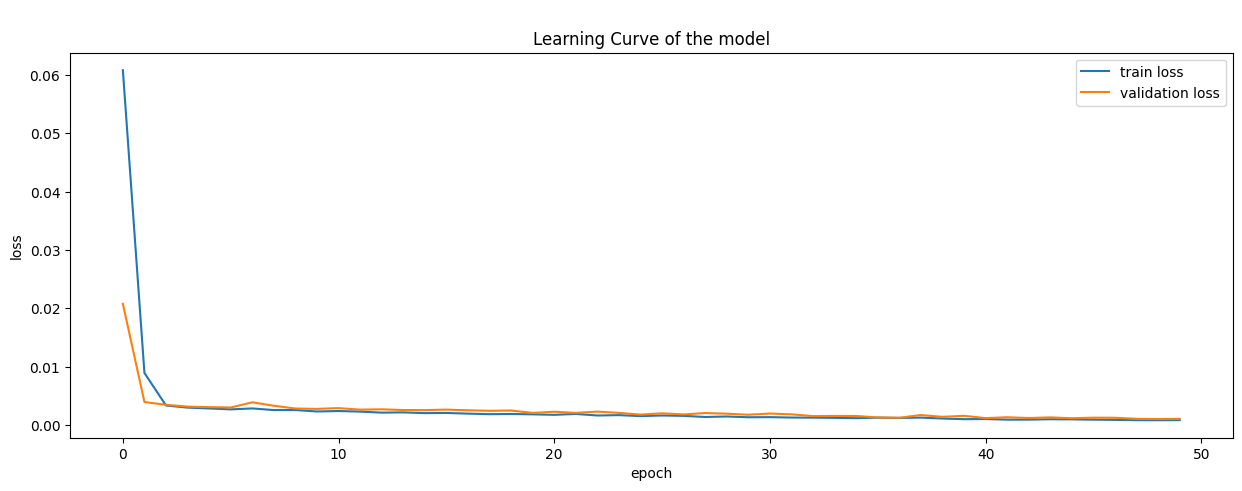


 MAE: 2612.0556640625, MAPE: 3.963156044483185, RMSE: 3407.4857299774567, R2: 0.9426596841150229, T-time: 00:01:24


 Training time 00:01:24

PREDICTIONS :  [[89092.484375], [91040.109375], [87901.1328125], [81400.03125], [73254.1953125], [64112.76171875], [56871.33203125], [51897.15234375], [50251.3671875], [50104.08984375], [49949.3984375], [49618.6796875], [46028.86328125], [46746.484375], [53937.1484375], [60619.05859375], [65950.90625], [67915.40625], [67828.8203125], [66569.375], [65963.046875], [65336.58203125], [64594.99609375], [75372.796875], [85454.875], [88891.9609375], [87172.984375], [82519.7890625], [75371.5234375], [65462.3515625], [55787.84765625], [49858.87109375], [48621.52734375], [48836.90234375], [49068.23046875], [48863.63671875], [45699.53125], [46916.9296875], [56378.58984375], [65158.47265625], [70509.921875], [72188.328125], [71911.2265625], [70373.8125], [69445.0078125], [69741.8828125], [69429.78125], [79637.3671875], [91009.4296875], [93894.5625], [91311.

In [ ]:
# Fold 1
model, history, t, scaler_load = build_WithoutOtherFeatures(train1, lookback, lookahead)
plot_history(history)
results = eval_WithoutOtherFeatures(model, test1, scaler_load)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1)
 Output: (3398, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:02:18


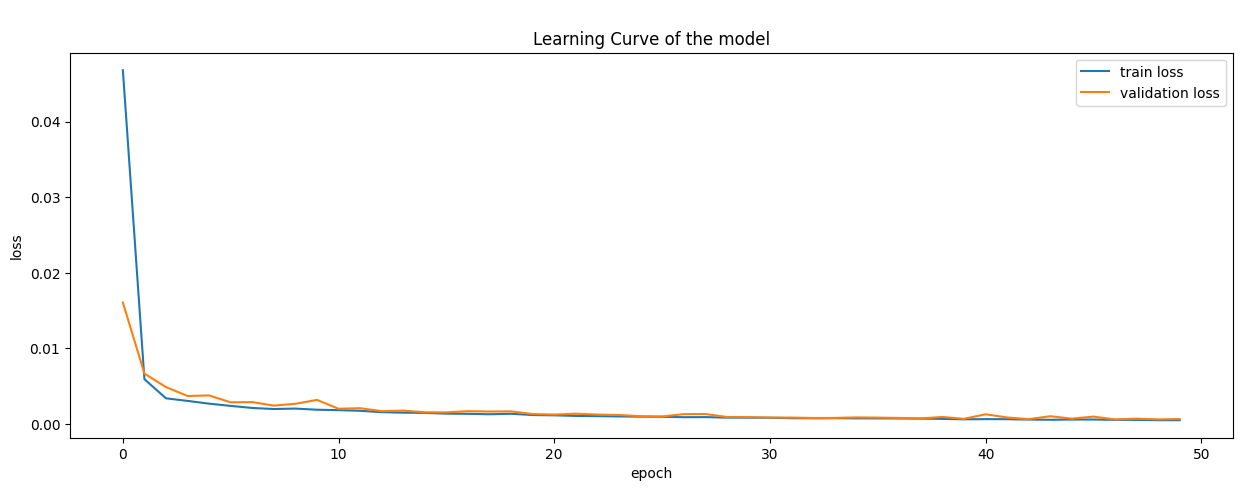


 MAE: 2846.002197265625, MAPE: 3.6260563880205154, RMSE: 3426.3385705443648, R2: 0.9654666251942214, T-time: 00:02:18


 Training time 00:02:18

PREDICTIONS :  [[74688.328125], [73585.3671875], [73775.6640625], [75980.5625], [82189.3359375], [93871.171875], [97822.46875], [95761.6328125], [96778.421875], [91027.9765625], [82113.96875], [77881.828125], [80297.0703125], [71219.1875], [57786.92578125], [48770.109375], [46289.62890625], [48317.09375], [50516.3984375], [55705.07421875], [61153.00390625], [65489.6640625], [68050.96875], [71655.03125], [73599.8828125], [72313.125], [72011.8046875], [74223.9921875], [83546.0], [97558.125], [99035.15625], [95217.09375], [95649.6953125], [90160.0546875], [82617.828125], [79002.1015625], [81209.625], [72095.671875], [59019.2265625], [49271.87890625], [46541.80078125], [48288.765625], [50268.69921875], [54304.171875], [59039.421875], [63294.3359375], [68369.2265625], [74178.3203125], [75268.03125], [72881.2734375], [72246.8828125], [74430.515625]

In [ ]:
# Fold 2
model, history, t, scaler_load = build_WithoutOtherFeatures(train2, lookback, lookahead)
plot_history(history)
results = eval_WithoutOtherFeatures(model, test2, scaler_load)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1)
 Output: (5145, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:03:15


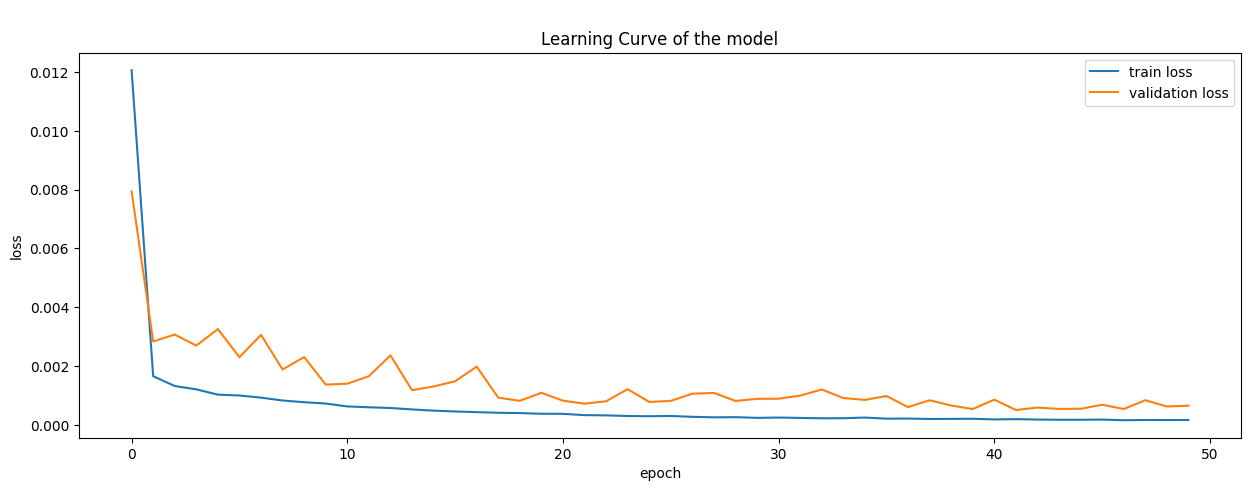


 MAE: 1097.5079345703125, MAPE: 1.5963803976774216, RMSE: 1471.4575257206714, R2: 0.9917957203170557, T-time: 00:03:15


 Training time 00:03:15

PREDICTIONS :  [[82316.4296875], [92655.0625], [98600.125], [99448.5625], [97891.5390625], [95779.3828125], [93286.5546875], [90100.25], [89777.53125], [92283.859375], [113006.9375], [121439.0234375], [117484.9140625], [111380.296875], [101472.1953125], [90370.2578125], [80895.3125], [72113.0234375], [67723.109375], [65012.48046875], [55151.26171875], [55078.69921875], [61943.01953125], [70814.0390625], [81041.234375], [90955.6171875], [95018.484375], [94865.9296875], [96223.9609375], [95913.1640625], [93888.3359375], [90303.921875], [89033.25], [92152.28125], [114127.25], [122417.0], [118121.6796875], [110972.46875], [100989.1328125], [90475.828125], [82202.375], [74029.1875], [67711.0546875], [66161.1015625], [53404.44921875], [53040.37109375], [59740.7890625], [67499.4921875], [76388.859375], [84554.2421875], [89716.078125], [91239.429687

In [ ]:
# Fold 3
model, history, t, scaler_load = build_WithoutOtherFeatures(train3, lookback, lookahead)
plot_history(history)
results = eval_WithoutOtherFeatures(model, test3, scaler_load)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1)
 Output: (6892, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:04:24


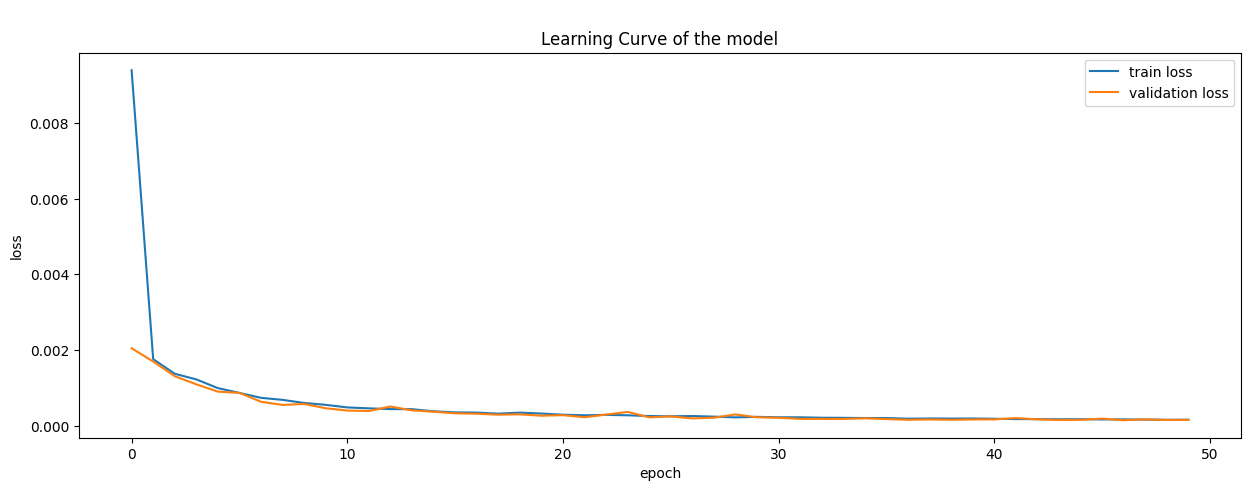


 MAE: 862.46435546875, MAPE: 1.4191637746989727, RMSE: 1135.738306125139, R2: 0.9934391670684724, T-time: 00:04:24


 Training time 00:04:24

PREDICTIONS :  [[51650.78125], [52862.87109375], [48980.44140625], [51960.3984375], [57657.83203125], [62672.62109375], [66971.5390625], [69891.2578125], [71020.8671875], [71152.71875], [69422.9765625], [69025.9453125], [69065.4296875], [75899.1171875], [94571.2890625], [94250.234375], [91632.953125], [84958.875], [73949.15625], [64271.0703125], [57719.69140625], [54433.25], [51650.10546875], [51308.62890625], [51999.8359375], [53571.76171875], [51406.3359375], [53647.3671875], [58414.15625], [63699.375], [67766.3984375], [70575.7421875], [72389.0], [71940.0078125], [71048.46875], [70062.1015625], [69365.328125], [77266.09375], [94673.671875], [94717.1640625], [91575.0078125], [85794.671875], [75588.9609375], [65578.90625], [59020.0390625], [53598.34765625], [50744.6796875], [50524.86328125], [50796.83203125], [54017.9296875], [52282.3046875], [

In [ ]:
# Fold 4
model, history, t, scaler_load = build_WithoutOtherFeatures(train4, lookback, lookahead)
plot_history(history)
results = eval_WithoutOtherFeatures(model, test4, scaler_load)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# MALAYSIA DATASET

In [18]:
path = "/content/drive/MyDrive/DATASETS/malaysia_all_data_for_paper_ori.csv"
dataset = pd.read_csv(path)
dataset["time"] = pd.to_datetime(dataset["time"])
dataset.set_index("time", inplace=True)
dataset.sort_index(inplace=True)
dataset["Date"] = dataset.index

In [20]:
import math
def split_dataset(data):
    # split into standard days (n*24)
    n_fold = 4
    fold_size = math.floor(data.shape[0]/(n_fold+1))
    train1, test1 = data[:fold_size], data[fold_size:fold_size*2]
    train2, test2 = data[:fold_size*2], data[fold_size*2:fold_size*3]
    train3, test3 = data[:fold_size*3], data[fold_size*3:fold_size*4]
    train4, test4 = data[:fold_size*4], data[fold_size*4:]
    # restructure into windows of daily data
    train1 = np.array(train1)
    test1 = np.array(test1)
    train2 = np.array(train2)
    test2 = np.array(test2)
    train3 = np.array(train3)
    test3 = np.array(test3)
    train4 = np.array(train4)
    test4 = np.array(test4)
    return train1, test1, train2, test2, train3, test3, train4, test4
train1, test1, train2, test2, train3, test3, train4, test4 = split_dataset(dataset.values)

print("4-Fold Train set are \n {} \n {} \n {} \n {} \nTest set shapes are \n {} \n {} \n {} \n {}".format(
    train1.shape,train2.shape,train3.shape,train4.shape,test1.shape,test2.shape,test3.shape,test4.shape))

def reframe(data, lookback, lookahead):
  x_load, x_temp, y = [],[],[]
  start = 0
  for _ in range(len(data)):
    feature_end = start + lookback
    label_end = feature_end + lookahead
    if label_end <= len(data):
      # historical load feature
      v = data[start:feature_end, 1]
      v = v.reshape(len(v),1)
      x_load.append(v)
      # temperature features
      v = data[start:feature_end, 0]
      v = v.reshape(len(v),1)
      x_temp.append(v)
      # load labels
      v = data[feature_end:label_end, 1]
      v = v.reshape(len(v),1)
      y.append(v)
    start += lookahead
  x_load, x_temp = np.asarray(x_load).astype('float32'), np.asarray(x_temp).astype('float32')
  y = np.asarray(y).astype('float32')
  return x_load, x_temp, y

def plotForDay(n, results):
  n=50
  plt.figure(figsize=(15,5))
  hours = [x for x in range(n)]
  plt.plot(hours, results['Predictions'].flatten()[:n], label='Predicted Load', marker='X',zorder=-10)
  plt.plot(hours, results['Actual'].flatten()[:n], label='Actual Load', marker='o',zorder=-10)
  plt.xticks(hours)
  # plt.title("Input day {} -> Predicted day {}.".format(results['Input_days'][n],results['Prediction_days'][n]))
  plt.ylabel('Load')
  plt.xlabel('Hours')
  plt.legend()
  plt.show()
  print("\n")

def evaluate_forecasts(actu, pred):
  # mae, mape, rmse, r2
  mae = mean_absolute_error(actu, pred)
  mape = mean_absolute_percentage_error(actu, pred)*100
  mse = mean_squared_error(actu, pred)
  rmse = math.sqrt(mse)
  r2 = r2_score(actu, pred)
  return mae, mape, rmse, r2

def plot_history(history):
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('\nLearning Curve of the model')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'validation loss'])
    plt.show()

lookahead = 1
lookback = 96
es = callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=30,verbose=1)
rop = callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.2,min_lr=0.001)
# mc = callbacks.ModelCheckpoint('best_model.h5',monitor='val_loss',mode='min',save_best_only=True)
verbose, epochs, batch_size = 1, 1, 32

4-Fold Train set are 
 (3503, 3) 
 (7006, 3) 
 (10509, 3) 
 (14012, 3) 
Test set shapes are 
 (3503, 3) 
 (3503, 3) 
 (3503, 3) 
 (3507, 3)


In [ ]:
_, _, cv1_actu = reframe(test1, lookback, lookahead)
cv1_actu = cv1_actu.ravel()
_, _, cv2_actu = reframe(test2, lookback, lookahead)
cv2_actu = cv2_actu.ravel()
_, _, cv3_actu = reframe(test3, lookback, lookahead)
cv3_actu = cv3_actu.ravel()
_, _, cv4_actu = reframe(test4, lookback, lookahead)
cv4_actu = cv4_actu.ravel()

In [ ]:
print(cv1_actu.tolist())

[29255.0, 29621.0, 28151.0, 27492.0, 27031.0, 27582.0, 27039.0, 30340.0, 40200.0, 44989.0, 45735.0, 45893.0, 45804.0, 45551.0, 45685.0, 45552.0, 45418.0, 47357.0, 50576.0, 49567.0, 39510.0, 35524.0, 33008.0, 26446.0, 25501.0, 24399.0, 23654.0, 23693.0, 24533.0, 26592.0, 34911.0, 45499.0, 56231.0, 62163.0, 62925.0, 62755.0, 62442.0, 63284.0, 63551.0, 60818.0, 51756.0, 48568.0, 50603.0, 48838.0, 39657.0, 34123.0, 30656.0, 28492.0, 26838.0, 25661.0, 24910.0, 24785.0, 25582.0, 28641.0, 35278.0, 45305.0, 55658.0, 60847.0, 62160.0, 60316.0, 59586.0, 60672.0, 61603.0, 59035.0, 50881.0, 47833.0, 50253.0, 48314.0, 39220.0, 33467.0, 30534.0, 28292.0, 26555.0, 25706.0, 25247.0, 25333.0, 26402.0, 30276.0, 40173.0, 51856.0, 62203.0, 69109.0, 69962.0, 66330.0, 65032.0, 66688.0, 68145.0, 65091.0, 53785.0, 49794.0, 51447.0, 49679.0, 40813.0, 35242.0, 31649.0, 34504.0, 32374.0, 31165.0, 30645.0, 31096.0, 32624.0, 37006.0, 42237.0, 53573.0, 64249.0, 70179.0, 70888.0, 70232.0, 67655.0, 67566.0, 67348.0, 

In [ ]:
print(cv2_actu.tolist())

[28864.0, 27577.0, 26817.0, 26589.0, 27665.0, 28362.0, 32844.0, 40560.0, 49816.0, 53985.0, 54570.0, 52119.0, 50085.0, 49833.0, 49557.0, 49067.0, 48051.0, 51275.0, 51325.0, 48533.0, 38981.0, 35592.0, 32854.0, 31043.0, 29938.0, 28450.0, 27577.0, 26771.0, 27184.0, 27507.0, 28700.0, 31800.0, 42262.0, 46310.0, 44728.0, 45802.0, 46005.0, 46272.0, 45765.0, 45071.0, 44935.0, 47310.0, 48445.0, 46686.0, 37408.0, 33163.0, 30808.0, 29100.0, 27751.0, 26818.0, 25864.0, 26131.0, 27986.0, 31184.0, 42244.0, 52816.0, 63838.0, 67783.0, 68935.0, 67676.0, 67770.0, 69212.0, 69163.0, 62800.0, 53170.0, 52361.0, 53082.0, 50822.0, 40065.0, 35687.0, 32865.0, 30745.0, 29611.0, 28514.0, 27536.0, 27528.0, 29428.0, 32790.0, 42805.0, 52931.0, 64318.0, 67879.0, 67306.0, 66001.0, 66201.0, 67033.0, 66588.0, 61607.0, 52111.0, 52174.0, 52738.0, 49866.0, 39852.0, 35495.0, 32085.0, 29893.0, 29079.0, 28011.0, 27404.0, 27458.0, 29318.0, 33021.0, 43069.0, 53219.0, 63698.0, 66556.0, 68458.0, 66312.0, 65789.0, 65536.0, 65215.0, 

In [ ]:
print(cv3_actu.tolist())

[29017.0, 27713.0, 27236.0, 27413.0, 28409.0, 33035.0, 43232.0, 53332.0, 63853.0, 66364.0, 66454.0, 64382.0, 63589.0, 64724.0, 63692.0, 58141.0, 50550.0, 50584.0, 51228.0, 48228.0, 38291.0, 34319.0, 31800.0, 30358.0, 29224.0, 27979.0, 27246.0, 27290.0, 28107.0, 29305.0, 31874.0, 39611.0, 50845.0, 52008.0, 51978.0, 49286.0, 46711.0, 46348.0, 45431.0, 44660.0, 44418.0, 47114.0, 48973.0, 45610.0, 36572.0, 33556.0, 31048.0, 29508.0, 27619.0, 26367.0, 25415.0, 25140.0, 25687.0, 26243.0, 26970.0, 30891.0, 41599.0, 44023.0, 44670.0, 44159.0, 41841.0, 41501.0, 41190.0, 40961.0, 39880.0, 43179.0, 44250.0, 41604.0, 33391.0, 30512.0, 27427.0, 25385.0, 24324.0, 23451.0, 23027.0, 23505.0, 25473.0, 30068.0, 39846.0, 49791.0, 61213.0, 62870.0, 69165.0, 67656.0, 68486.0, 67813.0, 65713.0, 59728.0, 51865.0, 51866.0, 51989.0, 48416.0, 38642.0, 34662.0, 31752.0, 30102.0, 28982.0, 27692.0, 27069.0, 27778.0, 29477.0, 34429.0, 45651.0, 56269.0, 64278.0, 65298.0, 64987.0, 64634.0, 65387.0, 66010.0, 56563.0, 

In [ ]:
print(cv4_actu.tolist())

[30182.0, 28835.0, 27859.0, 27486.0, 28367.0, 28466.0, 30598.0, 40298.0, 50971.0, 61150.0, 67455.0, 68834.0, 69086.0, 68799.0, 70188.0, 70088.0, 67527.0, 56773.0, 54109.0, 54366.0, 52421.0, 45610.0, 38495.0, 33920.0, 32562.0, 31223.0, 31202.0, 31432.0, 32933.0, 37262.0, 51539.0, 60709.0, 70832.0, 72465.0, 71385.0, 69281.0, 69394.0, 70024.0, 68520.0, 59063.0, 52991.0, 53589.0, 53826.0, 51329.0, 42071.0, 38174.0, 35148.0, 32894.0, 31865.0, 30714.0, 30653.0, 30276.0, 30725.0, 30927.0, 35132.0, 41761.0, 51452.0, 53773.0, 54130.0, 51406.0, 50178.0, 50465.0, 49453.0, 49151.0, 49599.0, 50687.0, 50726.0, 48519.0, 40121.0, 35870.0, 32894.0, 31112.0, 29877.0, 28720.0, 28469.0, 28355.0, 29242.0, 27925.0, 29105.0, 33574.0, 43744.0, 45529.0, 46165.0, 46074.0, 46214.0, 45497.0, 45565.0, 45161.0, 45791.0, 49210.0, 50483.0, 48541.0, 39710.0, 35235.0, 32380.0, 30021.0, 29057.0, 28015.0, 27957.0, 28725.0, 30382.0, 35450.0, 49341.0, 59633.0, 69887.0, 71562.0, 70581.0, 68699.0, 69360.0, 69694.0, 68226.0, 

# 1. Persistence

In [ ]:
def evaluate_persistence(test):
    test_x_load, test_x_temp, test_y = reframe(test, lookback, lookahead)
    test_x_load = test_x_load.reshape(test_x_load.shape[0],test_x_load.shape[1])
    yhat = test_x_load[:,-1].reshape(-1,1)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results


 MAE: 3075.7392578125, MAPE: 7.249400764703751, RMSE: 4499.017670558763, R2: 0.8995985371442917


PREDICTIONS :  [[29051.0], [29255.0], [29621.0], [28151.0], [27492.0], [27031.0], [27582.0], [27039.0], [30340.0], [40200.0], [44989.0], [45735.0], [45893.0], [45804.0], [45551.0], [45685.0], [45552.0], [45418.0], [47357.0], [50576.0], [49567.0], [39510.0], [35524.0], [33008.0], [26446.0], [25501.0], [24399.0], [23654.0], [23693.0], [24533.0], [26592.0], [34911.0], [45499.0], [56231.0], [62163.0], [62925.0], [62755.0], [62442.0], [63284.0], [63551.0], [60818.0], [51756.0], [48568.0], [50603.0], [48838.0], [39657.0], [34123.0], [30656.0], [28492.0], [26838.0], [25661.0], [24910.0], [24785.0], [25582.0], [28641.0], [35278.0], [45305.0], [55658.0], [60847.0], [62160.0], [60316.0], [59586.0], [60672.0], [61603.0], [59035.0], [50881.0], [47833.0], [50253.0], [48314.0], [39220.0], [33467.0], [30534.0], [28292.0], [26555.0], [25706.0], [25247.0], [25333.0], [26402.0], [30276.0], [40173.0], [5185

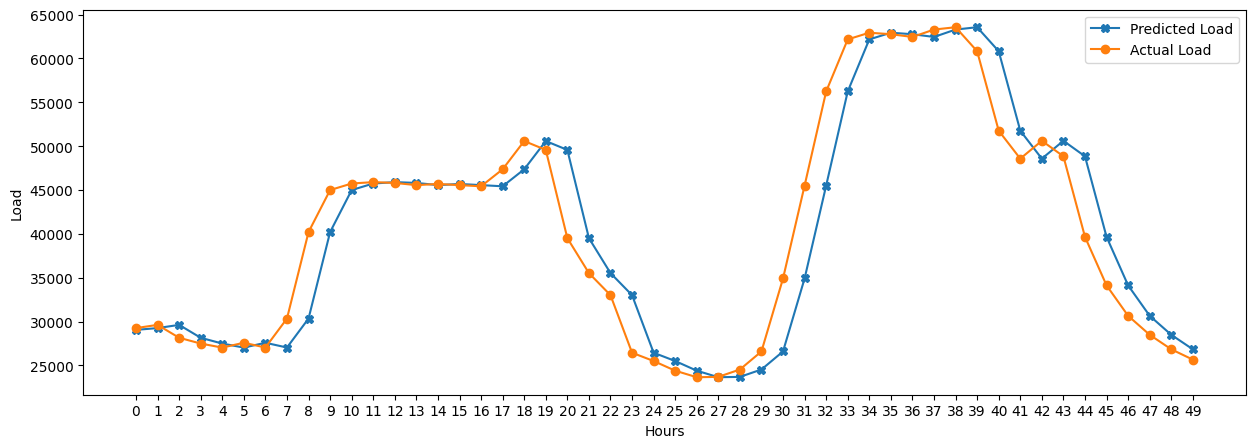

In [ ]:
# FOLD 1
results = evaluate_persistence(test1)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2']))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")
plotForDay(50, results)


 MAE: 3054.6455078125, MAPE: 7.177393138408661, RMSE: 4521.907783226014, R2: 0.8978061381084124


PREDICTIONS :  [[30434.0], [28864.0], [27577.0], [26817.0], [26589.0], [27665.0], [28362.0], [32844.0], [40560.0], [49816.0], [53985.0], [54570.0], [52119.0], [50085.0], [49833.0], [49557.0], [49067.0], [48051.0], [51275.0], [51325.0], [48533.0], [38981.0], [35592.0], [32854.0], [31043.0], [29938.0], [28450.0], [27577.0], [26771.0], [27184.0], [27507.0], [28700.0], [31800.0], [42262.0], [46310.0], [44728.0], [45802.0], [46005.0], [46272.0], [45765.0], [45071.0], [44935.0], [47310.0], [48445.0], [46686.0], [37408.0], [33163.0], [30808.0], [29100.0], [27751.0], [26818.0], [25864.0], [26131.0], [27986.0], [31184.0], [42244.0], [52816.0], [63838.0], [67783.0], [68935.0], [67676.0], [67770.0], [69212.0], [69163.0], [62800.0], [53170.0], [52361.0], [53082.0], [50822.0], [40065.0], [35687.0], [32865.0], [30745.0], [29611.0], [28514.0], [27536.0], [27528.0], [29428.0], [32790.0], [42805.0], [5293

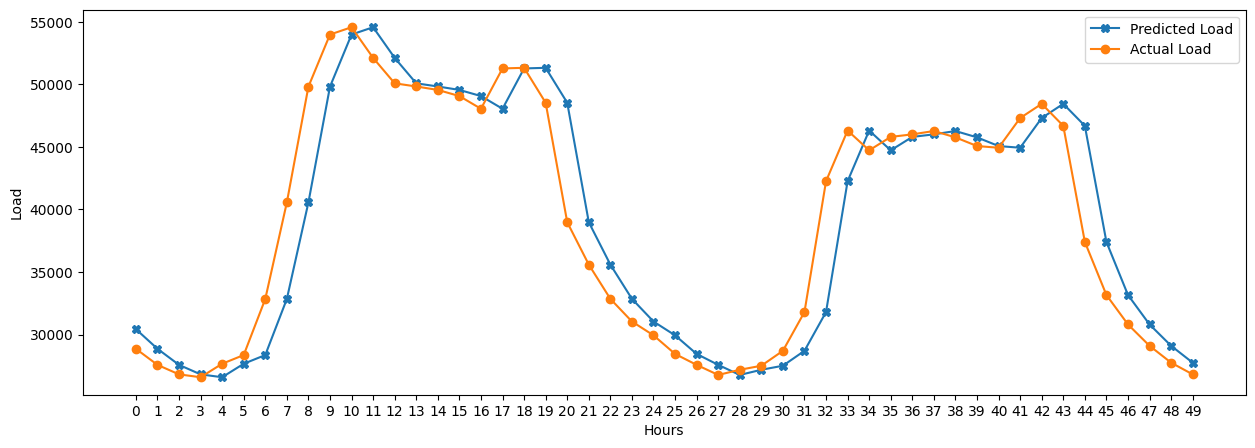

In [ ]:
# FOLD 2
results = evaluate_persistence(test2)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2']))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")
plotForDay(50, results)


 MAE: 3090.7939453125, MAPE: 7.717420905828476, RMSE: 4641.018853657029, R2: 0.8895205472969548


PREDICTIONS :  [[30111.0], [29017.0], [27713.0], [27236.0], [27413.0], [28409.0], [33035.0], [43232.0], [53332.0], [63853.0], [66364.0], [66454.0], [64382.0], [63589.0], [64724.0], [63692.0], [58141.0], [50550.0], [50584.0], [51228.0], [48228.0], [38291.0], [34319.0], [31800.0], [30358.0], [29224.0], [27979.0], [27246.0], [27290.0], [28107.0], [29305.0], [31874.0], [39611.0], [50845.0], [52008.0], [51978.0], [49286.0], [46711.0], [46348.0], [45431.0], [44660.0], [44418.0], [47114.0], [48973.0], [45610.0], [36572.0], [33556.0], [31048.0], [29508.0], [27619.0], [26367.0], [25415.0], [25140.0], [25687.0], [26243.0], [26970.0], [30891.0], [41599.0], [44023.0], [44670.0], [44159.0], [41841.0], [41501.0], [41190.0], [40961.0], [39880.0], [43179.0], [44250.0], [41604.0], [33391.0], [30512.0], [27427.0], [25385.0], [24324.0], [23451.0], [23027.0], [23505.0], [25473.0], [30068.0], [39846.0], [4979

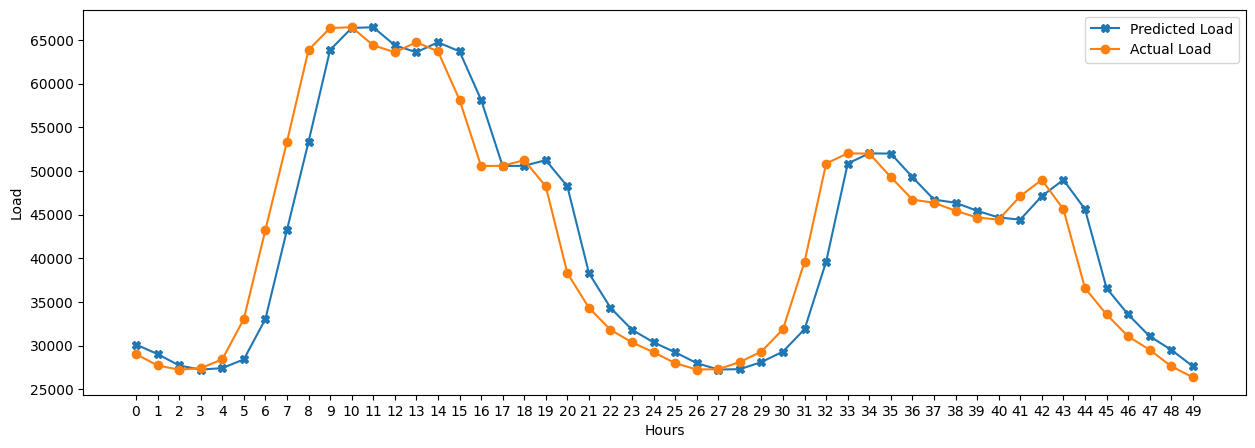

In [ ]:
# FOLD 3
results = evaluate_persistence(test3)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2']))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")
plotForDay(50, results)


 MAE: 3089.497314453125, MAPE: 7.009917497634888, RMSE: 4485.256514403608, R2: 0.8974525023218503


PREDICTIONS :  [[32816.0], [30182.0], [28835.0], [27859.0], [27486.0], [28367.0], [28466.0], [30598.0], [40298.0], [50971.0], [61150.0], [67455.0], [68834.0], [69086.0], [68799.0], [70188.0], [70088.0], [67527.0], [56773.0], [54109.0], [54366.0], [52421.0], [45610.0], [38495.0], [33920.0], [32562.0], [31223.0], [31202.0], [31432.0], [32933.0], [37262.0], [51539.0], [60709.0], [70832.0], [72465.0], [71385.0], [69281.0], [69394.0], [70024.0], [68520.0], [59063.0], [52991.0], [53589.0], [53826.0], [51329.0], [42071.0], [38174.0], [35148.0], [32894.0], [31865.0], [30714.0], [30653.0], [30276.0], [30725.0], [30927.0], [35132.0], [41761.0], [51452.0], [53773.0], [54130.0], [51406.0], [50178.0], [50465.0], [49453.0], [49151.0], [49599.0], [50687.0], [50726.0], [48519.0], [40121.0], [35870.0], [32894.0], [31112.0], [29877.0], [28720.0], [28469.0], [28355.0], [29242.0], [27925.0], [29105.0], [33

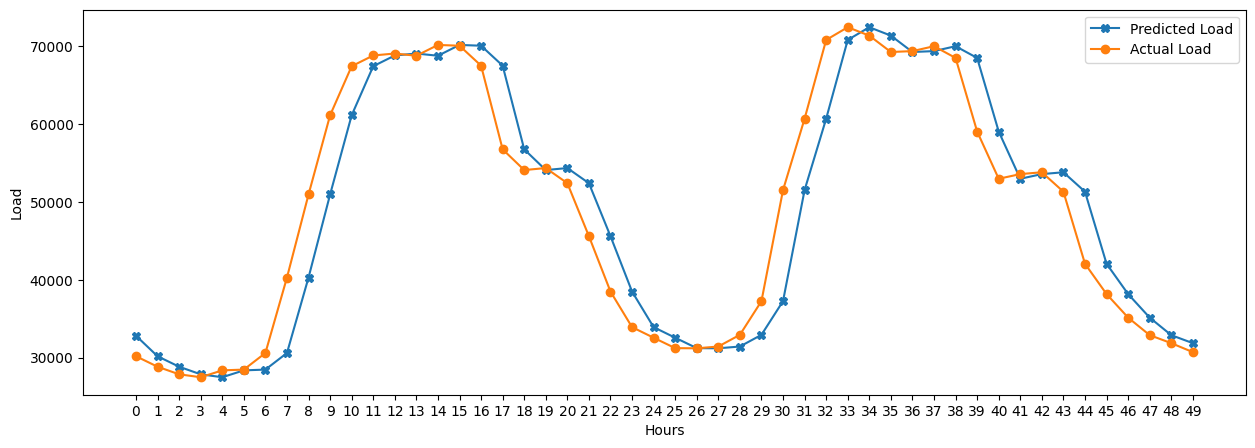

In [ ]:
# FOLD 4
results = evaluate_persistence(test4)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2']))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")
plotForDay(50, results)

# 2. ANN

In [ ]:
def build_ANN(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp = MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)
    train_x = np.concatenate((train_x_load,train_x_temp),axis=2)
    # define model
    inputs = layers.Input(shape=(train_x.shape[1], train_x.shape[2]))
    n_outputs = train_y.shape[1]
    print("Inputs: {}\nOutput: {}\n".format(inputs.shape,train_y.shape))

    x = layers.Flatten()(inputs)
    print("Flatten :",x.shape)
    x = layers.Dense(200, activation="relu")(x)
    print("Dense :",x.shape)
    x = layers.Dense(100, activation="relu")(x)
    print("Dense :",x.shape)
    x = layers.Dense(24, activation="relu")(x)
    print("Dense :",x.shape)
    x = layers.Dense(1)(x)
    print("Output :",x.shape)
    model = Model(inputs=inputs, outputs=x, name="ANN")
    model.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    history = model.fit(train_x, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    return model, history.history, t, scaler_load, scaler_temp

# load and temp combined for ANN [flatten as first layers of the model]
def evaluate_ann(model, test, scaler_load, scaler_temp):
    test_x_load, test_x_temp, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x = np.concatenate((test_x_load,test_x_temp),axis=2)
    yhat = model.predict(test_x)
    yhat = scaler_load.inverse_transform(yhat.reshape(-1, 1))
    print(yhat.shape)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Running Time
model, history, t, scaler_load, scaler_temp = build_ANN(train1, lookback, lookahead)

Inputs: (None, 96, 2)
Output: (3407, 1, 1)

Flatten : (None, 192)
Dense : (None, 200)
Dense : (None, 100)
Dense : (None, 24)
Output : (None, 1)
43/43 [==============================] - 2s 13ms/step - loss: 0.0267 - val_loss: 0.0103 - lr: 0.0010
Convergence time is : 00:00:02


Inputs: (None, 96, 2)
Output: (3408, 1, 1)

Flatten : (None, 192)
Dense100 : (None, 200)
Dense50 : (None, 100)
Dense50 : (None, 24)
Output : (None, 1)
Convergence time is : 00:00:41


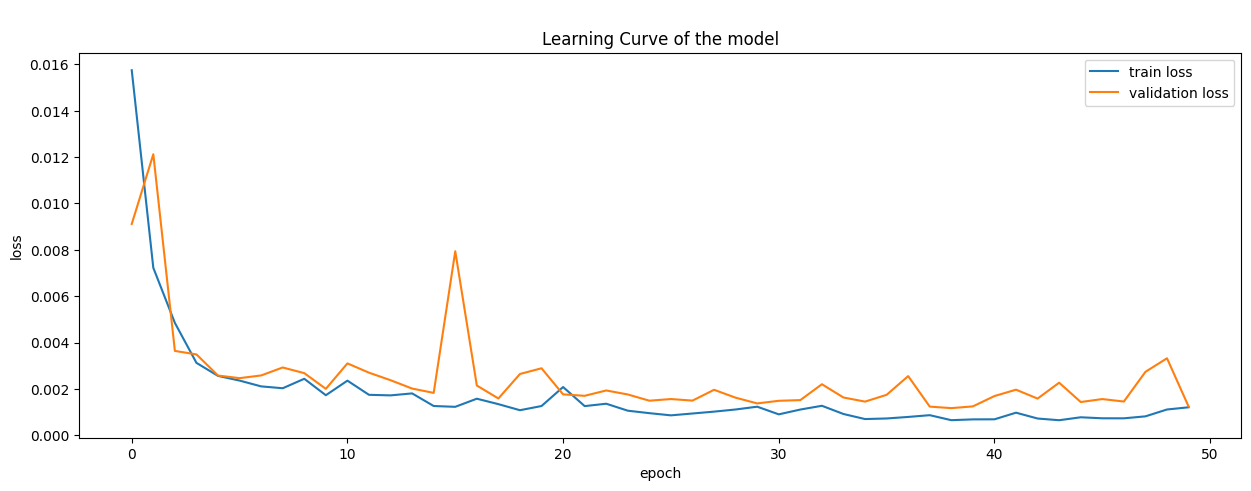

107/107 [==============================] - 0s 3ms/step
(3408, 1)

 MAE: 1362.594482421875, MAPE: 3.589169681072235, RMSE: 1875.1863907355983, R2: 0.9825581111242209, T-time: 00:00:41


 Training time 00:00:41

PREDICTIONS :  [[29557.95703125], [28305.28515625], [28829.603515625], [28253.443359375], [28340.22265625], [30631.689453125], [31988.95703125], [34119.328125], [39981.91796875], [45288.97265625], [47760.0546875], [47537.359375], [48206.109375], [48017.01953125], [49031.31640625], [48720.13671875], [47401.8515625], [48356.19140625], [51867.9375], [48831.17578125], [41930.29296875], [36872.3671875], [34360.06640625], [32142.013671875], [28398.185546875], [27083.8046875], [25511.2890625], [25303.51171875], [26994.0], [29682.501953125], [32865.85546875], [43821.87890625], [56935.73828125], [62181.87109375], [63484.0703125], [63032.67578125], [62541.25390625], [63158.5234375], [61990.859375], [59357.78125], [52549.98828125], [49639.09765625], [51196.5], [47805.875], [39607.5859375], 

In [ ]:
# FOLD 1
model, history, t, scaler_load, scaler_temp = build_ANN(train1, lookback, lookahead)
plot_history(history)
results = evaluate_ann(model, test1, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 2)
Output: (6912, 1, 1)

Flatten : (None, 192)
Dense100 : (None, 200)
Dense50 : (None, 100)
Dense50 : (None, 24)
Output : (None, 1)
Convergence time is : 00:00:41


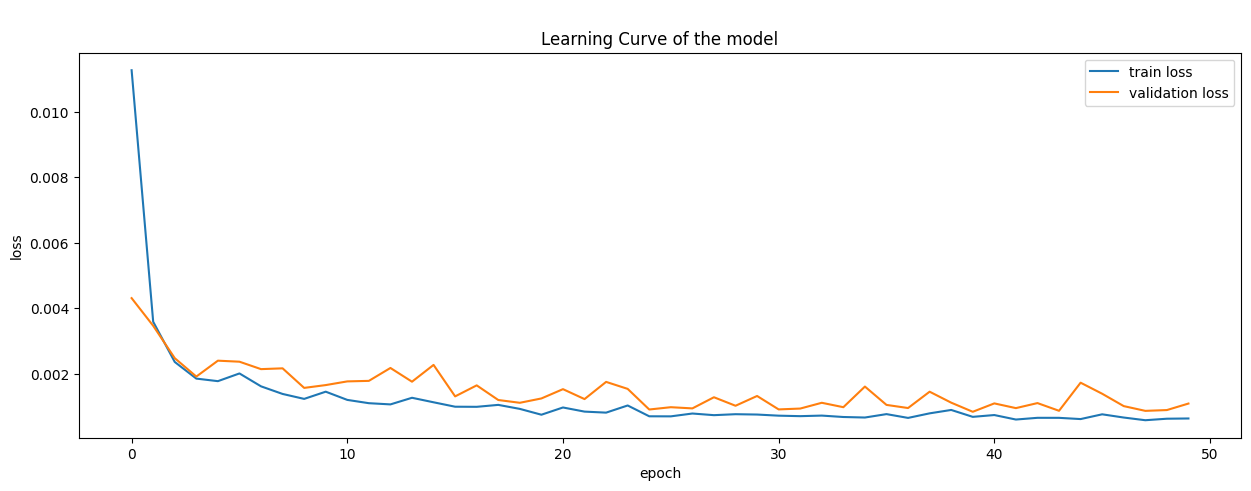

107/107 [==============================] - 0s 2ms/step
(3408, 1)

 MAE: 1474.424560546875, MAPE: 3.5217318683862686, RMSE: 2071.9126429461257, R2: 0.9785452083697597, T-time: 00:00:41


 Training time 00:00:41

PREDICTIONS :  [[28656.052734375], [27427.810546875], [27204.8046875], [25741.677734375], [26460.20703125], [27654.1171875], [29758.287109375], [39593.19140625], [48182.33984375], [53306.6796875], [53429.94921875], [52080.10546875], [50822.05859375], [49200.16796875], [48312.30078125], [47951.73828125], [47438.18359375], [48956.89453125], [51688.234375], [48444.4609375], [39964.98046875], [34218.0078125], [31688.77734375], [29925.90234375], [28894.78515625], [28468.51953125], [26604.306640625], [26024.46484375], [26683.23828125], [26499.087890625], [26767.26171875], [32230.267578125], [41300.328125], [46258.91796875], [47493.609375], [45964.15625], [45170.90625], [45942.52734375], [46706.46484375], [46324.44921875], [45230.984375], [47086.8671875], [49143.5703125], [45636.394531

In [ ]:
# FOLD 2
model, history, t, scaler_load, scaler_temp = build_ANN(train2, lookback, lookahead)
plot_history(history)
results = evaluate_ann(model, test2, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 2)
Output: (10416, 1, 1)

Flatten : (None, 192)
Dense100 : (None, 200)
Dense50 : (None, 100)
Dense50 : (None, 24)
Output : (None, 1)
Convergence time is : 00:01:22


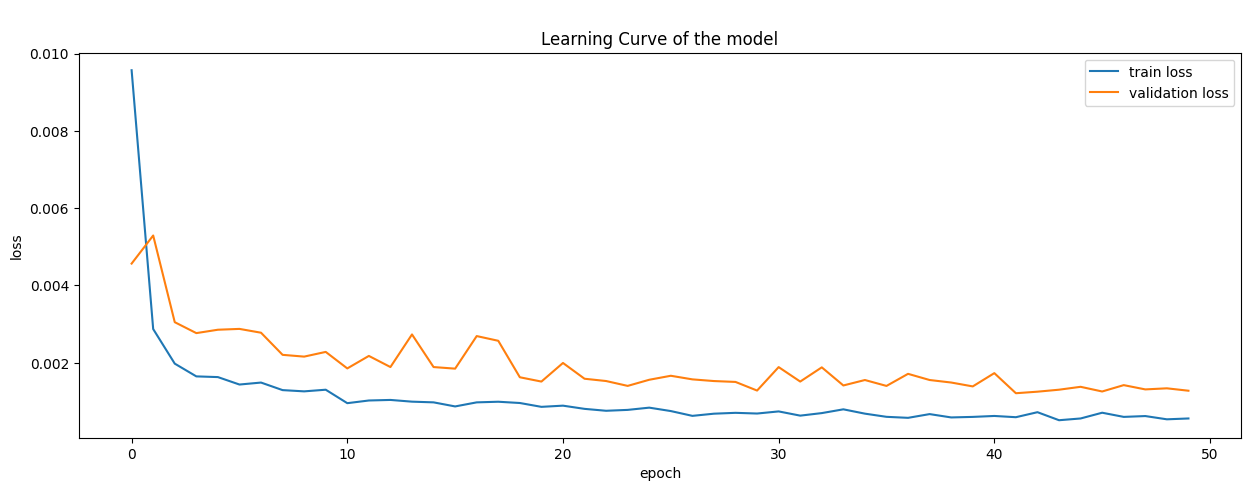

107/107 [==============================] - 0s 2ms/step
(3408, 1)

 MAE: 1403.6630859375, MAPE: 4.186656326055527, RMSE: 2312.2555005881163, R2: 0.9725762713955473, T-time: 00:01:22


 Training time 00:01:22

PREDICTIONS :  [[28430.640625], [28338.875], [26756.302734375], [26334.302734375], [27771.04296875], [30449.6015625], [41528.89453125], [54564.02734375], [63497.7578125], [67373.484375], [66321.7109375], [65001.81640625], [65014.140625], [65243.01171875], [64832.12109375], [60018.734375], [51018.70703125], [48712.30859375], [50417.01953125], [48407.12109375], [38741.08984375], [34174.4765625], [31489.05078125], [29300.443359375], [27890.673828125], [27186.0625], [26892.8125], [26438.2109375], [27541.96484375], [28741.68359375], [31410.103515625], [38620.2265625], [48650.5390625], [53110.54296875], [51757.73828125], [50037.0703125], [48397.21484375], [47202.9296875], [46075.8828125], [44743.1015625], [44500.8046875], [45510.25390625], [47536.0078125], [46578.734375], [36995.63671875

In [ ]:
# FOLD 3
model, history, t, scaler_load, scaler_temp = build_ANN(train3, lookback, lookahead)
plot_history(history)
results = evaluate_ann(model, test3, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 2)
Output: (13920, 1, 1)

Flatten : (None, 192)
Dense100 : (None, 200)
Dense50 : (None, 100)
Dense50 : (None, 24)
Output : (None, 1)
Convergence time is : 00:01:22


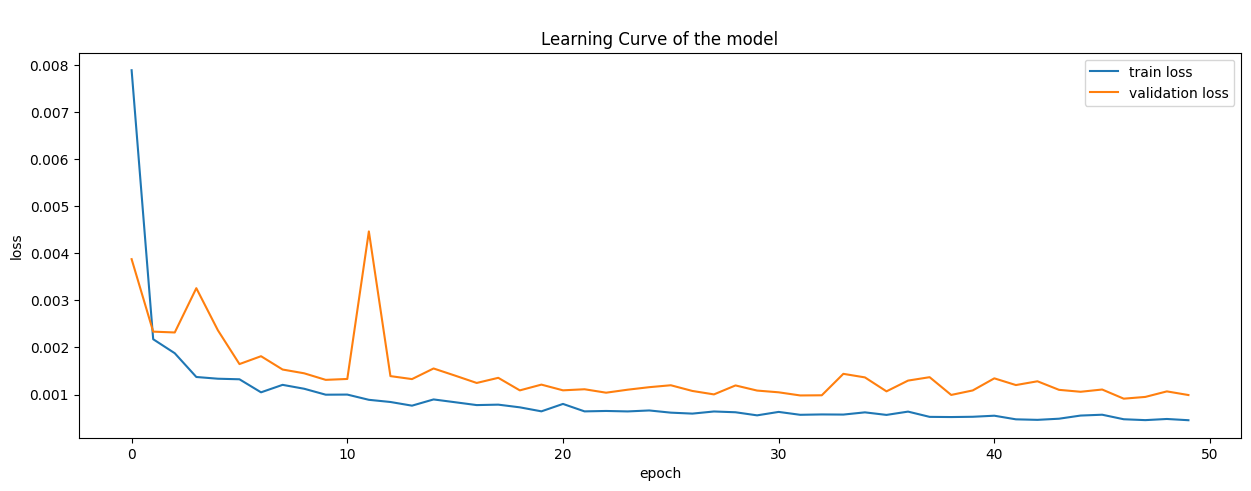

107/107 [==============================] - 0s 2ms/step
(3408, 1)

 MAE: 1563.6888427734375, MAPE: 3.688735142350197, RMSE: 2070.5669513444864, R2: 0.9781460935536438, T-time: 00:01:22


 Training time 00:01:22

PREDICTIONS :  [[30853.697265625], [28986.111328125], [27898.259765625], [27160.5078125], [26807.8125], [28338.978515625], [30232.466796875], [35369.7421875], [49721.4296875], [60697.37890625], [66526.1796875], [69147.875], [68013.078125], [68199.7734375], [68567.78125], [70399.1796875], [67531.7578125], [59635.38671875], [53764.71875], [54683.6171875], [52058.07421875], [44668.25390625], [37960.44921875], [33645.3125], [30365.396484375], [29225.91796875], [28805.384765625], [29232.794921875], [29450.865234375], [32281.048828125], [39405.5390625], [58507.671875], [69705.2578125], [75728.5], [75069.515625], [71922.8984375], [68254.15625], [67060.0625], [67874.7421875], [65096.83984375], [54622.16796875], [50700.95703125], [50344.5703125], [49392.96484375], [42492.6796875], [36625

In [ ]:
# FOLD 4
model, history, t, scaler_load, scaler_temp = build_ANN(train4, lookback, lookahead)
plot_history(history)
results = evaluate_ann(model, test4, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# 3. CNNLSTM

In [ ]:
def build_CNNLSTM(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp = MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    train_x = np.concatenate((train_x_load,train_x_temp),axis=2)
    inputs = layers.Input(shape=(train_x.shape[1], train_x.shape[2]))
    n_outputs = train_y.shape[1]
    # define model
    print("Input : {}".format(inputs.shape))
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same")(inputs)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    print("Conv1D : {}".format(x.shape))
    x = layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    print("Conv1D : {}".format(x.shape))
    x = layers.LSTM(64, return_sequences=False)(x)
    print("LSTM1 :",x.shape)
    x = layers.Dense(48)(x)
    x = layers.Activation("relu")(x)
    print("Dense : ",x.shape)
    x = layers.Dense(1)(x)
    print("outputs :",x.shape)
    model = Model(inputs=inputs, outputs=x, name="CNNLSTM")
    model.compile(loss='mse', optimizer='adam')
    # fit network
    start_time = time.time()
    history = model.fit(train_x, train_y, validation_split = 0.2,
                        epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    return model, history.history, t, scaler_load, scaler_temp

# load and temp combined for ANN [flatten as first layers of the model]
def eval_CNNLSTM(model, test, scaler_load, scaler_temp):
    test_x_load, test_x_temp, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x = np.concatenate((test_x_load,test_x_temp),axis=2)
    yhat = model.predict(test_x)
    yhat = scaler_load.inverse_transform(yhat.reshape(-1, 1))
    print(yhat.shape)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Running Time
model, history, t, scaler_load, scaler_temp  = build_CNNLSTM(train1, lookback, lookahead)

Input : (None, 96, 2)
Conv1D : (None, 48, 32)
Conv1D : (None, 24, 64)
LSTM1 : (None, 64)
Dense :  (None, 48)
outputs : (None, 1)
43/43 [==============================] - 6s 28ms/step - loss: 0.0808 - val_loss: 0.0508 - lr: 0.0010
Convergence time is : 00:00:06


Input : (None, 96, 2)
Conv1D(32) : (None, 48, 32)
Conv1D(64) : (None, 24, 64)
LSTM1 : (None, 64)
Dense :  (None, 48)
outputs : (None, 1)
Convergence time is : 00:00:45


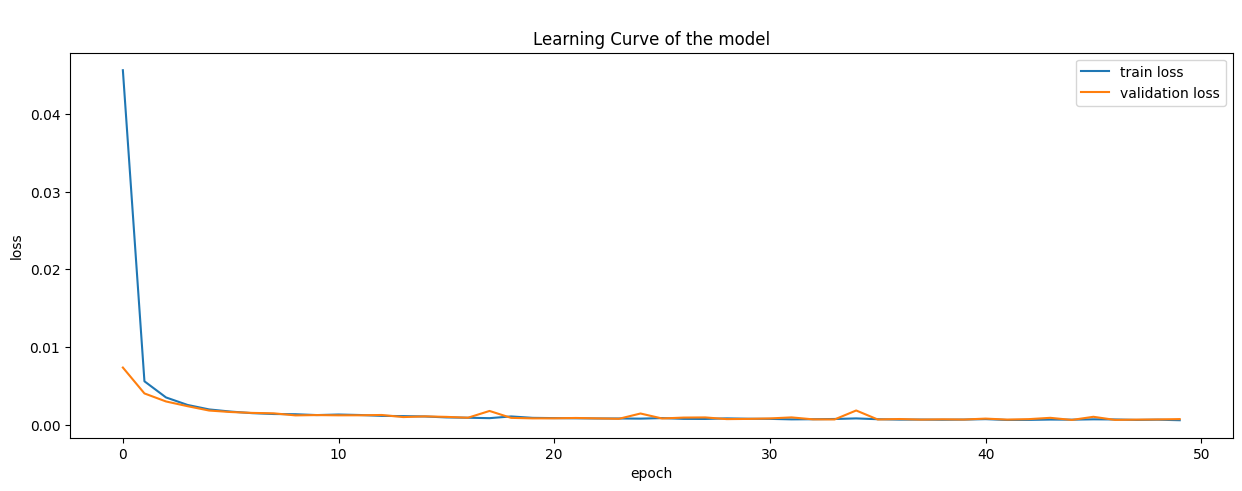

107/107 [==============================] - 1s 3ms/step
(3408, 1)

 MAE: 1073.8836669921875, MAPE: 2.70076934248209, RMSE: 1485.2574692624844, R2: 0.9890577118349168, T-time: 00:00:45


 Training time 00:00:45

PREDICTIONS :  [[27496.9140625], [27932.935546875], [29044.58984375], [27255.265625], [27610.404296875], [27457.291015625], [29294.908203125], [28990.078125], [38513.39453125], [46296.625], [45641.359375], [45435.4140625], [45323.75390625], [44971.31640625], [45260.984375], [45679.9765625], [44925.08984375], [46725.5859375], [49266.50390625], [48514.56640625], [40285.03515625], [33001.7578125], [31793.080078125], [29674.1875], [25248.224609375], [24294.759765625], [23586.419921875], [23642.87109375], [24945.69140625], [26828.388671875], [32726.056640625], [46344.88671875], [56514.6953125], [63314.99609375], [63792.4140625], [62016.5625], [61177.76171875], [62582.9140625], [63327.05859375], [60243.453125], [51248.26171875], [47265.4921875], [49709.08203125], [48291.6953125], [3822

In [ ]:
# Fold 1
model, history, t, scaler_load, scaler_temp  = build_CNNLSTM(train1, lookback, lookahead)
plot_history(history)
results = eval_CNNLSTM(model, test1, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Input : (None, 96, 2)
Conv1D(32) : (None, 48, 32)
Conv1D(64) : (None, 24, 64)
LSTM1 : (None, 64)
Dense :  (None, 48)
outputs : (None, 1)
Convergence time is : 00:00:57


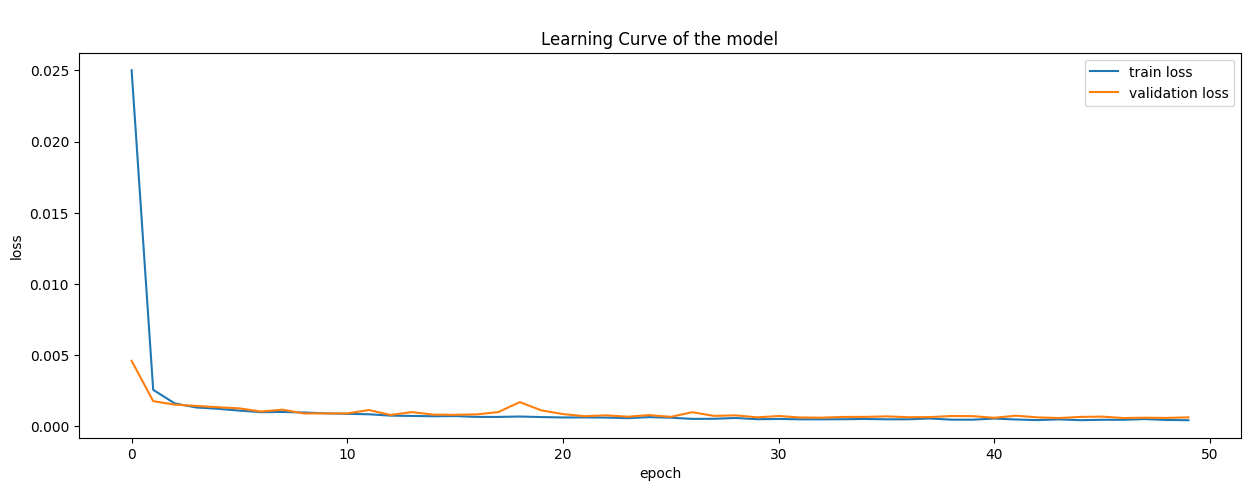

107/107 [==============================] - 2s 5ms/step
(3408, 1)

 MAE: 1265.2940673828125, MAPE: 3.0971361324191093, RMSE: 1920.6819752369208, R2: 0.981562913958343, T-time: 00:00:57


 Training time 00:00:57

PREDICTIONS :  [[28102.212890625], [27308.765625], [26332.30859375], [26328.419921875], [26823.376953125], [30434.619140625], [31116.400390625], [43345.01171875], [50278.33203125], [53578.8125], [53365.76171875], [52541.859375], [49743.9921875], [48435.93359375], [49034.6015625], [48733.1953125], [47520.99609375], [48853.26953125], [52768.4140625], [48289.91015625], [39242.1015625], [34209.13671875], [32048.978515625], [29792.6171875], [28592.892578125], [28210.2890625], [27109.91015625], [26769.40625], [26553.0625], [28141.78125], [28997.451171875], [35149.36328125], [41567.953125], [47431.28125], [46992.56640625], [44218.13671875], [45830.484375], [46617.4609375], [45724.03515625], [44130.265625], [43523.22265625], [45246.28125], [48316.12890625], [45592.89453125], [37665.2226

In [ ]:
# Fold 2
model, history, t, scaler_load, scaler_temp  = build_CNNLSTM(train2, lookback, lookahead)
plot_history(history)
results = eval_CNNLSTM(model, test2, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Input : (None, 96, 2)
Conv1D(32) : (None, 48, 32)
Conv1D(64) : (None, 24, 64)
LSTM1 : (None, 64)
Dense :  (None, 48)
outputs : (None, 1)
Convergence time is : 00:02:25


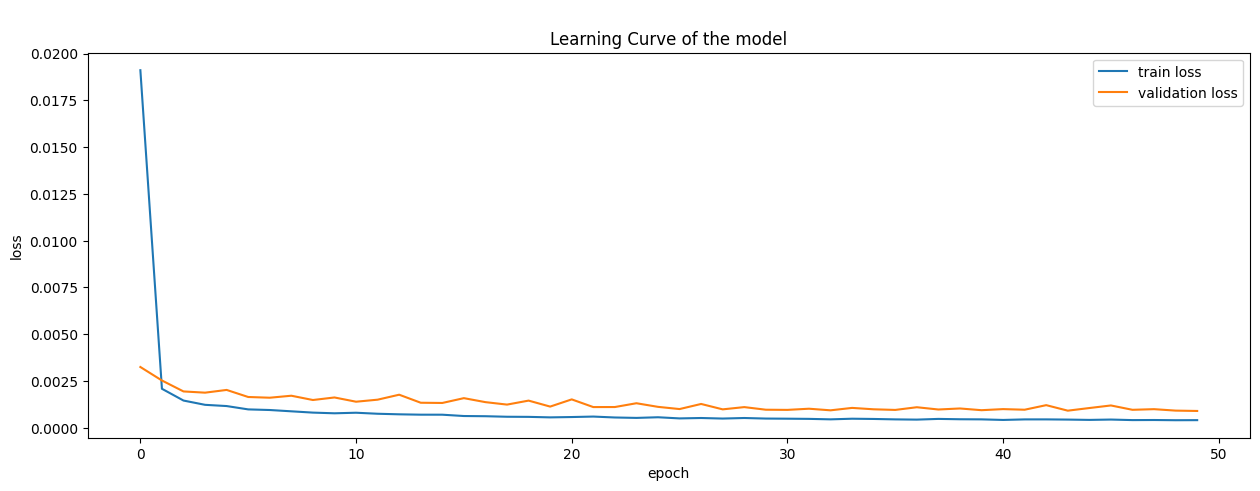

107/107 [==============================] - 1s 3ms/step
(3408, 1)

 MAE: 1154.3316650390625, MAPE: 3.7084493786096573, RMSE: 2100.338187054647, R2: 0.9773726708452807, T-time: 00:02:25


 Training time 00:02:25

PREDICTIONS :  [[28883.740234375], [28350.65625], [27156.189453125], [26834.6171875], [28457.390625], [30641.94921875], [42777.36328125], [53483.31640625], [62602.8828125], [66227.640625], [65836.7734375], [64304.88671875], [63554.3046875], [63742.1953125], [64085.890625], [59598.671875], [49938.3203125], [49511.79296875], [51646.62890625], [49151.390625], [38864.71484375], [34367.6015625], [31983.142578125], [30302.875], [29289.138671875], [28308.08203125], [27238.888671875], [27088.646484375], [28235.79296875], [29836.798828125], [32378.625], [39610.609375], [50350.9296875], [56962.01171875], [52703.99609375], [50088.7421875], [48294.8515625], [46336.62890625], [46869.71484375], [45131.13671875], [43830.546875], [45218.10546875], [49445.125], [47018.796875], [37583.19921875], 

In [ ]:
# Fold 3
model, history, t, scaler_load, scaler_temp  = build_CNNLSTM(train3, lookback, lookahead)
plot_history(history)
results = eval_CNNLSTM(model, test3, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Input : (None, 96, 2)
Conv1D(32) : (None, 48, 32)
Conv1D(64) : (None, 24, 64)
LSTM1 : (None, 64)
Dense :  (None, 48)
outputs : (None, 1)
Convergence time is : 00:02:24


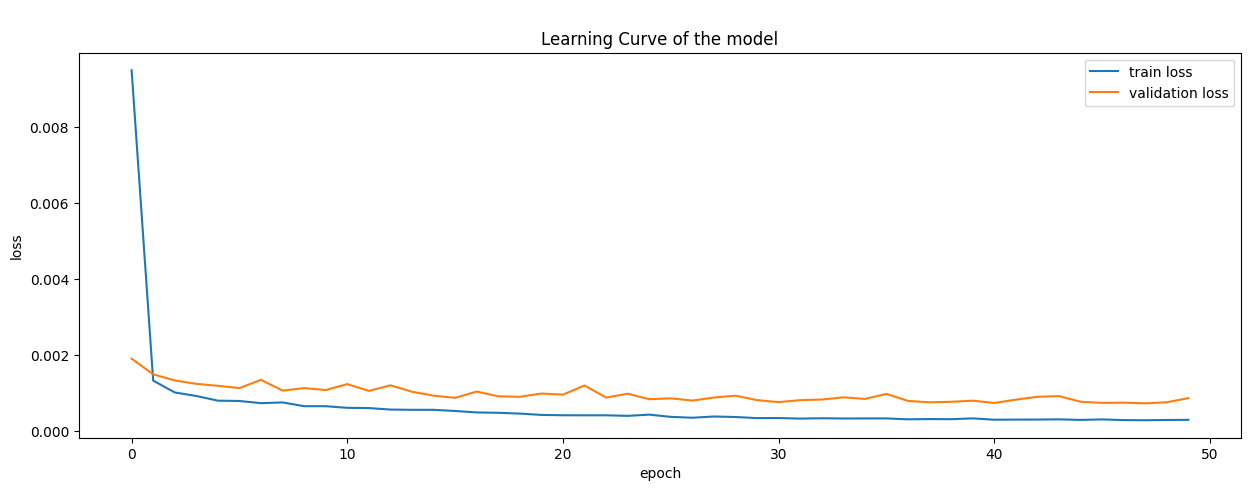

107/107 [==============================] - 1s 4ms/step
(3408, 1)

 MAE: 1249.2322998046875, MAPE: 2.8511689975857735, RMSE: 1738.7991545891664, R2: 0.984588340963326, T-time: 00:02:24


 Training time 00:02:24

PREDICTIONS :  [[31101.357421875], [29354.26953125], [27703.466796875], [26812.47265625], [27411.919921875], [29562.96875], [30965.681640625], [36103.9921875], [49668.4609375], [60506.1171875], [66904.1796875], [68851.390625], [68839.0390625], [70561.640625], [70619.4296875], [70697.046875], [67878.359375], [61371.30078125], [55089.66796875], [54564.83203125], [53731.4921875], [46867.43359375], [40321.6171875], [34761.94921875], [31868.771484375], [30644.984375], [29618.642578125], [30030.513671875], [31923.736328125], [35610.33203125], [46261.01171875], [59905.15625], [68111.8984375], [73289.7734375], [73564.78125], [71793.9296875], [71133.671875], [71201.40625], [70078.0546875], [63414.69140625], [53607.1640625], [53646.53515625], [54986.75], [52293.31640625], [43042.2265625],

In [ ]:
# Fold 4
model, history, t, scaler_load, scaler_temp  = build_CNNLSTM(train4, lookback, lookahead)
plot_history(history)
results = eval_CNNLSTM(model, test4, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# 4. MSCNN

In [ ]:
def build_MS_CNN(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp = MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    train_x = np.concatenate((train_x_load,train_x_temp),axis=2)
    # define model
    inputs = layers.Input(shape=(train_x.shape[1], train_x.shape[2]))
    n_outputs = train_y.shape[1]
    print("Inputs: {}\nOutput: {}\n".format(inputs.shape,train_y.shape))

    print("BLOCK 1")
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1)(inputs)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 1", x.shape)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 2", x.shape)
    x = layers.Conv1D(filters=24, kernel_size=3, dilation_rate=4, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=4)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 3", x.shape)

    print("BLOCK 2")
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 1", x.shape)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 2", x.shape)
    x = layers.Conv1D(filters=24, kernel_size=3, dilation_rate=4, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=4)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    print("conv1d 3", x.shape)

    # print("BLOCK 3")
    # x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1, activation="relu")(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.05)(x)
    # x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=1)(x)
    # x = layers.Activation('relu')(x)
    # x = layers.BatchNormalization()(x)
    # print("conv1d 1", x.shape)
    # x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2, activation="relu")(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.05)(x)
    # x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=2)(x)
    # x = layers.Activation('relu')(x)
    # x = layers.BatchNormalization()(x)
    # print("conv1d 2", x.shape)
    # x = layers.Conv1D(filters=24, kernel_size=3, dilation_rate=4, activation="relu")(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.05)(x)
    # x = layers.Conv1D(filters=24, kernel_size=5, dilation_rate=4)(x)
    # x = layers.Activation('relu')(x)
    # x = layers.BatchNormalization()(x)
    # print("conv1d 3", x.shape)

    x =layers.Flatten()(x)
    print("Flatten",x.shape)
    x = layers.Dense(24, activation="relu")(x)
    print("Dense ", x.shape)
    outputs = layers.Dense(1)(x)
    print("Output :",x.shape)
    model = Model(inputs=inputs, outputs=outputs, name="MS-CNN")
    model.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    history = model.fit(train_x, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    return model, history.history, t, scaler_load, scaler_temp

def eval_MS_CNN(model, test, scaler_load, scaler_temp):
    test_x_load, test_x_temp, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x = np.concatenate((test_x_load,test_x_temp),axis=2)
    yhat = model.predict(test_x)
    yhat = scaler_load.inverse_transform(yhat.reshape(-1, 1))
    print(yhat.shape)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Running Time
model, history, t, scaler_load, scaler_temp = build_MS_CNN(train1, lookback, lookahead)

Inputs: (None, 96, 2)
Output: (3407, 1, 1)

BLOCK 1
conv1d 1 (None, 92, 24)
conv1d 2 (None, 76, 24)
conv1d 3 (None, 52, 24)
BLOCK 2
conv1d 1 (None, 44, 24)
conv1d 2 (None, 28, 24)
conv1d 3 (None, 4, 24)
Flatten (None, 96)
Dense  (None, 24)
Output : (None, 24)
43/43 [==============================] - 16s 53ms/step - loss: 0.8685 - val_loss: 0.1247 - lr: 0.0010
Convergence time is : 00:00:15


Inputs: (None, 96, 2)
Output: (3408, 1, 1)

BLOCK 1
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
BLOCK 2
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
Flatten (None, 1824)
Dense  (None, 24)
Output : (None, 24)
Convergence time is : 00:00:41


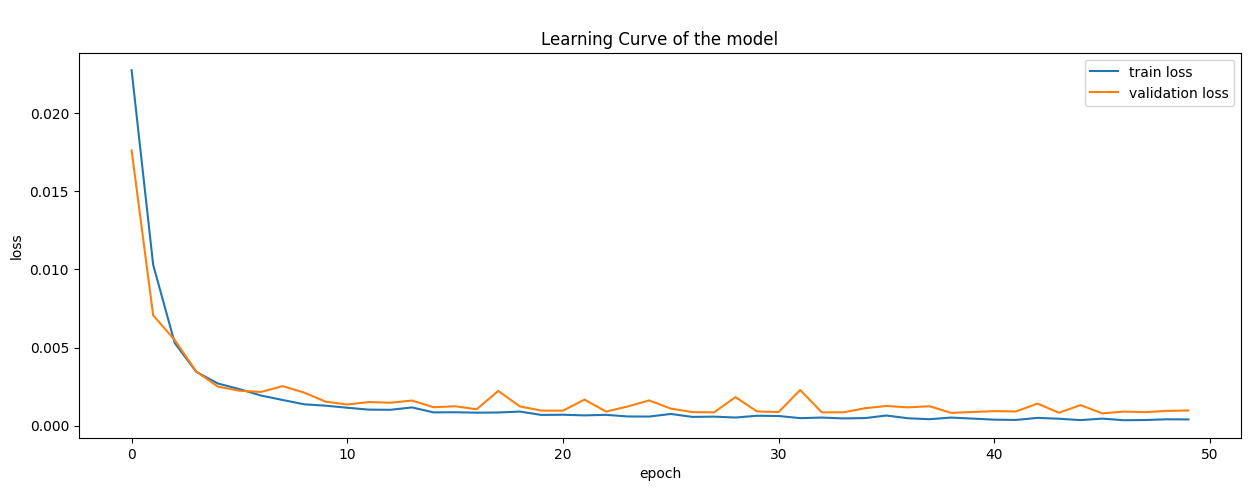

107/107 [==============================] - 0s 2ms/step
(3408, 1)

 MAE: 1333.5035400390625, MAPE: 3.461872786283493, RMSE: 1743.2582998511723, R2: 0.9849260139901896, T-time: 00:00:41


 Training time 00:00:41

PREDICTIONS :  [[29421.078125], [28779.201171875], [29085.7421875], [27717.734375], [27828.15625], [28331.142578125], [30280.1171875], [32732.951171875], [39173.9375], [43805.59765625], [45093.61328125], [45676.78515625], [46095.48828125], [46594.62890625], [46138.78125], [45768.6640625], [44700.28125], [46378.21484375], [49619.73828125], [48678.10546875], [41342.99609375], [36178.5390625], [33462.8359375], [32078.35546875], [28766.91015625], [26972.748046875], [25843.138671875], [25737.3984375], [26120.525390625], [28987.3984375], [32612.27734375], [42880.73828125], [54603.5625], [59789.8671875], [62339.65234375], [60657.41015625], [58797.8046875], [60261.125], [62326.7109375], [60196.11328125], [50986.48046875], [49209.99609375], [49472.5390625], [48179.59375], [37901.46484375

In [ ]:
# Fold 1
model, history, t, scaler_load, scaler_temp = build_MS_CNN(train1, lookback, lookahead)
plot_history(history)
results = eval_MS_CNN(model, test1, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 2)
Output: (6912, 1, 1)

BLOCK 1
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
BLOCK 2
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
Flatten (None, 1824)
Dense  (None, 24)
Output : (None, 24)
Convergence time is : 00:00:39


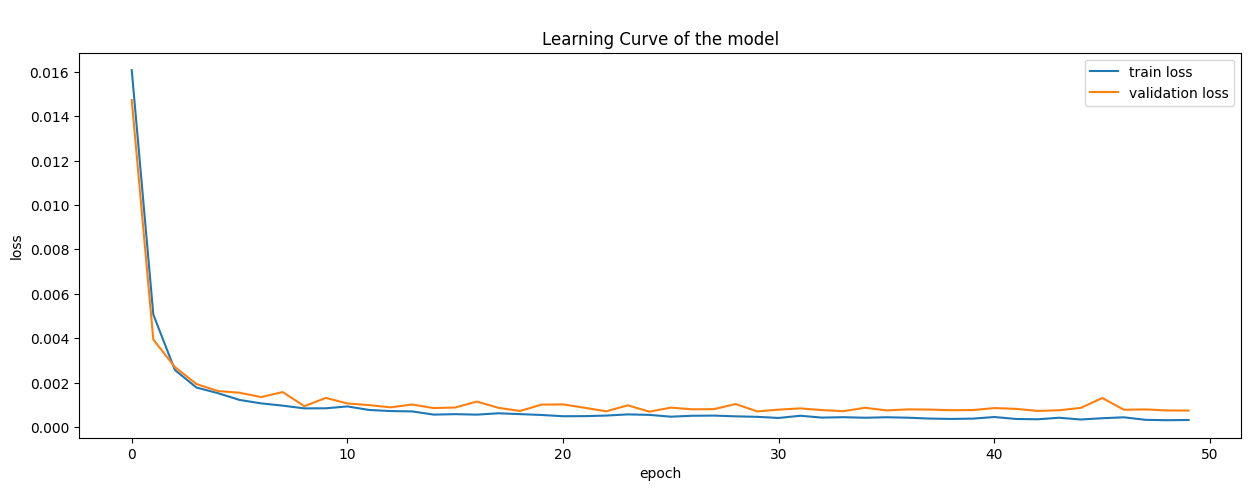

107/107 [==============================] - 0s 2ms/step
(3408, 1)

 MAE: 1247.3218994140625, MAPE: 3.094921261072159, RMSE: 1838.4972803896121, R2: 0.9831069763960201, T-time: 00:00:39


 Training time 00:00:39

PREDICTIONS :  [[28866.326171875], [27485.7109375], [26617.66796875], [26487.328125], [27314.21484375], [29780.451171875], [30950.775390625], [40646.59765625], [49137.1953125], [52694.64453125], [54230.37890625], [53077.796875], [49788.15234375], [49568.84765625], [49631.82421875], [48240.56640625], [48807.52734375], [49046.6875], [51882.6484375], [49272.8515625], [39594.6953125], [34175.06640625], [30881.53125], [30261.794921875], [29580.322265625], [27800.921875], [27130.50390625], [26667.310546875], [26553.80859375], [27537.04296875], [27860.662109375], [32537.84765625], [41274.6171875], [45711.01171875], [46528.12109375], [44670.63671875], [44391.41796875], [45751.78515625], [45375.890625], [43756.72265625], [43676.17578125], [46690.05859375], [49844.4765625], [45106.7109375

In [ ]:
# Fold 2
model, history, t, scaler_load, scaler_temp = build_MS_CNN(train2, lookback, lookahead)
plot_history(history)
results = eval_MS_CNN(model, test2, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 2)
Output: (10416, 1, 1)

BLOCK 1
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
BLOCK 2
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
Flatten (None, 1824)
Dense  (None, 24)
Output : (None, 24)
Convergence time is : 00:01:23


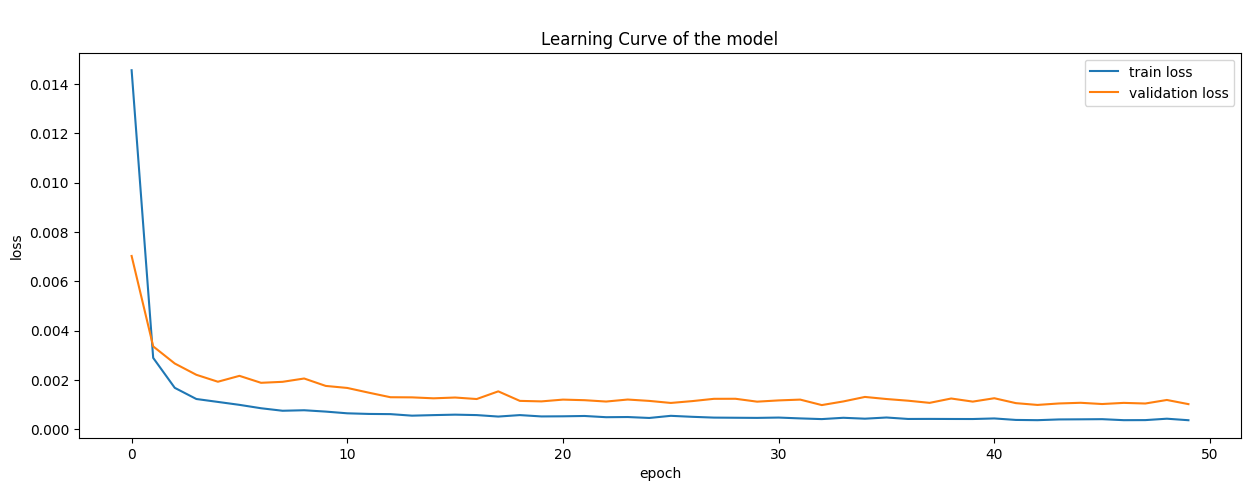

107/107 [==============================] - 0s 2ms/step
(3408, 1)

 MAE: 1168.5408935546875, MAPE: 3.6803994327783585, RMSE: 2090.410605598814, R2: 0.9775860679951008, T-time: 00:01:23


 Training time 00:01:23

PREDICTIONS :  [[28853.72265625], [28024.15234375], [26479.671875], [27056.220703125], [28153.330078125], [31285.30078125], [42404.08984375], [53407.30859375], [62152.10546875], [65824.3359375], [65803.6328125], [64345.3515625], [63804.40234375], [64295.24609375], [63808.515625], [58198.66796875], [50847.92578125], [49589.01953125], [50673.546875], [47891.953125], [38261.59765625], [34203.10546875], [32005.767578125], [30080.537109375], [28706.6875], [27869.0234375], [26744.68359375], [26481.83984375], [27124.728515625], [29877.912109375], [34042.140625], [40322.61328125], [49257.703125], [54351.953125], [52974.73828125], [50540.6953125], [48486.28515625], [46552.56640625], [45126.9921875], [44435.79296875], [44558.046875], [45805.94921875], [48164.8125], [44797.58203125], [3633

In [ ]:
# Fold 3
model, history, t, scaler_load, scaler_temp = build_MS_CNN(train3, lookback, lookahead)
plot_history(history)
results = eval_MS_CNN(model, test3, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 2)
Output: (13920, 1, 1)

BLOCK 1
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
BLOCK 2
conv1d 1 (None, 92, 24)
conv1d 2 (None, 84, 24)
conv1d 3 (None, 76, 24)
Flatten (None, 1824)
Dense  (None, 24)
Output : (None, 24)
Convergence time is : 00:01:22


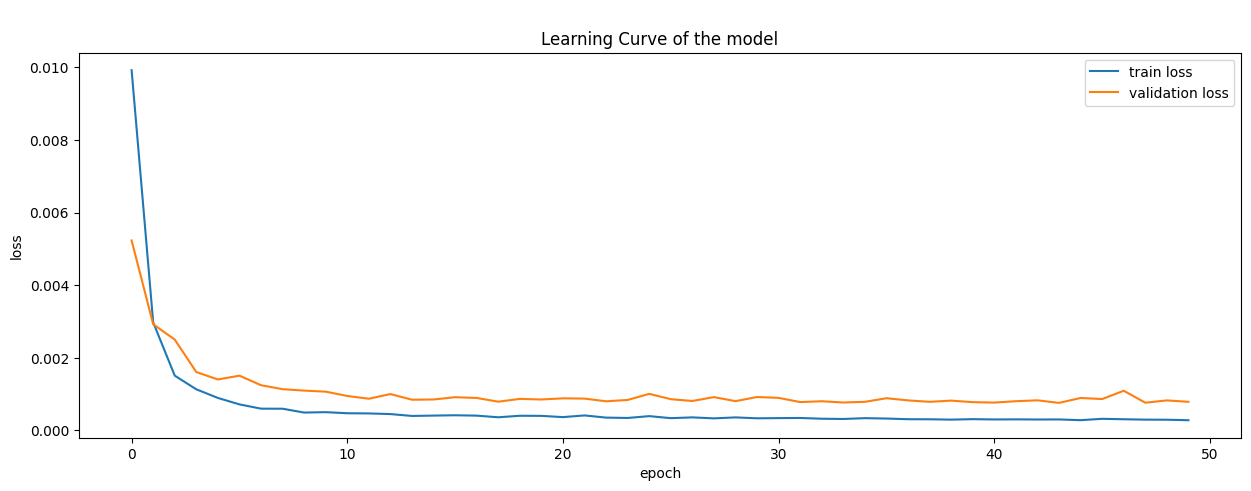

107/107 [==============================] - 0s 2ms/step
(3408, 1)

 MAE: 1203.1468505859375, MAPE: 2.854490652680397, RMSE: 1675.7551282929137, R2: 0.9856856510275702, T-time: 00:01:22


 Training time 00:01:22

PREDICTIONS :  [[30498.521484375], [29155.119140625], [27756.669921875], [27872.5546875], [27583.44921875], [30147.25390625], [32232.255859375], [39569.1875], [52680.6640625], [60083.08203125], [66135.625], [68606.703125], [67711.1640625], [67442.84375], [69149.0625], [70410.140625], [66139.9765625], [56703.0390625], [54373.40234375], [54316.3203125], [52038.078125], [45665.46875], [38778.5859375], [32277.20703125], [31066.83203125], [31625.78125], [30852.53125], [31569.138671875], [31922.8203125], [34589.2109375], [41665.03125], [63671.828125], [72006.8984375], [76618.859375], [75141.375], [71062.609375], [69680.3359375], [68671.0078125], [68636.2578125], [61240.0703125], [52245.32421875], [52339.08203125], [54174.125], [50126.0234375], [44100.26171875], [37886.0390625], [34348

In [ ]:
# Fold 4
model, history, t, scaler_load, scaler_temp = build_MS_CNN(train4, lookback, lookahead)
plot_history(history)
results = eval_MS_CNN(model, test4, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# 5. DeepEnergy

In [ ]:
# train the model
def build_DeepEnergy(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp = MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)
    train_x = np.concatenate((train_x_load,train_x_temp),axis=2)
    inputs = layers.Input(shape=(train_x.shape[1], train_x.shape[2]))
    n_outputs = train_y.shape[1]
    # define model

    # CONV => RELU => BatchNorm => POOL layer set
    x = layers.Conv1D(filters=64, kernel_size=5, padding="same")(inputs)
    print("Conv1D : {}".format(x.shape))
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    print("MaxPooling1D : {}".format(x.shape))
    # CONV => RELU => BatchNorm => POOL layer set
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same")(x)
    print("Conv1D : {}".format(x.shape))
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    print("MaxPooling1D : {}".format(x.shape))
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same")(x)
    print("Conv1D : {}".format(x.shape))
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    print("MaxPooling1D : {}".format(x.shape))
    # Flatten
    x = layers.Flatten()(x)
    print("Flatten : {}".format(x.shape))
    # Set of FC => RELU => BatchNorm => Dropout => outputs
    x = layers.Dense(units = 32)(x)
    print("Dense : ",x.shape)
    x = layers.Activation("relu")(x)
    x = layers.Dense(1)(x)
    print("Dense : ",x.shape)

    model = Model(inputs=inputs, outputs=x, name="DeepEnergy")
    model.compile(loss='mse', optimizer='adam')
    # fit network
    start_time = time.time()
    history = model.fit(train_x, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    return model, history.history, t, scaler_load, scaler_temp

def eval_DeepEnergy(model, test, scaler_load, scaler_temp):
    test_x_load, test_x_temp, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)
    test_x = np.concatenate((test_x_load,test_x_temp),axis=2)
    yhat = model.predict(test_x)
    yhat = scaler_load.inverse_transform(yhat.reshape(-1, 1))
    print(yhat.shape)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Running Time
model, history, t, scaler_load, scaler_temp = build_DeepEnergy(train1, lookback, lookahead)

Conv1D : (None, 96, 64)
MaxPooling1D : (None, 48, 64)
Conv1D : (None, 48, 32)
MaxPooling1D : (None, 24, 32)
Conv1D : (None, 24, 32)
MaxPooling1D : (None, 12, 32)
Flatten : (None, 384)
Dense :  (None, 32)
Dense :  (None, 1)
43/43 [==============================] - 4s 20ms/step - loss: 0.0959 - val_loss: 0.0178 - lr: 0.0010
Convergence time is : 00:00:04


Conv1D64 : (None, 96, 64)
MaxPooling1D : (None, 48, 64)
Conv1D32 : (None, 48, 32)
MaxPooling1D : (None, 24, 32)
Flatten : (None, 768)
Dense :  (None, 32)
Dense :  (None, 1)
Convergence time is : 00:00:20


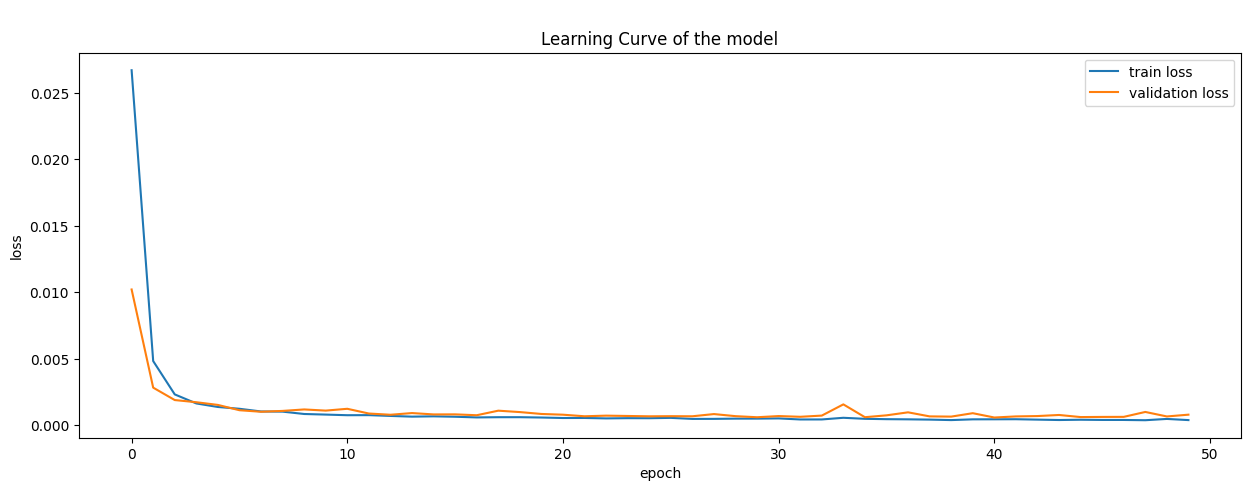

107/107 [==============================] - 0s 2ms/step
(3408, 1)

 MAE: 1086.9169921875, MAPE: 2.7348166331648827, RMSE: 1483.6956392737698, R2: 0.989080713173039, T-time: 00:00:20


 Training time 00:00:20

PREDICTIONS :  [[29500.126953125], [29995.77734375], [30030.193359375], [28987.75], [28769.240234375], [28814.859375], [30612.86328125], [31069.70703125], [39423.86328125], [47179.48828125], [45619.234375], [45685.06640625], [45649.69140625], [45854.9296875], [46036.75390625], [45259.78125], [45464.96484375], [47165.09765625], [51176.3359375], [49892.68359375], [42205.54296875], [35912.70703125], [33094.625], [31292.685546875], [25805.7421875], [25425.37890625], [24761.388671875], [24321.58203125], [24916.529296875], [28242.7890625], [33618.33203125], [47447.6796875], [58737.23046875], [63770.1875], [64641.26953125], [63938.36328125], [63677.30859375], [63982.72265625], [63736.6640625], [60917.484375], [51890.11328125], [48653.1640625], [49782.40234375], [48631.359375], [39111.7968

In [ ]:
# Fold 1
model, history, t, scaler_load, scaler_temp = build_DeepEnergy(train1, lookback, lookahead)
plot_history(history)
results = eval_DeepEnergy(model, test1, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Conv1D64 : (None, 96, 64)
MaxPooling1D : (None, 48, 64)
Conv1D32 : (None, 48, 32)
MaxPooling1D : (None, 24, 32)
Flatten : (None, 768)
Dense :  (None, 32)
Dense :  (None, 1)
Convergence time is : 00:00:41


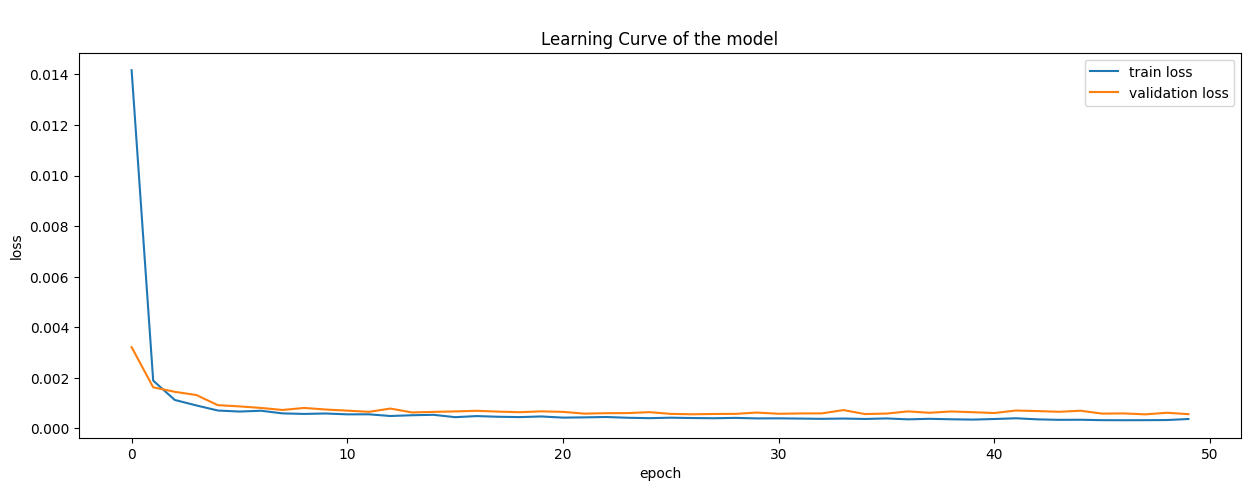

107/107 [==============================] - 0s 2ms/step
(3408, 1)

 MAE: 1154.107421875, MAPE: 2.779097482562065, RMSE: 1727.8367255038886, R2: 0.985079381544508, T-time: 00:00:41


 Training time 00:00:41

PREDICTIONS :  [[29707.30859375], [27665.68359375], [26720.6875], [26932.255859375], [27659.4296875], [30378.244140625], [31616.58984375], [42507.48828125], [50050.09765625], [53041.32421875], [54386.33984375], [52684.88671875], [50278.46484375], [49539.546875], [48846.44140625], [48421.3671875], [47822.69921875], [48592.96875], [52989.078125], [49345.140625], [39559.5703125], [35187.58984375], [31952.126953125], [30134.9296875], [29505.62890625], [28362.62109375], [27030.89453125], [26973.2578125], [26756.87109375], [27487.6328125], [28878.98046875], [34853.859375], [41060.1640625], [46818.63671875], [46422.2734375], [44227.01171875], [45032.8125], [45607.48046875], [45156.97265625], [44234.77734375], [44203.9140625], [46579.7890625], [49140.21875], [46276.46484375], [38389.76171875

In [ ]:
# Fold 2
model, history, t, scaler_load, scaler_temp = build_DeepEnergy(train2, lookback, lookahead)
plot_history(history)
results = eval_DeepEnergy(model, test2, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Conv1D64 : (None, 96, 64)
MaxPooling1D : (None, 48, 64)
Conv1D32 : (None, 48, 32)
MaxPooling1D : (None, 24, 32)
Flatten : (None, 768)
Dense :  (None, 32)
Dense :  (None, 1)
Convergence time is : 00:00:54


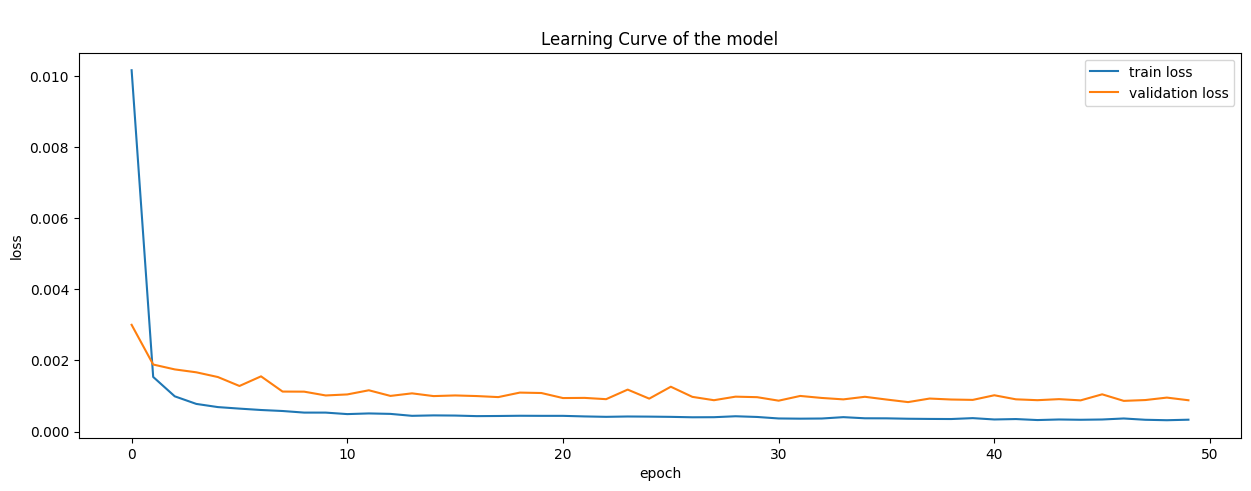

107/107 [==============================] - 0s 2ms/step
(3408, 1)

 MAE: 1174.55078125, MAPE: 3.7017326802015305, RMSE: 2173.1137798099758, R2: 0.9757774560416111, T-time: 00:00:54


 Training time 00:00:54

PREDICTIONS :  [[28906.234375], [28168.880859375], [27062.978515625], [26618.166015625], [29380.69140625], [30881.115234375], [41880.34765625], [53136.23046875], [63429.2734375], [66392.84375], [65203.23046875], [64289.8984375], [63498.3359375], [64190.171875], [64495.921875], [58104.65625], [49866.83203125], [49045.62890625], [50937.2890625], [48005.1796875], [38213.140625], [33703.27734375], [31194.38671875], [29685.82421875], [28553.384765625], [28037.60546875], [27132.400390625], [27370.677734375], [28750.412109375], [30705.775390625], [33573.91015625], [39459.203125], [50539.953125], [54826.83984375], [51537.25390625], [49673.3046875], [47349.6015625], [46643.8671875], [45840.32421875], [44444.03515625], [44703.828125], [46271.51953125], [48246.08203125], [46672.1953125], [3672

In [ ]:
# Fold 3
model, history, t, scaler_load, scaler_temp = build_DeepEnergy(train3, lookback, lookahead)
plot_history(history)
results = eval_DeepEnergy(model, test3, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Conv1D64 : (None, 96, 64)
MaxPooling1D : (None, 48, 64)
Conv1D32 : (None, 48, 32)
MaxPooling1D : (None, 24, 32)
Flatten : (None, 768)
Dense :  (None, 32)
Dense :  (None, 1)
Convergence time is : 00:01:22


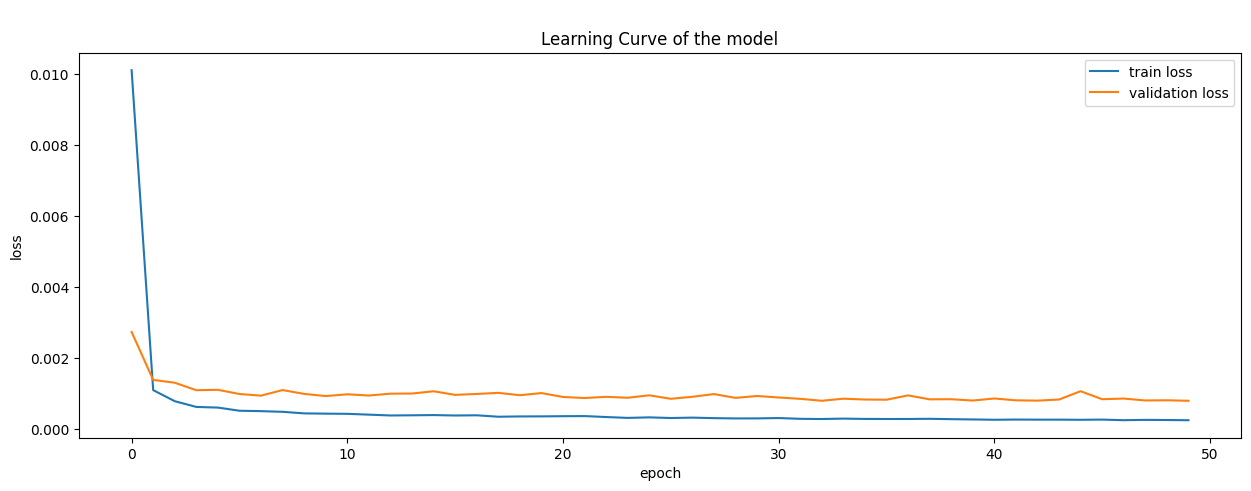

107/107 [==============================] - 0s 2ms/step
(3408, 1)

 MAE: 1271.154541015625, MAPE: 3.044726885855198, RMSE: 1742.1159548089788, R2: 0.9845294900523659, T-time: 00:01:22


 Training time 00:01:22

PREDICTIONS :  [[30816.80859375], [29634.431640625], [28213.068359375], [26791.208984375], [26959.42578125], [28364.564453125], [32394.916015625], [37539.6328125], [51241.5625], [59756.1171875], [66720.046875], [68658.6328125], [67786.7890625], [68259.7421875], [68901.4453125], [69235.7578125], [65071.4375], [59059.6484375], [52903.02734375], [54335.34765625], [52080.359375], [44174.34375], [38435.12890625], [32535.751953125], [30723.45703125], [30796.021484375], [29703.490234375], [29565.208984375], [31142.716796875], [37088.19140625], [46084.05078125], [62752.73046875], [69469.4140625], [74232.53125], [72395.6015625], [69189.6796875], [69185.5078125], [68508.8515625], [68263.7265625], [61858.16015625], [50563.91796875], [51430.203125], [51593.9453125], [50372.78125], [42379.597

In [ ]:
# Fold 4
model, history, t, scaler_load, scaler_temp = build_DeepEnergy(train4, lookback, lookahead)
plot_history(history)
results = eval_DeepEnergy(model, test4, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# 6. PConvLSTM (Proposed Model)

In [ ]:
def build_P_C2DLSTM(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp  = MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    n_steps, rows, cols, n_features, n_outputs  = 4, 1, 24, 1, train_y.shape[1]

    train_x_load = train_x_load.reshape(-1,n_steps,rows,cols,n_features)
    train_x_temp = train_x_temp.reshape(-1,n_steps,rows,cols,n_features)
    # define model
    load_inputs = layers.Input(shape=(train_x_load.shape[1], train_x_load.shape[2],train_x_load.shape[3],train_x_load.shape[4]))
    temp_inputs = layers.Input(shape=(train_x_temp.shape[1], train_x_temp.shape[2],train_x_temp.shape[3],train_x_temp.shape[4]))
    print("Inputs:\n Load {},\n Temp {}\n Output: {}\n".format(load_inputs.shape,temp_inputs.shape,train_y.shape))

    x1 = layers.ConvLSTM2D(filters=32, kernel_size=(1,5))(load_inputs)
    print("ConvLSTM2D : {}".format(x1.shape))
    x1 = layers.Flatten()(x1)
    print("Flatten : ", x1.shape)

    x2 = layers.ConvLSTM2D(filters=12, kernel_size=(1,3))(temp_inputs)
    print("ConvLSTM2D : {}".format(x2.shape))
    x2 = layers.Flatten()(x2)
    print("Flatten : ", x2.shape)

    print("CONCATENATING {}, {}".format(x1.shape,x2.shape))
    x = layers.Concatenate()([x1,x2])
    print("Concate ",x.shape)
    x = layers.Dense(24, activation="relu")(x)
    print("D24 :",x.shape)
    x = layers.Dense(1)(x)
    print("outputs :",x.shape)
    model = Model(inputs=[load_inputs, temp_inputs], outputs=x, name="P-CLSTM2D")
    model.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    # mc = callbacks.ModelCheckpoint('convlstm2d.h5',monitor='val_loss',mode='min',save_best_only=True)
    history = model.fit([train_x_load, train_x_temp],
                        train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    # model = load_model('convlstm2d.h5')
    return model, history.history, t, scaler_load, scaler_temp

# load and temp inputs series in ConvLSTM2D
def eval_P_C2DLSTM(model, test, scaler_load, scaler_temp):
    test_x_load, test_x_temp, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)

    n_steps, rows, cols, n_features  = 4, 1, 24, 1

    test_x_load = test_x_load.reshape(-1,n_steps,rows,cols,n_features)
    test_x_temp = test_x_temp.reshape(-1,n_steps,rows,cols,n_features)

    yhat = model.predict([test_x_load, test_x_temp], verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Running Time
model, history, t, scaler_load, scaler_temp = build_P_C2DLSTM(train1, lookback, lookahead)

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Output: (3407, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
ConvLSTM2D : (None, 1, 22, 12)
Flatten :  (None, 264)
CONCATENATING (None, 640), (None, 264)
Concate  (None, 904)
D24 : (None, 24)
outputs : (None, 1)
43/43 [==============================] - 11s 73ms/step - loss: 0.0602 - val_loss: 0.0217 - lr: 0.0010
Convergence time is : 00:00:11


Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Output: (3408, 1, 1)

ConvLSTM2D : (None, 1, 18, 32)
Flatten :  (None, 576)
ConvLSTM2D : (None, 1, 18, 12)
Flatten :  (None, 216)
CONCATENATING (None, 576), (None, 216)
Concate  (None, 792)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:04:26


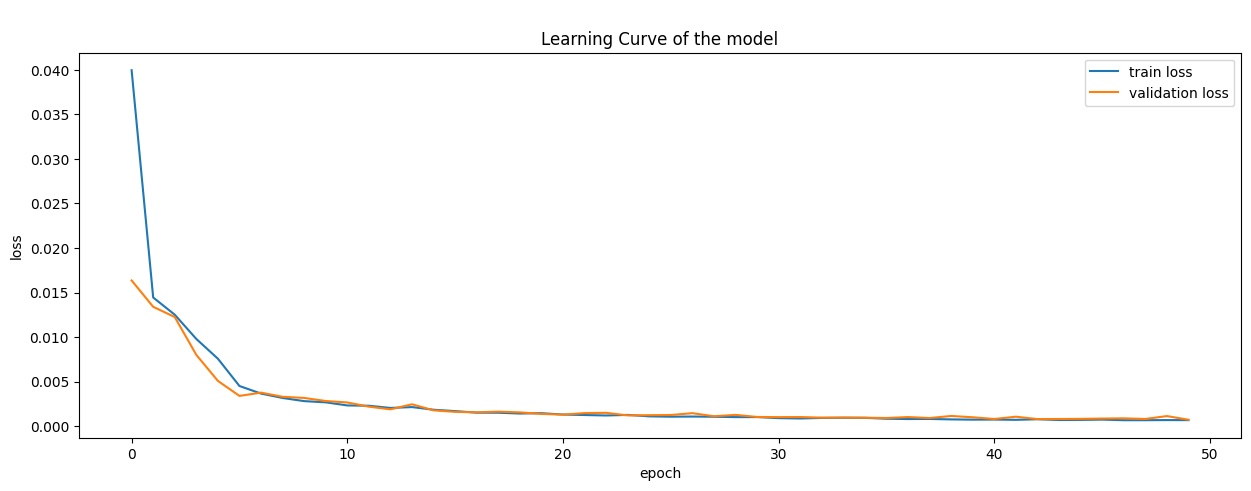


 MAE: 980.3098754882812, MAPE: 2.4566859006881714, RMSE: 1366.676671711345, R2: 0.9907351966408033, T-time: 00:04:26


 Training time 00:04:26

PREDICTIONS :  [[27996.80078125], [28244.740234375], [29233.82421875], [28301.396484375], [27797.109375], [26851.048828125], [30374.2109375], [31790.9921875], [38713.35546875], [45567.828125], [43529.42578125], [43453.546875], [45259.8828125], [45961.1640625], [46600.5], [45517.640625], [44388.09765625], [48161.05859375], [49246.53515625], [48959.80078125], [42223.3828125], [35499.75390625], [32642.2890625], [30536.6953125], [25974.99609375], [25046.384765625], [24305.525390625], [24113.818359375], [24859.4921875], [26936.5703125], [32311.619140625], [44434.63671875], [55544.5234375], [60996.3125], [62465.625], [62332.953125], [62440.12109375], [61925.01171875], [62733.62890625], [59328.07421875], [53423.44140625], [48542.1171875], [49136.1796875], [48032.34375], [40572.64453125], [34678.14453125], [31495.72265625], [28976.26953125], [27404.24

In [ ]:
# Fold 1
model, history, t, scaler_load, scaler_temp = build_P_C2DLSTM(train1, lookback, lookahead)
plot_history(history)
results = eval_P_C2DLSTM(model, test1, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Output: (6912, 1, 1)

ConvLSTM2D : (None, 1, 18, 32)
Flatten :  (None, 576)
ConvLSTM2D : (None, 1, 18, 12)
Flatten :  (None, 216)
CONCATENATING (None, 576), (None, 216)
Concate  (None, 792)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:08:30


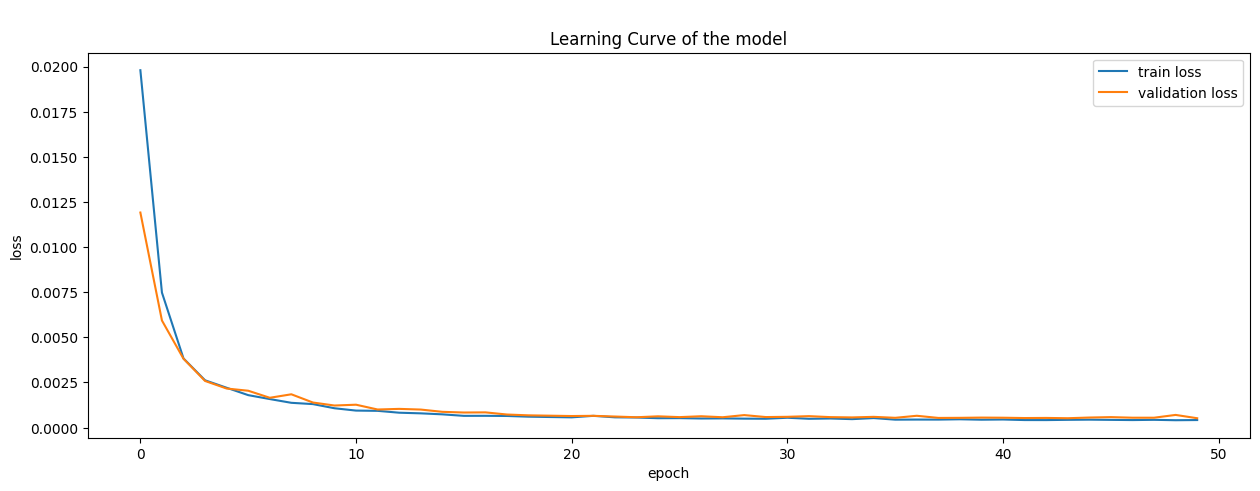


 MAE: 992.735107421875, MAPE: 2.4287089705467224, RMSE: 1527.8074976907267, R2: 0.9883340886572906, T-time: 00:08:30


 Training time 00:08:30

PREDICTIONS :  [[29604.791015625], [27311.83203125], [26573.19921875], [26690.484375], [27501.474609375], [30272.57421875], [31423.173828125], [42004.48046875], [50265.390625], [53766.4453125], [55132.4765625], [53255.8984375], [50207.1953125], [50198.30859375], [48974.015625], [48277.7578125], [46478.8203125], [49345.6875], [52535.97265625], [48708.8046875], [39381.01953125], [34899.36328125], [32342.26171875], [30254.3046875], [29409.853515625], [28272.080078125], [27071.236328125], [27017.806640625], [26971.73046875], [28308.46484375], [29211.818359375], [34056.625], [40416.58203125], [46453.796875], [47143.5078125], [43818.45703125], [44914.6796875], [46458.2109375], [45234.7265625], [45087.87890625], [44199.5703125], [47257.40625], [49025.484375], [46157.0], [37911.77734375], [33013.07421875], [30482.96484375], [28601.63671875], [27433.90

In [ ]:
# Fold 2
model, history, t, scaler_load, scaler_temp = build_P_C2DLSTM(train2, lookback, lookahead)
plot_history(history)
results = eval_P_C2DLSTM(model, test2, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Output: (10416, 1, 1)

ConvLSTM2D : (None, 1, 18, 32)
Flatten :  (None, 576)
ConvLSTM2D : (None, 1, 18, 12)
Flatten :  (None, 216)
CONCATENATING (None, 576), (None, 216)
Concate  (None, 792)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:11:26


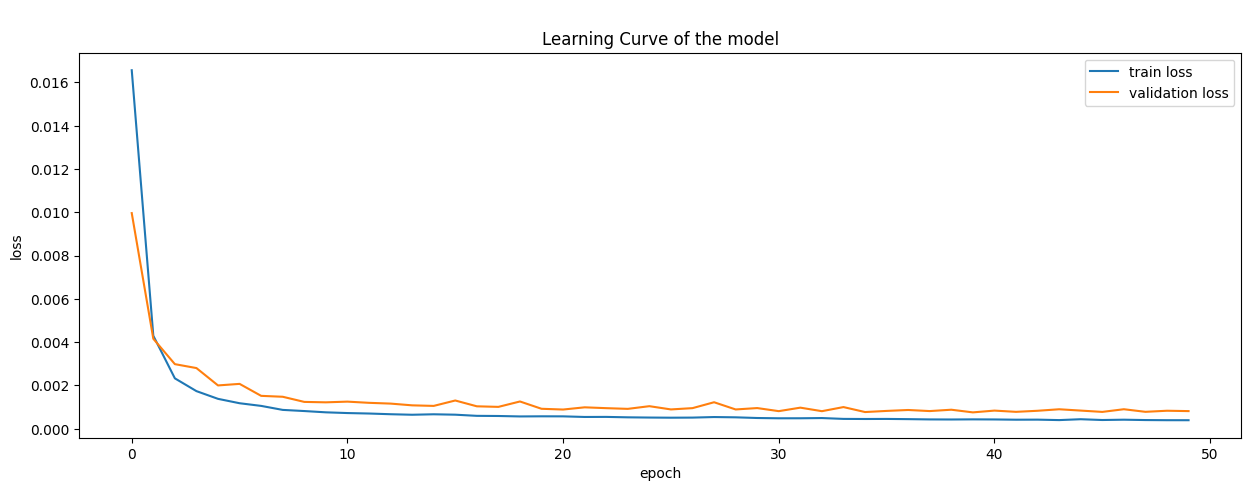


 MAE: 1046.378173828125, MAPE: 3.1742028892040253, RMSE: 2030.951070311641, R2: 0.9788430167782852, T-time: 00:11:26


 Training time 00:11:26

PREDICTIONS :  [[28955.26171875], [27831.6171875], [26527.439453125], [26328.60546875], [27715.7265625], [30079.60546875], [41241.48046875], [53792.02734375], [63221.55859375], [67112.921875], [66715.9375], [64814.25], [64120.609375], [64624.359375], [64606.66015625], [58366.06640625], [49886.16015625], [49141.58203125], [51031.8359375], [47813.22265625], [38274.42578125], [34179.65234375], [31764.9765625], [29812.810546875], [29057.814453125], [27675.515625], [26600.478515625], [26345.1171875], [27610.951171875], [29855.6640625], [31856.884765625], [39578.65234375], [49970.66015625], [54506.99609375], [52103.4609375], [49010.12109375], [47332.0625], [45515.90234375], [45872.58203125], [45300.71484375], [44378.79296875], [46574.33984375], [48422.609375], [46528.48046875], [36685.0859375], [32879.9609375], [30508.607421875], [29037.00390625], [

In [ ]:
# Fold 3
model, history, t, scaler_load, scaler_temp = build_P_C2DLSTM(train3, lookback, lookahead)
plot_history(history)
results = eval_P_C2DLSTM(model, test3, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Output: (13920, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
ConvLSTM2D : (None, 1, 20, 12)
Flatten :  (None, 240)
CONCATENATING (None, 640), (None, 240)
Concate  (None, 880)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:06:24


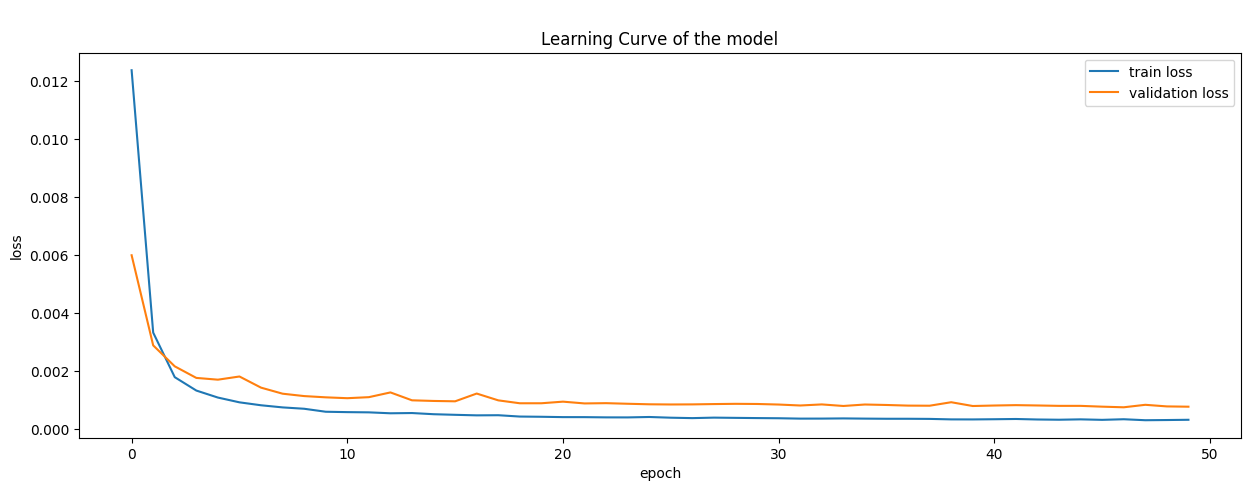


 MAE: 973.044189453125, MAPE: 2.3210670799016953, RMSE: 1435.9430699021461, R2: 0.9894894618477706, T-time: 00:06:24


 Training time 00:06:24

PREDICTIONS :  [[30550.140625], [29254.482421875], [27904.38671875], [27227.208984375], [27200.236328125], [30292.900390625], [30669.384765625], [36667.328125], [51578.19140625], [61555.6796875], [67343.9765625], [69877.0625], [68676.6640625], [68662.2421875], [69647.4140625], [71267.6953125], [65993.3125], [58088.203125], [52192.2890625], [53811.37890625], [52576.4296875], [44282.74609375], [39210.4921875], [34266.00390625], [31476.30078125], [31383.876953125], [29781.591796875], [30832.498046875], [31112.482421875], [35667.94921875], [43102.33203125], [64527.4609375], [72552.09375], [78728.609375], [74670.875], [70663.0], [70115.1640625], [71334.1484375], [70791.2734375], [63940.34765625], [52140.0078125], [50081.87109375], [52920.6875], [51641.0703125], [44731.3515625], [37111.36328125], [35409.890625], [33740.453125], [31681.748046875], [3

In [ ]:
# Fold 4
model, history, t, scaler_load, scaler_temp = build_P_C2DLSTM(train4, lookback, lookahead)
plot_history(history)
results = eval_P_C2DLSTM(model, test4, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# 7. PLCNet

In [ ]:
def build_REF30(train, lookback, lookahead):
    # data prepare
    train_x, _, train_y = reframe(train, lookback, lookahead)
    scaler = MinMaxScaler()
    # scaling load temp features and load label
    train_x = scaler.fit_transform(train_x.reshape(train_x.shape[0]*train_x.shape[1],train_x.shape[2])).reshape(-1,lookback,1)
    train_y = scaler.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    # # define model
    inputs = layers.Input(shape=(train_x.shape[1], train_x.shape[2]))
    print("Inputs: {},\n Output: {}\n".format(inputs.shape,train_y.shape))

    # CNN Path
    cnn_path = layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
    print("Conv1D-64 : {}".format(cnn_path.shape))
    cnn_path = layers.MaxPooling1D()(cnn_path)
    print("MaxPooling1D : {}".format(cnn_path.shape))
    cnn_path = layers.Conv1D(32, kernel_size=2, activation='relu')(cnn_path)
    print("Conv1D-32 : {}".format(cnn_path.shape))
    cnn_path = layers.Flatten()(cnn_path)
    print("Flatten : {}".format(cnn_path.shape))

    #LSTM Path
    lstm_path = layers.LSTM(48)(inputs)
    print("LSTM : {}".format(lstm_path.shape))

    # Concatenate paths
    merged_data = layers.concatenate([cnn_path, lstm_path])
    print("Concatenate : {}".format(merged_data.shape))
    merged_data = layers.Reshape((merged_data.shape[1], 1))(merged_data)
    print("Reshape : {}".format(merged_data.shape))

    # Fully Connected Layer
    fc_layer = layers.LSTM(300)(merged_data)
    print("LSTM : {}".format(fc_layer.shape))
    fc_layer = layers.Dense(50, activation='relu')(fc_layer)
    print("Dense128 : {}".format(fc_layer.shape))
    fc_layer = layers.Dropout(0.3)(fc_layer)
    print("Dropout : {}".format(fc_layer.shape))
    fc_layer = layers.Dense(24, activation='relu')(fc_layer)
    print("Dense64 : {}".format(fc_layer.shape))

    # Output Layer
    output_layer = layers.Dense(1, activation='linear')(fc_layer)
    print("outputs :",output_layer.shape)
    model = Model(inputs=inputs, outputs=output_layer, name="PLCnet")
    model.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    # mc = callbacks.ModelCheckpoint('convlstm2d.h5',monitor='val_loss',mode='min',save_best_only=True)
    history = model.fit(train_x,train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    # model = load_model('convlstm2d.h5')
    return model, history.history, t, scaler

# load and temp inputs series in ConvLSTM2D
def eval_REF30(model, test, scaler):
    test_x, _, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x = scaler.transform(test_x.reshape(test_x.shape[0]*test_x.shape[1],test_x.shape[2])).reshape(-1,lookback,1)

    yhat = model.predict(test_x, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat = scaler.inverse_transform(yhat).reshape(-1,lookahead)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

Inputs: (None, 96, 1),
 Output: (3407, 1, 1)

Conv1D-64 : (None, 95, 64)
MaxPooling1D : (None, 47, 64)
Conv1D-32 : (None, 46, 32)
Flatten : (None, 1472)
LSTM : (None, 48)
Concatenate : (None, 1520)
Reshape : (None, 1520, 1)
LSTM : (None, 300)
Dense128 : (None, 50)
Dropout : (None, 50)
Dense64 : (None, 24)
outputs : (None, 1)
Epoch 1/50
86/86 [==============================] - 22s 114ms/step - loss: 0.1083 - val_loss: 0.0718 - lr: 0.0010
Epoch 2/50
86/86 [==============================] - 8s 98ms/step - loss: 0.0545 - val_loss: 0.0152 - lr: 0.0010
Epoch 3/50
86/86 [==============================] - 8s 96ms/step - loss: 0.0154 - val_loss: 0.0117 - lr: 0.0010
Epoch 4/50
86/86 [==============================] - 8s 94ms/step - loss: 0.0087 - val_loss: 0.0101 - lr: 0.0010
Epoch 5/50
86/86 [==============================] - 8s 95ms/step - loss: 0.0077 - val_loss: 0.0094 - lr: 0.0010
Epoch 6/50
86/86 [==============================] - 8s 98ms/step - loss: 0.0066 - val_loss: 0.0059 - lr: 0.0010

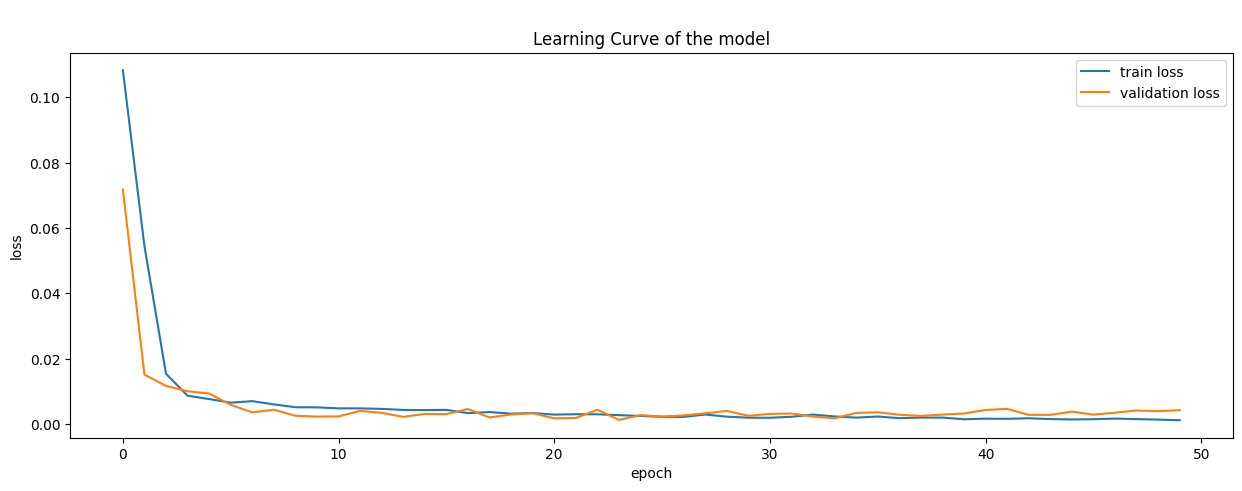


 MAE: 3051.05126953125, MAPE: 8.818057179450989, RMSE: 3646.9459825996873, R2: 0.9342135562518861, T-time: 00:07:33


 Training time 00:07:33

PREDICTIONS :  [[33784.421875], [32618.330078125], [32431.099609375], [32948.28515625], [33068.9921875], [33703.4296875], [34694.88671875], [36541.31640625], [36524.40625], [38263.94140625], [43629.15625], [46159.3125], [45950.796875], [45653.29296875], [46047.90234375], [46467.39453125], [46466.6484375], [46396.3984375], [47860.01171875], [49385.21875], [46156.71484375], [42439.875], [38969.41015625], [36552.2109375], [35041.34765625], [33520.23046875], [30213.396484375], [27544.197265625], [29520.787109375], [31389.919921875], [33486.28125], [40260.21484375], [51575.63671875], [59465.87890625], [63409.9921875], [62994.2734375], [61650.09765625], [62854.546875], [64286.22265625], [63494.6640625], [59022.0078125], [53301.31640625], [49888.7890625], [52748.83203125], [49941.91015625], [42771.69921875], [38741.3203125], [36282.1015625], [35134.08

In [ ]:
# Fold 1
model, history, t, scaler = build_REF30(train1, lookback, lookahead)
plot_history(history)
results = eval_REF30(model, test1, scaler)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 1),
 Output: (6910, 1, 1)

Conv1D-64 : (None, 95, 64)
MaxPooling1D : (None, 47, 64)
Conv1D-32 : (None, 46, 32)
Flatten : (None, 1472)
LSTM : (None, 48)
Concatenate : (None, 1520)
Reshape : (None, 1520, 1)
LSTM : (None, 300)
Dense128 : (None, 50)
Dropout : (None, 50)
Dense64 : (None, 24)
outputs : (None, 1)
Epoch 1/50
173/173 [==============================] - 23s 100ms/step - loss: 0.1090 - val_loss: 0.0510 - lr: 0.0010
Epoch 2/50
173/173 [==============================] - 16s 95ms/step - loss: 0.0209 - val_loss: 0.0110 - lr: 0.0010
Epoch 3/50
173/173 [==============================] - 16s 94ms/step - loss: 0.0092 - val_loss: 0.0065 - lr: 0.0010
Epoch 4/50
173/173 [==============================] - 17s 99ms/step - loss: 0.0072 - val_loss: 0.0070 - lr: 0.0010
Epoch 5/50
173/173 [==============================] - 16s 93ms/step - loss: 0.0055 - val_loss: 0.0065 - lr: 0.0010
Epoch 6/50
173/173 [==============================] - 16s 94ms/step - loss: 0.0046 - val_loss: 0.

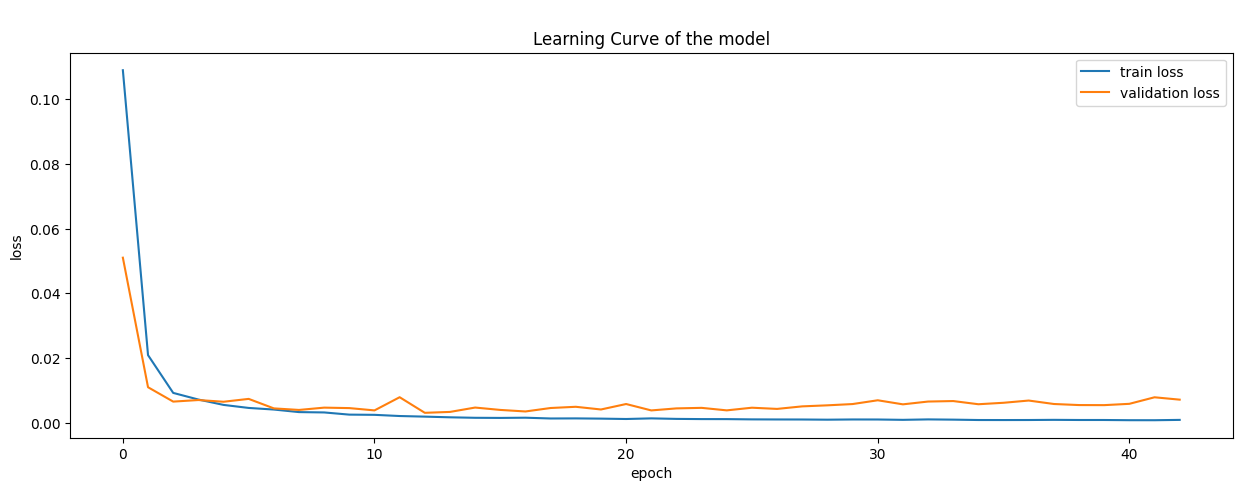


 MAE: 4268.6572265625, MAPE: 11.37782484292984, RMSE: 4787.532349760156, R2: 0.8860725051232341, T-time: 00:12:07


 Training time 00:12:07

PREDICTIONS :  [[36780.71875], [35178.39453125], [34069.890625], [32890.8046875], [32334.05859375], [32393.486328125], [33461.14453125], [35816.29296875], [37918.05859375], [44430.84375], [46000.5], [50793.60546875], [50569.13671875], [49713.171875], [47392.31640625], [46453.67578125], [46915.46484375], [46495.50390625], [46468.4296875], [47330.42578125], [49685.70703125], [46015.67578125], [43265.57421875], [39281.01171875], [37386.60546875], [35906.2734375], [34628.78125], [33619.61328125], [33080.53515625], [32892.23046875], [33244.0703125], [34727.828125], [35888.23828125], [39262.2890625], [42681.47265625], [45336.11328125], [45435.58203125], [45345.81640625], [44933.796875], [45090.04296875], [45386.8203125], [45579.3984375], [45774.96875], [46368.4921875], [47861.796875], [45658.25390625], [42239.8125], [37591.73046875], [35534.10546875], 

In [ ]:
# Fold 2
model, history, t, scaler = build_REF30(train2, lookback, lookahead)
plot_history(history)
results = eval_REF30(model, test2, scaler)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 1),
 Output: (10413, 1, 1)

Conv1D-64 : (None, 95, 64)
MaxPooling1D : (None, 47, 64)
Conv1D-32 : (None, 46, 32)
Flatten : (None, 1472)
LSTM : (None, 48)
Concatenate : (None, 1520)
Reshape : (None, 1520, 1)
LSTM : (None, 300)
Dense128 : (None, 50)
Dropout : (None, 50)
Dense64 : (None, 24)
outputs : (None, 1)
Epoch 1/50
261/261 [==============================] - 30s 98ms/step - loss: 0.0653 - val_loss: 0.0077 - lr: 0.0010
Epoch 2/50
261/261 [==============================] - 25s 95ms/step - loss: 0.0080 - val_loss: 0.0059 - lr: 0.0010
Epoch 3/50
261/261 [==============================] - 25s 95ms/step - loss: 0.0054 - val_loss: 0.0035 - lr: 0.0010
Epoch 4/50
261/261 [==============================] - 25s 95ms/step - loss: 0.0040 - val_loss: 0.0049 - lr: 0.0010
Epoch 5/50
261/261 [==============================] - 25s 95ms/step - loss: 0.0036 - val_loss: 0.0043 - lr: 0.0010
Epoch 6/50
261/261 [==============================] - 25s 95ms/step - loss: 0.0029 - val_loss: 0.

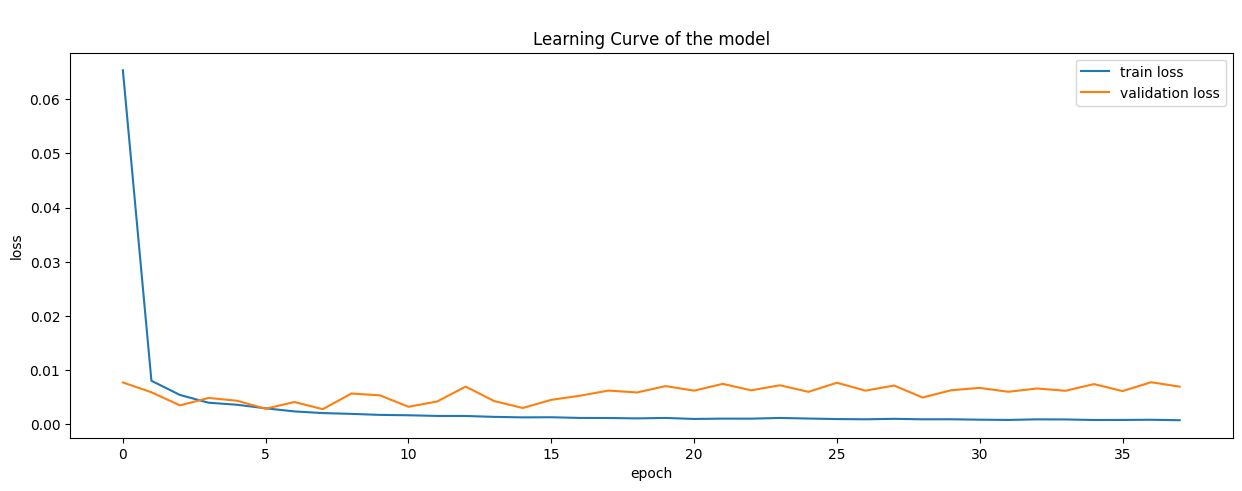


 MAE: 4062.54248046875, MAPE: 9.686797112226486, RMSE: 4782.668292909304, R2: 0.8838172427465162, T-time: 00:15:51


 Training time 00:15:51

PREDICTIONS :  [[35542.58203125], [34107.2578125], [33083.609375], [32580.966796875], [31696.236328125], [31903.423828125], [33305.30859375], [35731.5234375], [42239.3125], [50946.67578125], [55958.21484375], [59372.03125], [58326.30078125], [57284.19140625], [56415.3203125], [57016.34375], [57057.42578125], [52801.32421875], [48358.3046875], [48803.18359375], [50537.4375], [47769.2421875], [40732.33203125], [36576.1484375], [35430.30859375], [34138.80078125], [33268.84765625], [32754.12890625], [31937.802734375], [31905.869140625], [33092.05078125], [35160.49609375], [37455.15625], [41322.93359375], [46751.00390625], [51470.76953125], [49292.45703125], [48154.15234375], [46423.21484375], [46226.6328125], [46366.265625], [45571.515625], [44098.2578125], [46624.48046875], [47876.96875], [44693.1640625], [40265.16015625], [35851.31640625], [35083.

In [ ]:
# Fold 3
model, history, t, scaler = build_REF30(train3, lookback, lookahead)
plot_history(history)
results = eval_REF30(model, test3, scaler)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs: (None, 96, 1),
 Output: (13916, 1, 1)

Conv1D-64 : (None, 95, 64)
MaxPooling1D : (None, 47, 64)
Conv1D-32 : (None, 46, 32)
Flatten : (None, 1472)
LSTM : (None, 48)
Concatenate : (None, 1520)
Reshape : (None, 1520, 1)
LSTM : (None, 300)
Dense128 : (None, 50)
Dropout : (None, 50)
Dense64 : (None, 24)
outputs : (None, 1)
Epoch 1/50
348/348 [==============================] - 40s 102ms/step - loss: 0.0375 - val_loss: 0.0047 - lr: 0.0010
Epoch 2/50
348/348 [==============================] - 32s 93ms/step - loss: 0.0061 - val_loss: 0.0032 - lr: 0.0010
Epoch 3/50
348/348 [==============================] - 32s 92ms/step - loss: 0.0046 - val_loss: 0.0029 - lr: 0.0010
Epoch 4/50
348/348 [==============================] - 32s 93ms/step - loss: 0.0038 - val_loss: 0.0030 - lr: 0.0010
Epoch 5/50
348/348 [==============================] - 34s 98ms/step - loss: 0.0031 - val_loss: 0.0032 - lr: 0.0010
Epoch 6/50
348/348 [==============================] - 34s 99ms/step - loss: 0.0025 - val_loss: 0

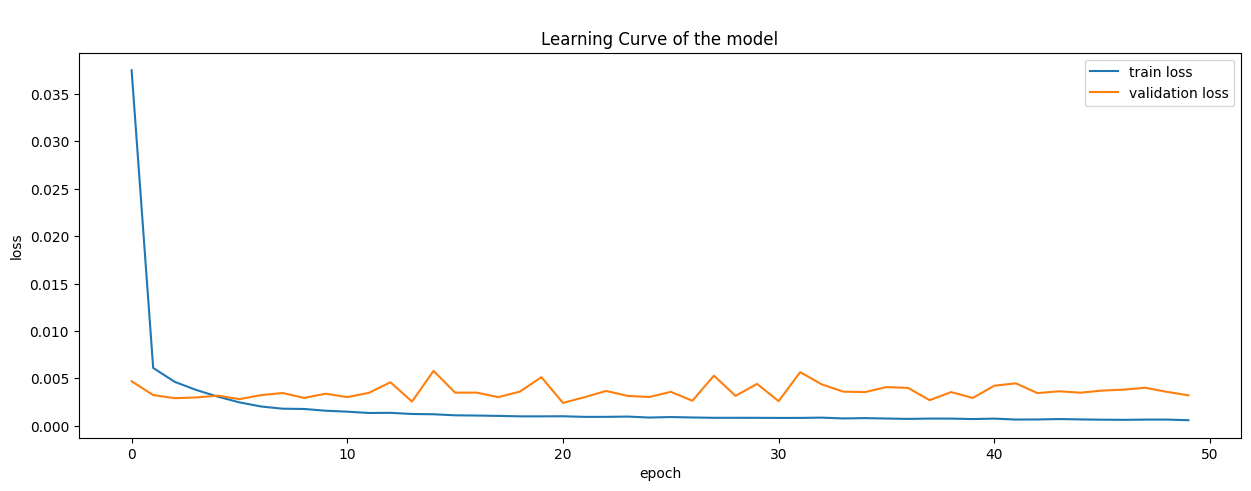


 MAE: 2506.690673828125, MAPE: 8.209672570228577, RMSE: 3347.053928457084, R2: 0.9425382764386757, T-time: 00:28:25


 Training time 00:28:25

PREDICTIONS :  [[38813.60546875], [36339.7890625], [34362.8046875], [33291.67578125], [32570.03515625], [32133.62890625], [32359.99609375], [32653.044921875], [34810.47265625], [44900.2109375], [60641.23828125], [67039.828125], [70128.2734375], [69427.6953125], [69444.265625], [69808.5234375], [70667.6015625], [70122.3828125], [63202.48828125], [52269.609375], [52084.69140625], [54142.37109375], [49541.20703125], [43465.18359375], [40674.78515625], [39182.85546875], [37300.2265625], [36400.94921875], [35794.984375], [35192.90234375], [35708.03515625], [36757.1484375], [39355.58203125], [47162.25390625], [62610.78125], [69088.9296875], [73143.5], [71064.4921875], [69678.09375], [68704.453125], [68978.0234375], [67505.6953125], [60921.4453125], [52339.87890625], [52752.3203125], [53063.3203125], [47835.65625], [43728.81640625], [40463.12109375], 

In [ ]:
# Fold 4
model, history, t, scaler = build_REF30(train4, lookback, lookahead)
plot_history(history)
results = eval_REF30(model, test4, scaler)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# A Baseline (Suggested)

In [ ]:
def Multiple_C2DLSTM(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp = MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    n_steps, rows, cols, n_features, n_outputs  = 4, 1, 24, 1, train_y.shape[1]

    train_x_load = train_x_load.reshape(-1,n_steps,rows,cols,n_features)
    train_x_temp = train_x_temp.reshape(-1,n_steps,rows,cols,n_features)

    # define model
    load_inputs = layers.Input(shape=(train_x_load.shape[1], train_x_load.shape[2],train_x_load.shape[3],train_x_load.shape[4]))
    temp_inputs = layers.Input(shape=(train_x_temp.shape[1], train_x_temp.shape[2],train_x_temp.shape[3],train_x_temp.shape[4]))

    print("Inputs:\n Load {},\n Temp {}\nOutput: {}\n".format(load_inputs.shape,temp_inputs.shape, train_y.shape))

    x1 = layers.ConvLSTM2D(filters=32, kernel_size=(1,5))(load_inputs)
    x1 = layers.Flatten()(x1)
    x1 = layers.Dense(24, activation="relu")(x1)
    x1 = layers.Dense(1)(x1)
    m1 = Model(load_inputs, x1)
    m1.compile(loss='mse', optimizer='adam')

    x2 = layers.ConvLSTM2D(filters=12, kernel_size=(1,5))(temp_inputs)
    x2 = layers.Flatten()(x2)
    x2 = layers.Dense(24, activation="relu")(x2)
    x2 = layers.Dense(1)(x2)
    m2 = Model(temp_inputs, x2)
    m2.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    # mc = callbacks.ModelCheckpoint('convlstm2d.h5',monitor='val_loss',mode='min',save_best_only=True)
    m1.fit(train_x_load, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=0)
    m2.fit(train_x_temp, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=0)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    # model = load_model('convlstm2d.h5')
    return m1,m2, t, scaler_load, scaler_temp

# load and temp inputs series in ConvLSTM2D
def eval_Multiple_C2DLSTM(m1,m2, test, scaler_load, scaler_temp):
    test_x_load, test_x_temp, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)

    n_steps, rows, cols, n_features  = 4, 1, 24, 1
    test_x_load = test_x_load.reshape(-1,n_steps,rows,cols,n_features)
    test_x_temp = test_x_temp.reshape(-1,n_steps,rows,cols,n_features)

    yhat = m1.predict(test_x_load, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat1 = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)

    yhat = m2.predict(test_x_temp, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat2 = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)

    yhat = np.mean([yhat1,yhat2], axis=0)

    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

In [ ]:
# Fold 1
m1,m2, t, scaler_load, scaler_temp = Multiple_C2DLSTM(train1, lookback, lookahead)
results = eval_Multiple_C2DLSTM(m1,m2, test1, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
Output: (3407, 1, 1)

Convergence time is : 00:05:49

 MAE: 2671.5263671875, MAPE: 6.434725970029831, RMSE: 3821.913264321942, R2: 0.9277497392485707, T-time: 00:05:49


 Training time 00:05:49

PREDICTIONS :  [[30968.125], [29276.341796875], [28926.02734375], [28721.099609375], [28301.40234375], [29056.513671875], [29399.423828125], [33504.3671875], [38714.43359375], [45172.3984375], [51681.11328125], [53438.75], [53102.21875], [53756.29296875], [54807.54296875], [55224.25], [52703.69921875], [50220.75], [51780.8125], [53022.953125], [49441.76953125], [41985.703125], [36221.59765625], [33272.59375], [31386.61328125], [29822.0234375], [28057.310546875], [26712.31640625], [28250.91796875], [30352.1640625], [33331.34375], [41390.875], [51580.23046875], [61224.16015625], [66436.7890625], [65991.6328125], [64661.80078125], [65070.84375], [65542.8515625], [65385.7734375], [61858.26171875], [54670.2265625], [52186.515625], [52927.7

In [ ]:
# Fold 2
m1,m2, t, scaler_load, scaler_temp = Multiple_C2DLSTM(train2, lookback, lookahead)
results = eval_Multiple_C2DLSTM(m1,m2, test2, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
Output: (6910, 1, 1)

Epoch 33: early stopping
Convergence time is : 00:07:15

 MAE: 2935.419677734375, MAPE: 6.841476261615753, RMSE: 3976.823355393096, R2: 0.921390017921911, T-time: 00:07:15


 Training time 00:07:15

PREDICTIONS :  [[32101.880859375], [29813.09765625], [29059.2734375], [28130.73828125], [26819.314453125], [26664.763671875], [28063.84375], [31003.36328125], [36317.12890625], [45335.953125], [53886.2109375], [57013.2421875], [56426.1171875], [55000.23828125], [54014.52734375], [54538.9453125], [54111.84375], [52262.49609375], [49400.2734375], [49832.6171875], [52081.4765625], [48703.0390625], [40210.734375], [35732.9609375], [32527.8828125], [30398.669921875], [29217.029296875], [28555.69140625], [27340.04296875], [26937.935546875], [27717.83203125], [29628.697265625], [34434.75], [41075.10546875], [49105.7734375], [53619.1953125], [53448.546875], [51081.9921875], [50633.08984375], [50806.1875], [50884.1562

In [ ]:
# Fold 3
m1,m2, t, scaler_load, scaler_temp = Multiple_C2DLSTM(train3, lookback, lookahead)
results = eval_Multiple_C2DLSTM(m1,m2, test3, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
Output: (10413, 1, 1)

Epoch 37: early stopping
Convergence time is : 00:10:58

 MAE: 3386.498291015625, MAPE: 7.912810891866684, RMSE: 4511.87344680677, R2: 0.8966013226373082, T-time: 00:10:58


 Training time 00:10:58

PREDICTIONS :  [[33792.015625], [30826.7578125], [29264.865234375], [27793.9140625], [27716.72265625], [27543.076171875], [28144.04296875], [30109.16015625], [37517.7890625], [47325.515625], [57404.046875], [64168.578125], [65446.8203125], [64446.7265625], [63674.859375], [61671.4296875], [62549.1171875], [60124.4453125], [54931.5625], [51517.5625], [50483.48828125], [49261.99609375], [44911.96484375], [37427.0078125], [33732.8515625], [30976.546875], [29343.453125], [28515.5546875], [28761.0703125], [28218.48828125], [28205.1640625], [29042.984375], [31777.41796875], [36721.1171875], [46865.0234375], [54940.546875], [56544.796875], [55710.8671875], [53479.84765625], [51419.296875], [51714.4921875], [51925.6

In [ ]:
# Fold 4
m1,m2, t, scaler_load, scaler_temp = Multiple_C2DLSTM(train4, lookback, lookahead)
results = eval_Multiple_C2DLSTM(m1,m2, test4, scaler_load, scaler_temp)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
Output: (13916, 1, 1)

Epoch 47: early stopping
Epoch 37: early stopping
Convergence time is : 00:14:52

 MAE: 7375.31884765625, MAPE: 18.964673578739166, RMSE: 8790.797005960267, R2: 0.6036218515823046, T-time: 00:14:52


 Training time 00:14:52

PREDICTIONS :  [[39687.5859375], [35171.01953125], [31902.734375], [30057.822265625], [28287.26171875], [27563.8515625], [27326.359375], [27753.96875], [28389.46875], [35009.83984375], [44715.82421875], [53112.25], [57342.6875], [62619.7734375], [64518.6484375], [66274.625], [67991.9609375], [67452.9296875], [65021.4140625], [58246.3046875], [56211.8828125], [53728.28125], [53446.875], [51071.921875], [46217.0], [41406.1796875], [37752.53125], [35005.8984375], [31648.78515625], [30170.59375], [29647.0390625], [30137.1015625], [31588.81640625], [37708.77734375], [46589.34375], [54372.6484375], [59022.1953125], [65007.97265625], [66038.90625], [67020.28125], [67513.5234375], [65409.15

# ABLATION EXPERIMENTS

In [ ]:
def build_WithoutOtherFeatures(train, lookback, lookahead):
    # data prepare
    train_x_load, _, train_y = reframe(train, lookback, lookahead)
    scaler_load  = MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    n_steps, rows, cols, n_features, n_outputs  = 4, 1, 24, 1, train_y.shape[1]

    train_x_load = train_x_load.reshape(-1,n_steps,rows,cols,n_features)
    # define model
    load_inputs = layers.Input(shape=(train_x_load.shape[1], train_x_load.shape[2],train_x_load.shape[3],train_x_load.shape[4]))
    print("Inputs:\n Load {}\n Output: {}\n".format(load_inputs.shape,train_y.shape))

    x = layers.ConvLSTM2D(filters=32, kernel_size=(1,5))(load_inputs)
    print("ConvLSTM2D : {}".format(x.shape))
    x = layers.Flatten()(x)
    print("Flatten : ", x.shape)

    x = layers.Dense(24, activation="relu")(x)
    print("D24 :",x.shape)
    x = layers.Dense(1)(x)
    print("outputs :",x.shape)
    model = Model(inputs=load_inputs, outputs=x, name="WithoutOtherFeatures")
    model.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    # mc = callbacks.ModelCheckpoint('convlstm2d.h5',monitor='val_loss',mode='min',save_best_only=True)
    history = model.fit(train_x_load, train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    # model = load_model('convlstm2d.h5')
    return model, history.history, t, scaler_load

# load and temp inputs series in ConvLSTM2D
def eval_WithoutOtherFeatures(model, test, scaler_load):
    test_x_load, _, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)

    n_steps, rows, cols, n_features  = 4, 1, 24, 1

    test_x_load = test_x_load.reshape(-1,n_steps,rows,cols,n_features)

    yhat = model.predict(test_x_load, verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

Inputs:
 Load (None, 4, 1, 24, 1)
 Output: (3408, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:03:25


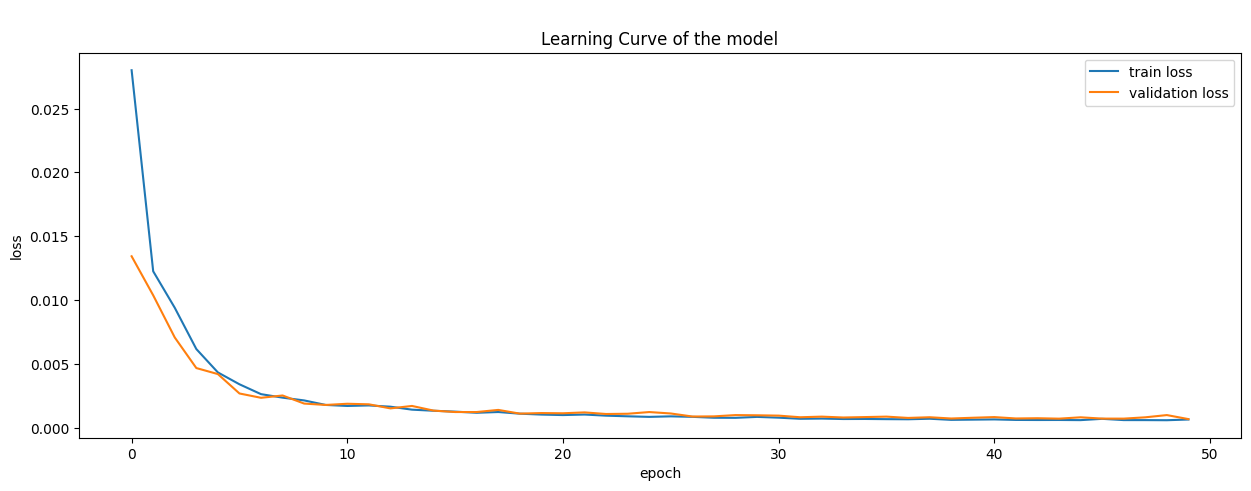


 MAE: 977.4054565429688, MAPE: 2.4900566786527634, RMSE: 1367.0597097420434, R2: 0.9907300014327685, T-time: 00:03:25


 Training time 00:03:25

PREDICTIONS :  [[28147.984375], [28455.275390625], [28113.27734375], [27962.7265625], [27839.509765625], [28220.828125], [31537.734375], [31621.2734375], [39301.953125], [44494.35546875], [43948.19140625], [43779.99609375], [44958.375], [46534.66015625], [46891.7265625], [45346.5], [44129.44140625], [46455.1875], [49215.3671875], [47060.06640625], [42796.94140625], [35456.796875], [31732.4921875], [29984.111328125], [24610.830078125], [24184.16796875], [23820.10546875], [23875.43359375], [24529.298828125], [26354.873046875], [32183.841796875], [43721.99609375], [55263.046875], [60699.80078125], [62317.88671875], [61942.58203125], [62345.47265625], [63198.3125], [63289.23046875], [61134.33984375], [52290.765625], [48877.80859375], [49663.609375], [48352.48046875], [39859.1640625], [34613.5390625], [30794.232421875], [28216.09765625], [26457.49

In [ ]:
# Fold 1
model, history, t, scaler_load = build_WithoutOtherFeatures(train1, lookback, lookahead)
plot_history(history)
results = eval_WithoutOtherFeatures(model, test1, scaler_load)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1)
 Output: (6912, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:05:24


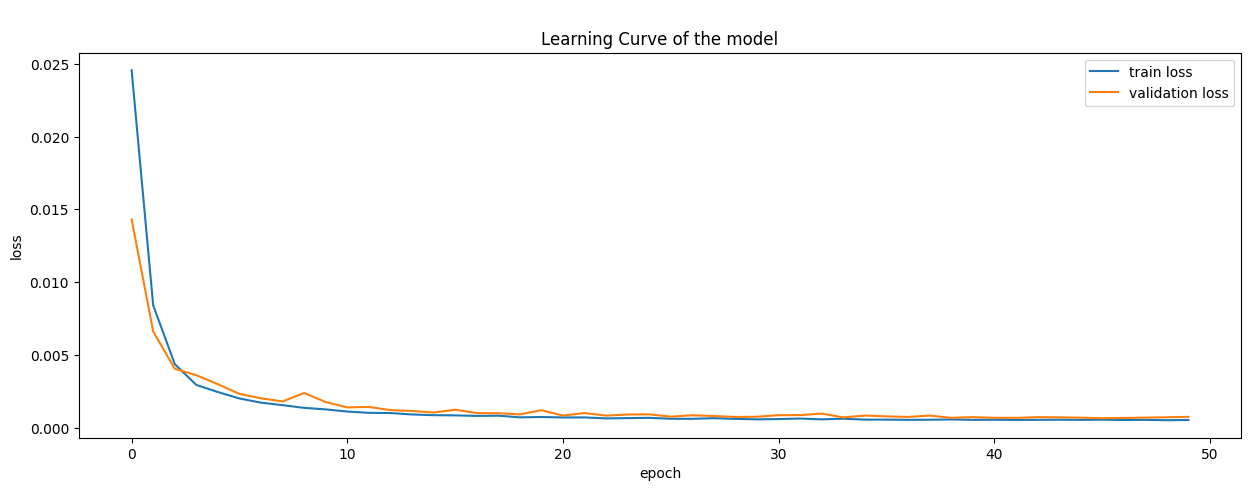


 MAE: 1150.51708984375, MAPE: 2.8580058366060257, RMSE: 1736.42470323363, R2: 0.9849306913400605, T-time: 00:05:24


 Training time 00:05:24

PREDICTIONS :  [[29547.029296875], [28045.912109375], [27313.27734375], [27045.4609375], [28430.73046875], [30698.1328125], [34679.44140625], [41907.13671875], [51823.4296875], [55533.5234375], [55692.84765625], [53333.18359375], [50490.98046875], [50134.6015625], [49747.44140625], [48619.51171875], [47624.8359375], [49380.8828125], [52485.703125], [47590.10546875], [39456.81640625], [34675.5703125], [32668.333984375], [30805.36328125], [29796.283203125], [28775.330078125], [27725.6953125], [27291.451171875], [27571.0546875], [29669.65234375], [33093.77734375], [35168.71875], [40501.26953125], [48080.29296875], [48069.56640625], [44088.7734375], [45733.7265625], [46606.96875], [46379.3125], [45759.55859375], [45242.87109375], [47986.70703125], [49275.5546875], [46036.421875], [38067.796875], [33083.56640625], [30841.337890625], [29111.861328125]

In [ ]:
# Fold 2
model, history, t, scaler_load = build_WithoutOtherFeatures(train2, lookback, lookahead)
plot_history(history)
results = eval_WithoutOtherFeatures(model, test2, scaler_load)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1)
 Output: (10416, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:07:26


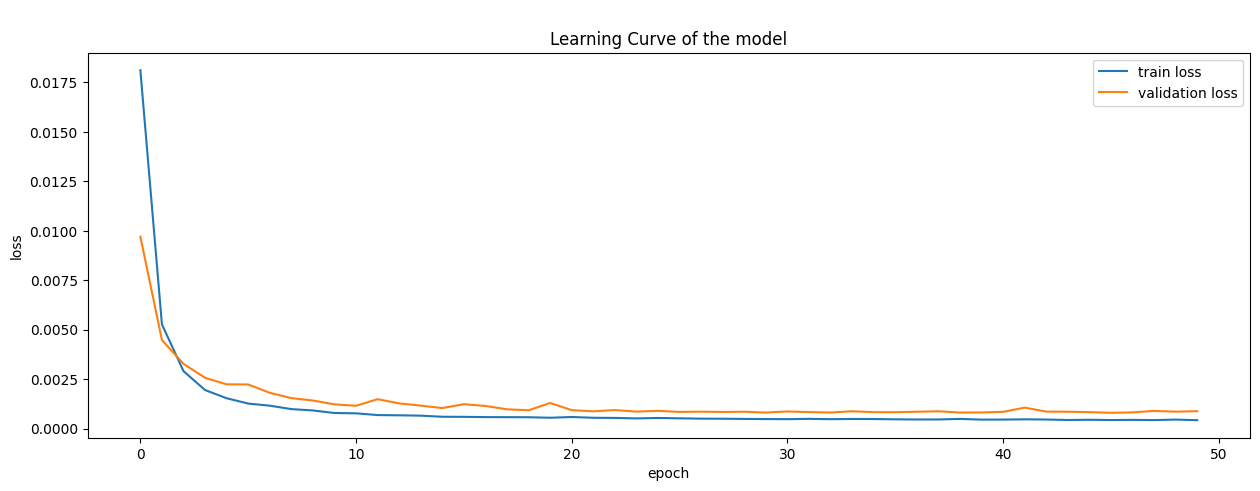


 MAE: 1133.1527099609375, MAPE: 3.38066928088665, RMSE: 2201.1343666391654, R2: 0.9751487658379755, T-time: 00:07:26


 Training time 00:07:26

PREDICTIONS :  [[28603.19140625], [27944.638671875], [26784.744140625], [26696.333984375], [28234.490234375], [30246.38671875], [41506.6796875], [53772.0078125], [61935.890625], [65382.140625], [64919.63671875], [63852.8828125], [63621.1484375], [63758.71875], [63560.703125], [57817.62109375], [51548.63671875], [50713.03125], [51490.00390625], [47326.3671875], [39431.9765625], [34716.51953125], [31781.748046875], [29971.591796875], [28836.234375], [27885.1171875], [26983.498046875], [26907.8046875], [28264.498046875], [29834.93359375], [33580.10546875], [39072.41796875], [48738.26953125], [53358.6953125], [50654.19140625], [48862.9375], [46182.33984375], [45124.27734375], [44391.7265625], [43917.52734375], [44400.6171875], [47688.15234375], [48744.515625], [45510.84375], [37164.91015625], [33502.6640625], [30908.982421875], [29106.029296875], 

In [ ]:
# Fold 3
model, history, t, scaler_load = build_WithoutOtherFeatures(train3, lookback, lookahead)
plot_history(history)
results = eval_WithoutOtherFeatures(model, test3, scaler_load)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

Inputs:
 Load (None, 4, 1, 24, 1)
 Output: (13920, 1, 1)

ConvLSTM2D : (None, 1, 20, 32)
Flatten :  (None, 640)
D24 : (None, 24)
outputs : (None, 1)
Convergence time is : 00:03:23


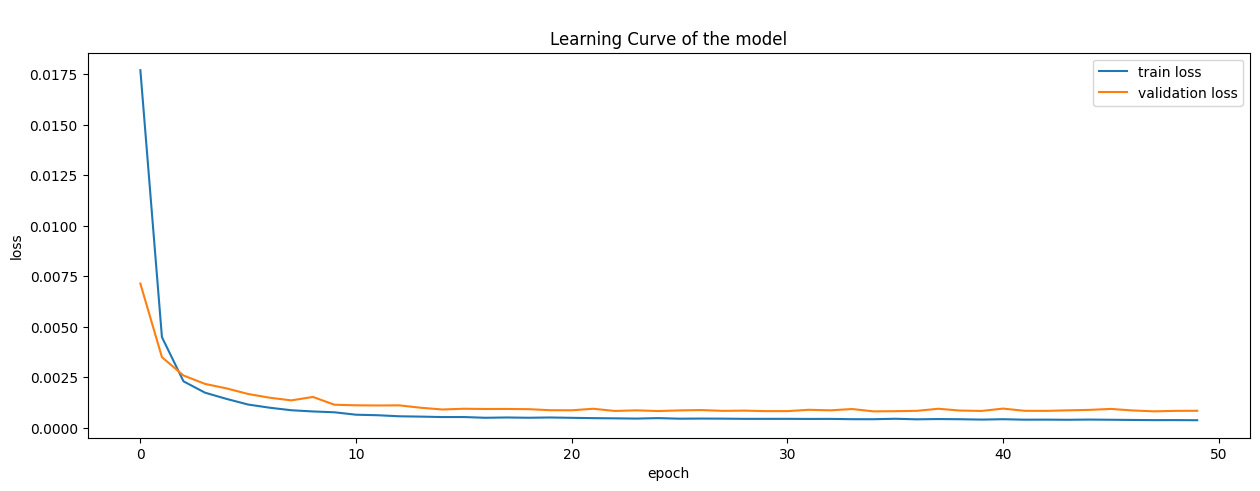


 MAE: 1128.8138427734375, MAPE: 2.7122002094984055, RMSE: 1586.3235798537448, R2: 0.9871727349113887, T-time: 00:03:23


 Training time 00:03:23

PREDICTIONS :  [[29702.30859375], [28650.720703125], [27260.505859375], [26922.994140625], [26674.634765625], [29113.44140625], [30858.12109375], [35834.5390625], [50519.4375], [59362.12890625], [66176.5234375], [68785.5546875], [67756.3515625], [67345.9140625], [68074.703125], [69644.5546875], [65963.0546875], [58767.9609375], [52107.73046875], [54672.15234375], [51872.94140625], [42992.37890625], [38122.015625], [33445.05078125], [30744.779296875], [30339.892578125], [29338.17578125], [29909.375], [29842.384765625], [33731.375], [42060.44140625], [65045.3046875], [71005.34375], [77315.390625], [74173.78125], [70356.5546875], [68285.5859375], [69368.46875], [70348.65625], [63167.93359375], [49822.4375], [49906.9765625], [52616.11328125], [50837.20703125], [43760.9453125], [36621.20703125], [34201.71484375], [31916.41796875], [29840.69726562

In [ ]:
# Fold 4
model, history, t, scaler_load = build_WithoutOtherFeatures(train4, lookback, lookahead)
plot_history(history)
results = eval_WithoutOtherFeatures(model, test4, scaler_load)
print("\n MAE: {}, MAPE: {}, RMSE: {}, R2: {}, T-time: {}\n".format(results['MAE'],results['MAPE'],results['RMSE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")

# REFERENCE 30 SETTINGS (malaysia)

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from tensorflow.keras import Model, callbacks, layers

In [ ]:
path = "/content/drive/MyDrive/DATASETS/malaysia_all_data_for_paper_ori.csv"
dataset = pd.read_csv(path)
# dataset = pd.read_csv("malaysia_all_data_for_paper_ori.csv")
dataset["time"] = pd.to_datetime(dataset["time"])
dataset.set_index("time", inplace=True)
dataset.sort_index(inplace=True)
dataset["Date"] = dataset.index

def reframe(data, lookback, lookahead):
  x_load, x_temp, y = [],[],[]
  start = 0
  for _ in range(len(data)):
    feature_end = start + lookback
    label_end = feature_end + lookahead
    if label_end <= len(data):
      # historical load feature
      v = data[start:feature_end, 1]
      v = v.reshape(len(v),1)
      x_load.append(v)
      # temperature features
      v = data[start:feature_end, 0]
      v = v.reshape(len(v),1)
      x_temp.append(v)
      # load labels
      v = data[feature_end:label_end, 1]
      v = v.reshape(len(v),1)
      y.append(v)
    start += lookahead
  x_load, x_temp = np.asarray(x_load).astype('float32'), np.asarray(x_temp).astype('float32')
  y = np.asarray(y).astype('float32')
  return x_load, x_temp, y

def plotForDay(n, results):
  n=50
  plt.figure(figsize=(15,5))
  hours = [x for x in range(n)]
  plt.plot(hours, results['Predictions'].flatten()[:n], label='Predicted Load', marker='X',zorder=-10)
  plt.plot(hours, results['Actual'].flatten()[:n], label='Actual Load', marker='o',zorder=-10)
  plt.xticks(hours)
  # plt.title("Input day {} -> Predicted day {}.".format(results['Input_days'][n],results['Prediction_days'][n]))
  plt.ylabel('Load')
  plt.xlabel('Hours')
  plt.legend()
  plt.show()
  print("\n")

def evaluate_forecasts(actu, pred):
  # mae, mape, rmse, r2
  mae = mean_absolute_error(actu, pred)
  mape = mean_absolute_percentage_error(actu, pred)*100
  mse = mean_squared_error(actu, pred)
  rmse = math.sqrt(mse)
  r2 = r2_score(actu, pred)
  return mae, mape, rmse, r2

def plot_history(history):
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('\nLearning Curve of the model')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'validation loss'])
    plt.show()

## SPLIT DATASET TRAINING 2009, TESTING 2010
train, test = np.array(dataset[:8759]), np.array(dataset[8759:13139])
print("Train set : {} \nTest set : {}".format(train.shape,test.shape))

lookahead = 1
lookback = 96

_, _, actu = reframe(test, lookback, lookahead)
actu = actu.ravel()

Train set : (8759, 3) 
Test set : (4380, 3)


In [ ]:
print(actu.tolist())

[27220.0, 26375.0, 25861.0, 26129.0, 28326.0, 32270.0, 41524.0, 50732.0, 61987.0, 65158.0, 66201.0, 64683.0, 65561.0, 66465.0, 66155.0, 61645.0, 52468.0, 51009.0, 51190.0, 48551.0, 38706.0, 34858.0, 31334.0, 29471.0, 28376.0, 27415.0, 26678.0, 26969.0, 29366.0, 33462.0, 42493.0, 51979.0, 63534.0, 66210.0, 67003.0, 65616.0, 66651.0, 67710.0, 66835.0, 60779.0, 51883.0, 50930.0, 52393.0, 49484.0, 39285.0, 35045.0, 32203.0, 30089.0, 28601.0, 27554.0, 26820.0, 27044.0, 28639.0, 32462.0, 41501.0, 49615.0, 59902.0, 62074.0, 62625.0, 62009.0, 62423.0, 62780.0, 62405.0, 57323.0, 50165.0, 49950.0, 51032.0, 47752.0, 38263.0, 34211.0, 31020.0, 29348.0, 27959.0, 26876.0, 26296.0, 26691.0, 28539.0, 32390.0, 42810.0, 51519.0, 62604.0, 65328.0, 65541.0, 64384.0, 64764.0, 65938.0, 65216.0, 59585.0, 51124.0, 50882.0, 51414.0, 48437.0, 38296.0, 34092.0, 31320.0, 29177.0, 28152.0, 27214.0, 26453.0, 26219.0, 27257.0, 28716.0, 31328.0, 38830.0, 49891.0, 52521.0, 53764.0, 50342.0, 48628.0, 48239.0, 47152.0, 

In [ ]:

es = callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=30,verbose=1)
rop = callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.2,min_lr=0.001)
# mc = callbacks.ModelCheckpoint('best_model.h5',monitor='val_loss',mode='min',save_best_only=True)
verbose, epochs, batch_size = 1, 100, 32

def build_P_C2DLSTM(train, lookback, lookahead):
    # data prepare
    train_x_load, train_x_temp, train_y = reframe(train, lookback, lookahead)
    scaler_load, scaler_temp  = MinMaxScaler(), MinMaxScaler()
    # scaling load temp features and load label
    train_x_load = scaler_load.fit_transform(train_x_load.reshape(train_x_load.shape[0]*train_x_load.shape[1],train_x_load.shape[2])).reshape(-1,lookback,1)
    train_x_temp = scaler_temp.fit_transform(train_x_temp.reshape(train_x_temp.shape[0]*train_x_temp.shape[1],train_x_temp.shape[2])).reshape(-1,lookback,1)
    train_y = scaler_load.transform(train_y.reshape(train_y.shape[0]*train_y.shape[1],train_y.shape[2])).reshape(-1,lookahead,1)

    n_steps, rows, cols, n_features, n_outputs  = 4, 1, 24, 1, train_y.shape[1]

    train_x_load = train_x_load.reshape(-1,n_steps,rows,cols,n_features)
    train_x_temp = train_x_temp.reshape(-1,n_steps,rows,cols,n_features)
    # define model
    load_inputs = layers.Input(shape=(train_x_load.shape[1], train_x_load.shape[2],train_x_load.shape[3],train_x_load.shape[4]))
    temp_inputs = layers.Input(shape=(train_x_temp.shape[1], train_x_temp.shape[2],train_x_temp.shape[3],train_x_temp.shape[4]))
    print("Inputs:\n Load {},\n Temp {}\n Output: {}\n".format(load_inputs.shape,temp_inputs.shape,train_y.shape))

    x1 = layers.ConvLSTM2D(filters=64, kernel_size=(1,5))(load_inputs)
    print("ConvLSTM2D : {}".format(x1.shape))
    x1 = layers.Flatten()(x1)
    print("Flatten : ", x1.shape)

    x2 = layers.ConvLSTM2D(filters=24, kernel_size=(1,5))(temp_inputs)
    print("ConvLSTM2D : {}".format(x2.shape))
    x2 = layers.Flatten()(x2)
    print("Flatten : ", x2.shape)

    print("CONCATENATING {}, {}".format(x1.shape,x2.shape))
    x = layers.Concatenate()([x1,x2])
    print("Concate ",x.shape)
    x = layers.Dense(24, activation="relu")(x)
    print("D24 :",x.shape)
    x = layers.Dense(1,activation="linear")(x)
    print("outputs :",x.shape)
    model = Model(inputs=[load_inputs, temp_inputs], outputs=x, name="P-CLSTM2D")
    model.compile(loss='mse', optimizer='adam')

    # fit network
    start_time = time.time()
    # mc = callbacks.ModelCheckpoint('convlstm2d.h5',monitor='val_loss',mode='min',save_best_only=True)
    history = model.fit([train_x_load, train_x_temp],
                        train_y, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[es,rop], verbose=verbose)
    t=time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print(f'Convergence time is : {t}')
    # model = load_model('convlstm2d.h5')
    return model, history.history, t, scaler_load, scaler_temp

# load and temp inputs series in ConvLSTM2D
def eval_P_C2DLSTM(model, test, scaler_load, scaler_temp):
    test_x_load, test_x_temp, test_y = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)

    n_steps, rows, cols, n_features  = 4, 1, 24, 1

    test_x_load = test_x_load.reshape(-1,n_steps,rows,cols,n_features)
    test_x_temp = test_x_temp.reshape(-1,n_steps,rows,cols,n_features)

    yhat = model.predict([test_x_load, test_x_temp], verbose=0)
    yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
    yhat = scaler_load.inverse_transform(yhat).reshape(-1,lookahead)
    test_y =  test_y.reshape( test_y.shape[0],test_y.shape[1])
    mae, mape, rmse, r2 = evaluate_forecasts(test_y, yhat)
    results = {"MAE":mae,'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":test_y}
    return results

# load and temp inputs series in ConvLSTM2D
def eval_P_C2DLSTM_SCALED(model, test, scaler_load, scaler_temp):
    test_x_load, test_x_temp, ytest = reframe(test, lookback, lookahead)
    # scaling load temp features and load label
    test_x_load = scaler_load.transform(test_x_load.reshape(test_x_load.shape[0]*test_x_load.shape[1],test_x_load.shape[2])).reshape(-1,lookback,1)
    test_x_temp = scaler_temp.transform(test_x_temp.reshape(test_x_temp.shape[0]*test_x_temp.shape[1],test_x_temp.shape[2])).reshape(-1,lookback,1)

    n_steps, rows, cols, n_features  = 4, 1, 24, 1

    test_x_load = test_x_load.reshape(-1,n_steps,rows,cols,n_features)
    test_x_temp = test_x_temp.reshape(-1,n_steps,rows,cols,n_features)

    yhat_scaled = model.predict([test_x_load, test_x_temp], verbose=0)
    yhat_scaled = yhat_scaled.reshape(yhat_scaled.shape[0]*yhat_scaled.shape[1],1)
    yhat = scaler_load.inverse_transform(yhat_scaled).reshape(-1,lookahead)


    ytest_scaled = scaler_load.transform(ytest.reshape(ytest.shape[0]*ytest.shape[1],ytest.shape[2])).reshape(-1,lookahead,1)
    ytest_scaled =  ytest_scaled.reshape(ytest_scaled.shape[0],ytest_scaled.shape[1])

    ytest =  ytest.reshape(ytest.shape[0],ytest.shape[1])

    mse = mean_squared_error(ytest_scaled, yhat_scaled)
    rmse = math.sqrt(mse)

    mape = mean_absolute_percentage_error(ytest, yhat)*100

    r2 = r2_score(ytest_scaled, yhat_scaled)

    results = {'MAPE':mape,"RMSE":rmse,"R2":r2,"Predictions":yhat,"Actual":ytest}
    return results

Inputs:
 Load (None, 4, 1, 24, 1),
 Temp (None, 4, 1, 24, 1)
 Output: (8663, 1, 1)

ConvLSTM2D : (None, 1, 20, 64)
Flatten :  (None, 1280)
ConvLSTM2D : (None, 1, 20, 24)
Flatten :  (None, 480)
CONCATENATING (None, 1280), (None, 480)
Concate  (None, 1760)
D24 : (None, 24)
outputs : (None, 1)
Epoch 1/100
217/217 [==============================] - 20s 56ms/step - loss: 0.0173 - val_loss: 0.0055 - lr: 0.0010
Epoch 2/100
217/217 [==============================] - 10s 45ms/step - loss: 0.0040 - val_loss: 0.0025 - lr: 0.0010
Epoch 3/100
217/217 [==============================] - 11s 49ms/step - loss: 0.0025 - val_loss: 0.0016 - lr: 0.0010
Epoch 4/100
217/217 [==============================] - 11s 51ms/step - loss: 0.0019 - val_loss: 0.0018 - lr: 0.0010
Epoch 5/100
217/217 [==============================] - 9s 40ms/step - loss: 0.0016 - val_loss: 0.0015 - lr: 0.0010
Epoch 6/100
217/217 [==============================] - 9s 40ms/step - loss: 0.0013 - val_loss: 9.9534e-04 - lr: 0.0010
Epoch 7/10

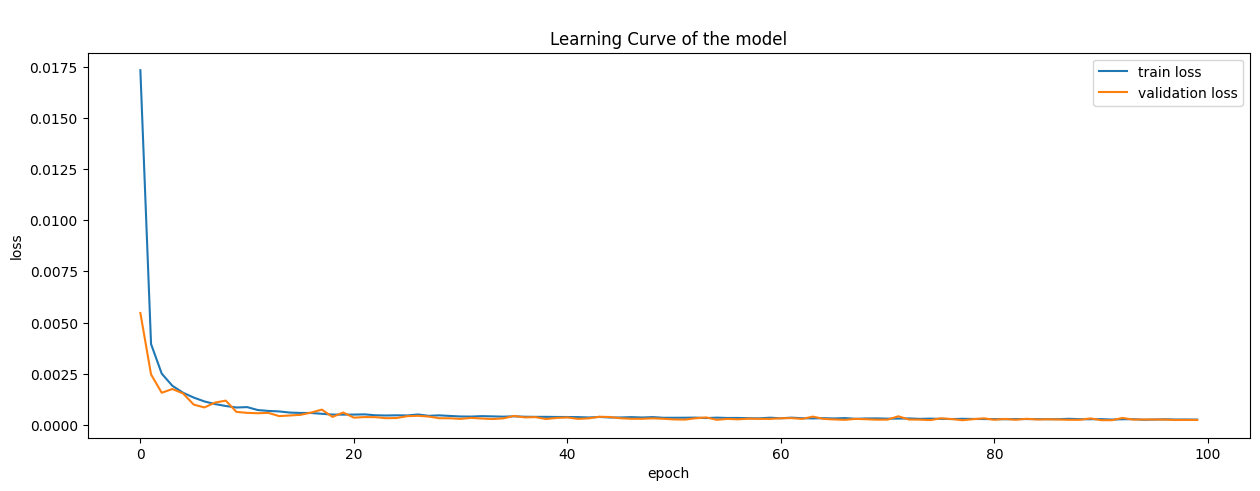


 RMSE: 0.021141874090194343, MAPE: 1.9402462989091873, R2: 0.9929738943997115, T-time: 00:13:28


 Training time 00:13:28

PREDICTIONS :  [[27374.681640625], [26173.267578125], [25373.75], [25592.453125], [26921.521484375], [32261.52734375], [42008.86328125], [51786.203125], [60708.9765625], [65119.9609375], [65479.51171875], [65090.73046875], [64318.93359375], [66253.8828125], [66465.3671875], [60797.8671875], [52079.4375], [50485.72265625], [51303.51953125], [48295.578125], [39493.34375], [34860.68359375], [31274.09375], [29200.53515625], [27778.408203125], [27367.48828125], [26753.638671875], [26493.2421875], [28167.244140625], [33449.05859375], [43173.58984375], [52554.25], [61492.7890625], [65955.0], [66065.0625], [66072.7890625], [65431.65625], [67472.609375], [66836.4453125], [61011.58984375], [51489.765625], [49730.37109375], [51401.66796875], [49321.59375], [40337.3125], [35609.15625], [31684.193359375], [30062.26953125], [28639.8046875], [27643.3984375], [26691.693359375], [

In [ ]:
# Experiment
model, history, t, scaler_load, scaler_temp = build_P_C2DLSTM(train, lookback, lookahead)
plot_history(history)
results = eval_P_C2DLSTM_SCALED(model, test, scaler_load, scaler_temp)
print("\n RMSE: {}, MAPE: {}, R2: {}, T-time: {}\n".format(results['RMSE'], results['MAPE'],results['R2'],t))
print("\n Training time {}".format(t))
print("\nPREDICTIONS : ",results["Predictions"].tolist())
print("\nLEARNING LOSS : ",history["loss"])
print("\n")